<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURUSD/EURUSD_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURUSD"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-07-25 04:59:45,665 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-07-25 04:59:45,667 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2019-07-25 05:01:12,163 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-07-25 05:04:09,057 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-07-25 05:05:31,543 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-07-25 05:06:58,460 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-07-25 05:08:29,388 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-07-25 05:09:49,956 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-07-25 05:11:00,956 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-07-25 05:12:27,200 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-07-25 05:16:58,454 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_EURUSD__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-EURUSD__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-EURUSD to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close        Volume
Date                                                                 
2018-01-01 22:00:00  1.20102  1.20166  1.20007  1.20136   1687.290039
2018-01-01 23:00:00  1.20137  1.20158  1.20026  1.20106   6885.930176
2018-01-02 00:00:00  1.20105  1.20177  1.20092  1.20160   4362.529785
2018-01-02 01:00:00  1.20159  1.20231  1.20139  1.20154   5860.189941
2018-01-02 02:00:00  1.20153  1.20163  1.20078  1.20095   6161.259766
...                      ...      ...      ...      ...           ...
2018-12-31 18:00:00  1.14515  1.14549  1.14424  1.14452  11589.769531
2018-12-31 19:00:00  1.14452  1.14563  1.14446  1.14534   8138.859863
2018-12-31 20:00:00  1.14536  1.14612  1.14536  1.14561   5789.660156
2018-12-31 21:00:00  1.14560  1.14674  1.14560  1.14644   4643.330078
2018-12-31 22:00:00  1.14644  1.14644  1.14627  1.14627      5.250000

[6221 rows x 5 columns]

Open         High          Low        Close         Volume
count  6221.000000  6221.000000  6221.000000  6221.000000    6221.000000
mean      1.181234     1.182019     1.180465     1.181227   10596.013672
std       0.036889     0.036928     0.036841     0.036890    5908.182617
min       1.121740     1.122470     1.121560     1.121770       5.250000
25%       1.152390     1.153310     1.151610     1.152380    6075.970215
50%       1.169200     1.169930     1.168530     1.169190   10352.379883
75%       1.223890     1.224710     1.223120     1.223900   14169.230469
max       1.254880     1.255530     1.254320     1.254880  146464.656250

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close        Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  1.20108  1.20114  1.20044  1.20099   5588.620117    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  1.201299  1.192468 -1.202362  1.200910  1.201507  1.202422    1.201850    1.201630  1.202463  1.201598  1.200892  1.201491  1.201296  1.201598  1.201037  1.202684                1.202934                 1.201598                1.200261                1.203602                 1.201598                1.199593                1.204270                 1.201598                1.198925                1.204938                 1.201598                1.198257  1.201507  1.201088  1.202518                1.202843                 1.201507                1.200171                1.203511                 1.201507                1.199503                1.204179                 1.201507                1.198834                1.204847                 1.201507   
2018-01-04 01:00:00  1.20099  1.20109  1.20048  1.20077   5328.490234    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  1.201273  1.192688 -1.202137  1.200751  1.201343  1.201897    1.201735    1.201550  1.202275  1.201355  1.200742  1.201272  1.201112  1.201355  1.200880  1.202518                1.202484                 1.201355                1.200226                1.203048                 1.201355                1.199662                1.203612                 1.201355                1.199098                1.204177                 1.201355                1.198533  1.201343  1.200856  1.202349                1.202472                 1.201343                1.200215                1.203036                 1.201343                1.199650                1.203600                 1.201343                1.199086                1.204165                 1.201343   
2018-01-04 02:00:00  1.20078  1.20190  1

Open         High          Low        Close         Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6171.000000  6171.000000  6171.000000  6171.000000    6171.000000  6171.000000  6171.000000  6171.000000    6171.000000  6171.000000   6171.000000     6171.000000     6171.000000       6171.000000  6171.000000  6171.000000  6171.000000  6171.000000   6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000  6171.000000  6171.000000  6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000   
mean      1.181053     1.181839     1.180282     1.181046   10616.937500    15.902609     2.051693   183.856101      30.440285    11.490682      0.034516        0.972290        0.004213          0.995139     6.548533     2.520013    26.635391     2.051693      2.029331    26.635391     1.181082     1.181157    -0.003760     1.181044     1.181077     1.181025     1.181076     1.181098     1.181143     1.181076     1.181045     1.181076     1.181066     1.181076     1.181048     1.181142                1.183161                 1.181076                1.178992                1.184203                 1.181076                1.177949                1.185245                 1.181076                1.176907                1.186288                 1.181076                1.175865     1.181077     1.181050     1.181132                1.183161                 1.181077                1.178992                1.184203                 1.181077                1.177950                1.185246   
std       0.036982     0.037022     0.036934     0.036983    5919.407227     8.726591     1.510123   104.049675       0.844541     6.924977      0.182566        0.164155        0.064778          0.069560     3.410495     1.113078    14.863537     1.510123      1.457985    14.863537     0.036942     0.036854     1.181767     0.036992     0.036945     0.036965     0.036942     0.036930     0.036911     0.036956     0.036988     0.036960     0.036961     0.036956     0.036977     0.036904                0.037069                 0.036956                0.036894                0.037145                 0.036956                0.036883                0.037233                 0.036956                0.036885                0.037334                 0.036956                0.036900     0.036945     0.036973     0.036912                0.037057                 0.036945                0.036885                0.037133                 0.036945                0.036874                0.037221   
min       1.121740     1.122470   

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.595914  0.591237  0.594155  0.595147  0.038122    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.599974  0.536142  0.021210  0.594968  0.602496  0.609852    0.603170    0.604227  0.603889  0.601221  0.592902  0.600274  0.599722  0.601221  0.596689  0.616119                0.591179                 0.601221                0.603620                0.583179                 0.601221                0.607934                0.564262                 0.601221                0.618172                0.546298                 0.601221                0.628564  0.602496  0.596839  0.613868                0.590651                 0.602496                0.606561                0.580740                 0.602496                0.609957                0.566040                 0.602496                0.617216                0.552109                 0.602496   
2018-01-04 01:00:00  0.595238  0.590861  0.594456  0.593494  0.036346    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.599769  0.537906  0.021300  0.593776  0.601236  0.605807    0.602291    0.603613  0.602484  0.599368  0.591774  0.598608  0.598319  0.599368  0.595508  0.614814                0.587790                 0.599368                0.603354                0.579060                 0.599368                0.608453                0.559525                 0.599368                0.619442                0.540983                 0.599368                0.630545  0.601236  0.595090  0.612551                0.587839                 0.601236                0.606896                0.577201                 0.601236                0.611078                0.561844                 0.601236                0.619093                0.547290                 0.601236   
2018-01-04 02:00:00  0.593661  0.596949  

139875

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpy1yll3d7
  JVM stdout: /tmp/tmpy1yll3d7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpy1yll3d7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_nv5ugz
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.788941  0.569432              0.326255  0.437941  0.191792
1  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.781377  0.700395              0.307601  0.499288  0.249289
2  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.777850  0.601212              0.278908  0.453927  0.206050
3  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.777077  0.603449              0.286256  0.456599  0.208483
4  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.774529  0.843604              0.308859  0.478135  0.228613
5              DeepLearning_1_AutoML_20190725_053237  0.770960  0.639122              0.301805  0.472000  0.222784
6  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.765754  0.622216              0.335135  0.449809  0.202328
7  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.762517  0.613642              0.283577  0.459894  0.211503
8  DeepLearning_grid_1_AutoML_20190725_053237_mod...  0.713359  0.645214              0.324124  0.476504  0.227056

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.007915
1           CDLCLOSINGMARUBOZU             0.381232           0.381232    0.003017
2                 STOCHF_fastk             0.374214           0.374214    0.002962
3                       TRANGE             0.369745           0.369745    0.002926
4                          SUB             0.346678           0.346678    0.002744
...                        ...                  ...                ...         ...
1032   BBANDS_middleband_8_7_5             0.093414           0.093414    0.000739
1033    BBANDS_upperband_8_0_4             0.092746           0.092746    0.000734
1034  BBANDS_middleband_14_6_3             0.091806           0.091806    0.000727
1035               CDLDOJISTAR             0.087972           0.087972    0.000696
1036       CDLRISEFALL3METHODS             0.063823           0.063823    0.000505

[1037 rows x 4 columns]

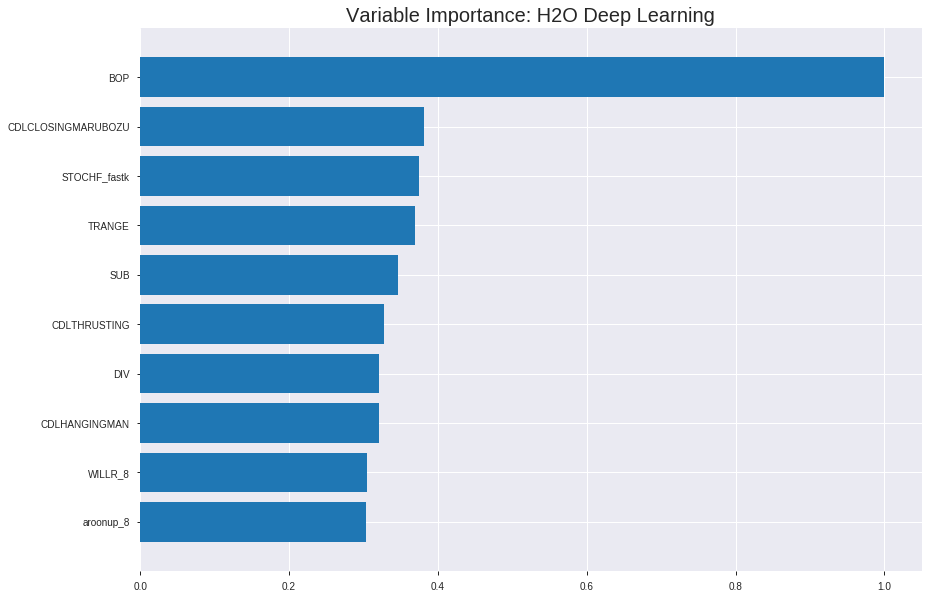

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_053237_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21665734928069263
RMSE: 0.4654646595400049
LogLoss: 0.6340393809898227
Mean Per-Class Error: 0.33401453605478715
AUC: 0.7276084329260105
pr_auc: 0.7030631580240678
Gini: 0.45521686585202104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14074417309957904: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      631  1657  0.7242   (1657.0/2288.0)
1      137  1894  0.0675   (137.0/2031.0)
Total  768  3551  0.4154   (1794.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.140744     0.67861   337
max f2                       0.0504457    0.823908  376
max f0point5                 0.555938     0.648479  163
max accuracy                 0.499999     0.667053  187
max precision                0.961729     0.945455  9
max recall                   0.00628005   1         396
max specificity              0.993745     0.999563  0
max absolute_mcc             0.4465       0.331649  207
max min_per_class_accuracy   0.439086     0.66519   210
max mean_per_class_accuracy  0.4465       0.665985  207

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 44.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.964624           1.98155   1.98155            0.931818         0.980692   0.931818                    0.980692            0.0201871       0.0201871                  98.1547   98.1547
    2        0.0201436                   0.945648           1.97818   1.97988            0.930233         0.955799   0.931034                    0.968389            0.0196947       0.0398818                  97.8175   97.9881
    3        0.0300996                   0.927822           1.92872   1.96296            0.906977         0.936254   0.923077                    0.95776             0.0192024       0.0590842                  92.8721   96.2959
    4        0.0400556                   0.913674           1.82981   1.92986            0.860465         0.920736   0.907514                    0.948557            0.0182176       0.0773018                  82.9812   92.9865
    5        0.0500116                   0.901764           1.92872   1.92964            0.906977         0.908313   0.907407                    0.940546            0.0192024       0.0965042                  92.8721   92.9637
    6        0.100023                    0.830855           1.7032    1.81642            0.800926         0.864147   0.854167                    0.902347            0.0851797       0.181684                   70.32     81.6418
    7        0.150035                    0.770159           1.5063    1.71305            0.708333         0.802177   0.805556                    0.868957            0.0753323       0.257016                   50.6298   71.3045
    8        0.200046                    0.71726            1.34878   1.62198            0.634259         0.743447   0.762731                    0.837579            0.0674545       0.324471                   34.8777   62.1978
    9        0.300069                    0.605815           1.31924   1.52107            0.62037          0.663227   0.715278                    0.779462            0.131955        0.456425                   31.9242   52.1066
    10       0.400093                    0.512108           1.13711   1.42508            0.534722         0.557504   0.670139                    0.723972            0.113737        0.570162                   13.7107   42.5076
    11       0.500116                    0.427851           1.0485    1.34976            0.493056         0.467777   0.634722                    0.672733            0.104874        0.675037                   4.85017   34.9761
    12       0.599907                    0.343089           0.863444  1.26886            0.406032         0.384925   0.596681                    0.624858            0.0861645       0.761201                   -13.6556  26.8865
    13       0.699931                    0.255633           0.767917  1.19728            0.361111         0.3017     0.563017                    0.578677            0.0768095       0.838011                   -23.2083  19.7277
    14       0.799954                    0.157935           0.762994  1.14298            0.358796         0.206305   0.537482                    0.532117            0.0763171       0.914328                   -23.7006  14.2976
    15       0.899977                    0.0723928          0.571015  1.07941            0.268519         0.114427   0.507589                    0.485695            0.0571147       0.971443                   -42.8985  7.94085
    16       1                           4.18347e-07        0.285508  1                  0.134259         0.0308343  0.470248                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20509612760880103
RMSE: 0.4528753996507218
LogLoss: 0.5994884910460645
Mean Per-Class Error: 0.29641201264488937
AUC: 0.767590885142255
pr_auc: 0.7361087287639079
Gini: 0.5351817702845101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.361975121613784: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      269  381  0.5862   (381.0/650.0)
1      45   539  0.0771   (45.0/584.0)
Total  314  920  0.3452   (426.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361975     0.716755  274
max f2                       0.189608     0.83528   338
max f0point5                 0.665592     0.680259  149
max accuracy                 0.555181     0.699352  196
max precision                0.997805     1         0
max recall                   0.0779094    1         376
max specificity              0.997805     1         0
max absolute_mcc             0.507637     0.41238   214
max min_per_class_accuracy   0.59924      0.689231  177
max mean_per_class_accuracy  0.507637     0.703588  214

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 56.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.981094           2.11301   2.11301            1                0.987778   1                           0.987778            0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.969807           1.93693   2.02849            0.916667         0.974489   0.96                        0.981399            0.0188356       0.0410959                  93.6929   102.849
    3        0.0299838                   0.963362           1.76084   1.94169            0.833333         0.967117   0.918919                    0.976767            0.0171233       0.0582192                  76.0845   94.1688
    4        0.0405186                   0.952156           1.95047   1.94397            0.923077         0.95695    0.92                        0.971615            0.0205479       0.0787671                  95.0474   94.3973
    5        0.0502431                   0.943346           1.93693   1.94261            0.916667         0.948041   0.919355                    0.967052            0.0188356       0.0976027                  93.6929   94.2609
    6        0.100486                    0.901145           1.63588   1.78925            0.774194         0.921422   0.846774                    0.944237            0.0821918       0.179795                   63.5882   78.9245
    7        0.149919                    0.863846           1.69734   1.75894            0.803279         0.8809     0.832432                    0.923353            0.0839041       0.263699                   69.7339   75.8941
    8        0.200162                    0.829836           1.53364   1.70239            0.725806         0.847228   0.805668                    0.904244            0.0770548       0.340753                   53.3639   70.2388
    9        0.299838                    0.745572           1.18535   1.53051            0.560976         0.793881   0.724324                    0.867556            0.118151        0.458904                   18.5349   53.0507
    10       0.400324                    0.669916           1.34619   1.48424            0.637097         0.712819   0.702429                    0.828715            0.135274        0.594178                   34.6194   48.4242
    11       0.5                         0.591922           1.03074   1.39384            0.487805         0.635483   0.659643                    0.790194            0.10274         0.696918                   3.07384   39.3836
    12       0.599676                    0.494259           1.13381   1.35062            0.536585         0.539704   0.639189                    0.748558            0.113014        0.809932                   13.3812   35.0616
    13       0.700162                    0.394286           0.732739  1.26194            0.346774         0.445751   0.597222                    0.7051              0.0736301       0.883562                   -26.7261  26.1939
    14       0.799838                    0.305582           0.566906  1.17532            0.268293         0.355424   0.556231                    0.661523            0.0565068       0.940068                   -43.3094  17.5324
    15       0.899514                    0.171988           0.429474  1.09268            0.203252         0.235947   0.517117                    0.614365            0.0428082       0.982877                   -57.0526  9.26756
    16       1                           0.00222385         0.170404  1                  0.0806452        0.0974238  0.473258                   


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:36:55  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:36:57  4 min 14.818 sec   407 obs/sec       0.19912   1             860        0.707499         9.49818             -1.00933       0.572491        0.0853604          1.32727          0.50382                          0.716279           14.7203               -1.05811         0.532441          0.0431175            1.16287            0.509724
    2019-07-25 05:37:30  4 min 47.658 sec   431 obs/sec       3.1799    16            13734      0.478978         0.66287             0.0790601      0.725349        0.677988           1.83656          0.371382                         0.461858           0.618422              0.144302         0.742358          0.693854             1.95047            0.354133
    2019-07-25 05:38:03  5 min 20.351 sec   458 obs/sec       6.51308   33            28130      0.560242         1.04808             -0.259944      0.702438        0.65891            1.83656          0.391294                         0.634397           1.78047               -0.614458        0.697209          0.6617               1.78793            0.375203
    2019-07-25 05:38:35  5 min 52.047 sec   482 obs/sec       10.0368   51            43349      0.45335          0.607764            0.174972       0.759685        0.724689           1.98155          0.333179                         0.453541           0.610133              0.174841         0.762026          0.724662             2.11301            0.311994
    2019-07-25 05:39:07  6 min 24.201 sec   502 obs/sec       13.825    70            59710      0.466704         0.645511            0.125654       0.742852        0.699666           1.83656          0.353323                         0.494356           0.75289               0.0196426        0.760055          0.707583             2.11301            0.329822
    2019-07-25 05:39:39  6 min 56.782 sec   523 obs/sec       17.9551   91            77548      0.470112         0.655156            0.112836       0.730203        0.676388           1.78823          0.355638                         0.505669           0.765253              -0.0257384       0.71667           0.673105             1.95047            0.350081
    2019-07-25 05:40:13  7 min 30.337 sec   543 obs/sec       22.483    114           97104      0.465465         0.634039            0.130291       0.727608        0.703063           1.98155          0.415374                         0.452875           0.599488              0.177262         0.767591          0.736109             2.11301            0.345219
    2019-07-25 05:40:46  8 min  3.362 sec   562 obs/sec       27.1565   138           117289     0.46946          0.66491             0.115298       0.737635        0.689475           1.98155          0.355638                         0.496353           0.776449              0.011709         0.764476          0.720889             2.11301            0.298217
    2019-07-

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.007914697700736066
CDLCLOSINGMARUBOZU        0.3812324106693268     0.3812324106693268   0.0030173392841705885
STOCHF_fastk              0.3742140829563141     0.3742140829563141   0.0029617913419573948
TRANGE                    0.3697448968887329     0.3697448968887329   0.0029264190852641486
SUB                       0.3466775119304657     0.3466775119304657   0.002743847706572957
---                       ---                    ---                  ---
BBANDS_middleband_8_7_5   0.09341363608837128    0.09341363608837128  0.0007393406907660278
BBANDS_upperband_8_0_4    0.0927463099360466     0.0927463099360466   0.0007340590060025827
BBANDS_middleband_14_6_3  0.09180580824613571    0.09180580824613571  0.0007266152194399066
CDLDOJISTAR               0.08797158300876617    0.08797158300876617  0.0006962684857695937
CDLRISEFALL3METHODS       0.06382326036691666    0.06382326036691666  0.0005051418120795146


See the whole table with table.as_data_frame()


('accuracy', 0.7244732576985413)

('F1', 0.7581047381546134)

('auc', 0.7889409411517002)

('logloss', 0.5694323128651777)

('mean_per_class_error', 0.2790398989367302)

('rmse', 0.4379410108024131)

('mse', 0.1917923289426393)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


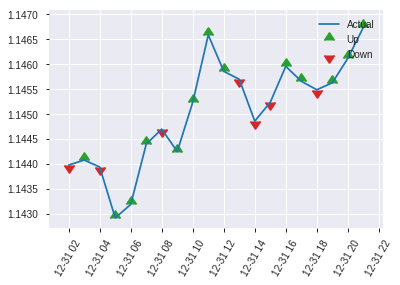


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1917923289426393
RMSE: 0.4379410108024131
LogLoss: 0.5694323128651777
Mean Per-Class Error: 0.2790398989367302
AUC: 0.7889409411517002
pr_auc: 0.782798466410952
Gini: 0.5778818823034004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32364196324596073: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  176  0.5966   (176.0/295.0)
1      18   304  0.0559   (18.0/322.0)
Total  137  480  0.3144   (194.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323642     0.758105  304
max f2                       0.323642     0.859729  304
max f0point5                 0.7436       0.739095  135
max accuracy                 0.549137     0.724473  220
max precision                0.996342     1         0
max recall                   0.0552269    1         386
max specificity              0.996342     1         0
max absolute_mcc             0.549137     0.44882   220
max min_per_class_accuracy   0.632045     0.711864  187
max mean_per_class_accuracy  0.549137     0.72096   220

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 58.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.981687           1.91615   1.91615            1                0.985904   1                           0.985904            0.0217391       0.0217391                  91.6149   91.6149
    2        0.0210697                   0.969441           1.59679   1.76875            0.833333         0.973676   0.923077                    0.98026             0.015528        0.0372671                  59.6791   76.8753
    3        0.0307942                   0.962581           1.59679   1.71445            0.833333         0.966205   0.894737                    0.975822            0.015528        0.052795                   59.6791   71.4449
    4        0.0405186                   0.956104           1.59679   1.68621            0.833333         0.958814   0.88                        0.97174             0.015528        0.068323                   59.6791   68.6211
    5        0.0502431                   0.950086           1.27743   1.60709            0.666667         0.953426   0.83871                     0.968195            0.0124224       0.0807453                  27.7433   60.7093
    6        0.100486                    0.916247           1.60709   1.60709            0.83871          0.930626   0.83871                     0.949411            0.0807453       0.161491                   60.7093   60.7093
    7        0.150729                    0.88216            1.73072   1.6483             0.903226         0.900335   0.860215                    0.933052            0.0869565       0.248447                   73.0715   64.83
    8        0.200972                    0.850151           1.6689    1.65345            0.870968         0.866138   0.862903                    0.916324            0.0838509       0.332298                   66.8904   65.3451
    9        0.299838                    0.790571           1.47638   1.59506            0.770492         0.819473   0.832432                    0.884389            0.145963        0.478261                   47.6377   59.5065
    10       0.400324                    0.717707           1.17441   1.48948            0.612903         0.758736   0.777328                    0.852849            0.118012        0.596273                   17.4414   48.9476
    11       0.50081                     0.639274           1.0817    1.40766            0.564516         0.682583   0.734628                    0.818685            0.108696        0.704969                   8.16971   40.7656
    12       0.599676                    0.53876            1.00519   1.3413             0.52459          0.593439   0.7                         0.78155             0.0993789       0.804348                   0.519295  34.1304
    13       0.700162                    0.413256           0.679924  1.24638            0.354839         0.470197   0.650463                    0.736865            0.068323        0.872671                   -32.0076  24.6384
    14       0.799028                    0.295084           0.722482  1.18156            0.377049         0.351744   0.616633                    0.689213            0.0714286       0.944099                   -27.7518  18.156
    15       0.899514                    0.177641           0.370868  1.091              0.193548         0.238936   0.569369                    0.638912            0.0372671       0.981366                   -62.9132  9.09966
    16       1                           0.00138477         0.185434  1                  0.0967742        0.0901051  0.52188                     0.

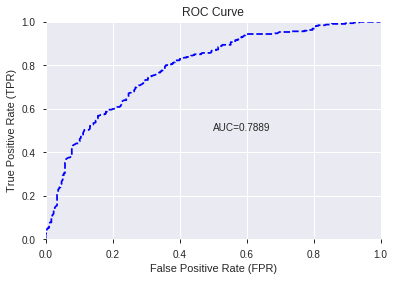

This function is available for GLM models only


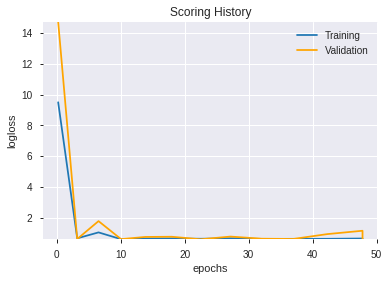

--2019-07-25 06:32:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_053237_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_053237_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_063348_model_6  0.774355  0.589778              0.279619  0.446122  0.199025
1  DeepLearning_grid_1_AutoML_20190725_063348_model_8  0.773818  0.590272              0.294447  0.448465  0.201121
2               DeepLearning_1_AutoML_20190725_063348  0.773413  0.579291              0.296010  0.441583  0.194996
3  DeepLearning_grid_1_AutoML_20190725_063348_model_9  0.772434  0.581406              0.315791  0.443814  0.196971
4  DeepLearning_grid_1_AutoML_20190725_063348_model_5  0.771965  0.592287              0.292478  0.445292  0.198285
5  DeepLearning_grid_1_AutoML_20190725_063348_model_7  0.761333  0.659094              0.287657  0.464550  0.215807
6  DeepLearning_grid_1_AutoML_20190725_063348_model_4  0.743094  0.660635              0.379935  0.463330  0.214675
7  DeepLearning_grid_1_AutoML_20190725_063348_model_3  0.740889  0.677702              0.311396  0.462454  0.213864
8  DeepLearning_grid_1_AutoML_20190725_063348_model_2  0.720723  0.676960              0.336546  0.474351  0.225009
9  DeepLearning_grid_1_AutoML_20190725_063348_model_1  0.699679  0.928063              0.392915  0.499782  0.249782

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.045394
1    CDLCLOSINGMARUBOZU             0.733760           0.733760    0.033309
2           CDLLONGLINE             0.704218           0.704218    0.031968
3          CDLSHORTLINE             0.556396           0.556396    0.025257
4          STOCHF_fastk             0.510330           0.510330    0.023166
5         CDLHANGINGMAN             0.503833           0.503833    0.022871
6               WILLR_8             0.498909           0.498909    0.022648
7             CORREL_24             0.493551           0.493551    0.022404
8                 CCI_8             0.491760           0.491760    0.022323
9                TRANGE             0.486437           0.486437    0.022082
10               ULTOSC             0.461650           0.461650    0.020956
11                  DIV             0.461165           0.461165    0.020934
12                  SUB             0.459554           0.459554    0.020861
13         weekday_name             0.440594           0.440594    0.020001
14       STOCHRSI_fastk             0.432893           0.432893    0.019651
15            CDLTAKURI             0.430813           0.430813    0.019557
16            CORREL_30             0.429954           0.429954    0.019518
17   CDLEVENINGDOJISTAR             0.426060           0.426060    0.019341
18         CDLTHRUSTING             0.423483           0.423483    0.019224
19     CDLDRAGONFLYDOJI             0.423473           0.423473    0.019223
20         HT_TRENDMODE             0.420551           0.420551    0.019091
21     is_quarter_start             0.418533           0.418533    0.018999
22       CDLMORNINGSTAR             0.410330           0.410330    0.018627
23          CDLPIERCING             0.409509           0.409509    0.018589
24             WILLR_12             0.408351           0.408351    0.018537
25                 hour             0.407106           0.407106    0.018480
26  CDLGAPSIDESIDEWHITE             0.406817           0.406817    0.018467
27          STOCH_slowd             0.405697           0.405697    0.018416
28    CDLDARKCLOUDCOVER             0.404696           0.404696    0.018371
29    CDLSTALLEDPATTERN             0.403537           0.403537    0.018318
30       STOCHRSI_fastd             0.402753           0.402753    0.018283
31   CDLIDENTICAL3CROWS             0.399929           0.399929    0.018155
32      CDLUNIQUE3RIVER             0.397211           0.397211    0.018031
33         CDLENGULFING             0.393395           0.393395    0.017858
34      CDLHOMINGPIGEON             0.387636           0.387636    0.017597
35       CDLEVENINGSTAR             0.385698           0.385698    0.017509
36    CDL3WHITESOLDIERS             0.384445           0.384445    0.017452
37                  day             0.383879           0.383879    0.017426
38               MFI_20             0.382532           0.382532    0.017365
39           AROONOSC_8             0.381733           0.381733    0.017329
40               SAREXT             0.379724           0.379724    0.017237
41            CDLONNECK             0.379681           0.379681    0.017235
42         is_month_end             0.375249           0.375249    0.017034
43             CORREL_8             0.374737           0.374737    0.017011
44            aroonup_8             0.369227           0.369227    0.016761
45       CDL3BLACKCROWS             0.367123           0.367123    0.016665
46            PLUS_DM_8             0.364841           0.364841    0.016562
47            PLUS_DI_8             0.357081           0.357081    0.016209
48       is_month_start             0.356343           0.356343    0.016176
49   CDLSEPARATINGLINES             0.341936           0.341936    0.015522

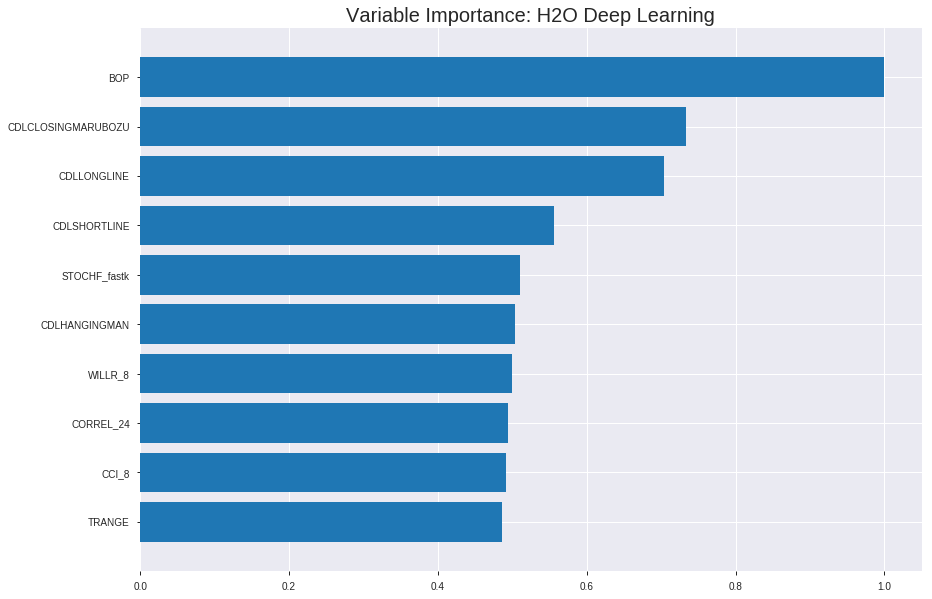

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_063348_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19373884075638131
RMSE: 0.4401577453099983
LogLoss: 0.5693771351881123
Mean Per-Class Error: 0.2910429212589478
AUC: 0.773707167401776
pr_auc: 0.7414966707938536
Gini: 0.5474143348035521
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3580018145483808: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1100  1188  0.5192   (1188.0/2288.0)
1      273   1758  0.1344   (273.0/2031.0)
Total  1373  2946  0.3383   (1461.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358002     0.70645   260
max f2                       0.114686     0.829123  364
max f0point5                 0.521306     0.697555  178
max accuracy                 0.496881     0.709655  191
max precision                0.993446     1         0
max recall                   0.0369575    1         397
max specificity              0.993446     1         0
max absolute_mcc             0.450036     0.417464  216
max min_per_class_accuracy   0.464047     0.706731  208
max mean_per_class_accuracy  0.450036     0.708957  216

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 46.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.954981           2.07821   2.07821            0.977273         0.9703     0.977273                    0.9703              0.0211718       0.0211718                  107.821   107.821
    2        0.0201436                   0.923111           1.78036   1.93099            0.837209         0.941378   0.908046                    0.956005            0.0177253       0.0388971                  78.0358   93.0995
    3        0.0300996                   0.893988           1.87927   1.91388            0.883721         0.903939   0.9                         0.938783            0.01871         0.0576071                  87.9267   91.3885
    4        0.0400556                   0.876321           1.82981   1.89299            0.860465         0.884204   0.890173                    0.925217            0.0182176       0.0758247                  82.9812   89.2988
    5        0.0500116                   0.863319           1.92872   1.9001             0.906977         0.869601   0.893519                    0.914145            0.0192024       0.0950271                  92.8721   90.0102
    6        0.100023                    0.779665           1.78196   1.84103            0.837963         0.822978   0.865741                    0.868562            0.0891187       0.184146                   78.1961   84.1031
    7        0.150035                    0.72019            1.56537   1.74914            0.736111         0.746598   0.822531                    0.827907            0.0782866       0.262432                   56.5369   74.9144
    8        0.200046                    0.674164           1.58506   1.70812            0.74537          0.696689   0.803241                    0.795103            0.0792713       0.341704                   58.5059   70.8122
    9        0.300069                    0.585224           1.38816   1.60147            0.652778         0.630208   0.753086                    0.740138            0.138848        0.480551                   38.8157   60.1467
    10       0.400093                    0.515887           1.31924   1.53091            0.62037          0.548973   0.719907                    0.692347            0.131955        0.612506                   31.9242   53.0911
    11       0.500116                    0.456802           1.07311   1.43935            0.50463          0.486536   0.676852                    0.651185            0.107336        0.719842                   7.31144   43.9352
    12       0.599907                    0.404688           0.80917   1.33452            0.38051          0.43146    0.627557                    0.614634            0.0807484       0.800591                   -19.083   33.4524
    13       0.699931                    0.346585           0.767917  1.25355            0.361111         0.377064   0.589481                    0.580685            0.0768095       0.8774                     -23.2083  25.3553
    14       0.799954                    0.255879           0.639931  1.17683            0.300926         0.30461    0.553401                    0.546165            0.0640079       0.941408                   -36.0069  17.6828
    15       0.899977                    0.126772           0.369191  1.08707            0.173611         0.187514   0.511191                    0.506305            0.0369276       0.978336                   -63.0809  8.70677
    16       1                           0.0218199          0.216592  1                  0.101852         0.0871048  0.470248                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19746915975434867
RMSE: 0.44437502152387987
LogLoss: 0.5807101734112045
Mean Per-Class Error: 0.29192307692307695
AUC: 0.7655084299262381
pr_auc: 0.7195941643129826
Gini: 0.5310168598524763
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33796845003849424: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      281  369  0.5677   (369.0/650.0)
1      52   532  0.089    (52.0/584.0)
Total  333  901  0.3412   (421.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337968     0.716498  275
max f2                       0.203607     0.83579   329
max f0point5                 0.521214     0.689858  175
max accuracy                 0.45035      0.705835  212
max precision                0.984697     1         0
max recall                   0.0635341    1         392
max specificity              0.984697     1         0
max absolute_mcc             0.45035      0.416349  212
max min_per_class_accuracy   0.473118     0.7       200
max mean_per_class_accuracy  0.45035      0.708077  212

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.949537           1.6254    1.6254             0.769231         0.965364   0.769231                    0.965364            0.0171233       0.0171233                  62.5395   62.5395
    2        0.0202593                   0.89992            1.93693   1.77493            0.916667         0.937903   0.84                        0.952183            0.0188356       0.0359589                  93.6929   77.4932
    3        0.0299838                   0.876352           1.93693   1.82747            0.916667         0.883551   0.864865                    0.929924            0.0188356       0.0547945                  93.6929   82.7471
    4        0.0405186                   0.857752           1.95047   1.85945            0.923077         0.866181   0.88                        0.913351            0.0205479       0.0753425                  95.0474   85.9452
    5        0.0502431                   0.846752           1.76084   1.84037            0.833333         0.852305   0.870968                    0.901535            0.0171233       0.0924658                  76.0845   84.0367
    6        0.100486                    0.759023           1.73812   1.78925            0.822581         0.805395   0.846774                    0.853465            0.0873288       0.179795                   73.8124   78.9245
    7        0.149919                    0.709762           1.35094   1.64472            0.639344         0.730771   0.778378                    0.813009            0.0667808       0.246575                   35.0943   64.4724
    8        0.200162                    0.661429           1.6018    1.63395            0.758065         0.687618   0.773279                    0.781534            0.0804795       0.327055                   60.1801   63.395
    9        0.299838                    0.595354           1.40868   1.55906            0.666667         0.631545   0.737838                    0.731673            0.140411        0.467466                   40.8676   55.9061
    10       0.400324                    0.518722           1.34619   1.50563            0.637097         0.554971   0.712551                    0.687319            0.135274        0.60274                    34.6194   50.5629
    11       0.5                         0.468502           1.09945   1.42466            0.520325         0.492277   0.67423                     0.648437            0.109589        0.712329                   9.94543   42.4658
    12       0.599676                    0.41313            0.893307  1.33634            0.422764         0.439198   0.632432                    0.613658            0.0890411       0.80137                    -10.6693  33.6338
    13       0.700162                    0.363421           0.834981  1.26438            0.395161         0.388868   0.59838                     0.581396            0.0839041       0.885274                   -16.5019  26.4384
    14       0.799838                    0.273001           0.532548  1.17318            0.252033         0.319652   0.555218                    0.548778            0.0530822       0.938356                   -46.7452  17.3183
    15       0.899514                    0.138621           0.360758  1.08316            0.170732         0.210317   0.512613                    0.511273            0.0359589       0.974315                   -63.9242  8.31575
    16       1                           0.0423933          0.255606  1                  0.120968         0.0978313  0.473258                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:40:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:40:08  4 min 14.400 sec  808 obs/sec       0.526974  1             2276       0.484758         0.778187            0.0566988      0.746647        0.69678            1.93322          0.349386                         0.488549           0.766474              0.0425412        0.745167          0.686168             1.95047            0.329822
    2019-07-25 06:40:25  4 min 31.773 sec  2182 obs/sec      9.33318   18            40310      0.440158         0.569377            0.222291       0.773707        0.741497           2.07821          0.338273                         0.444375           0.58071               0.207857         0.765508          0.719594             1.6254             0.341167
    2019-07-25 06:40:43  4 min 49.387 sec  2541 obs/sec      20.2623   39            87513      0.4403           0.573113            0.221787       0.777843        0.74591            1.93322          0.305163                         0.445581           0.584944              0.203553         0.767458          0.723141             1.6254             0.311183
    2019-07-25 06:41:00  5 min  6.686 sec  2740 obs/sec      31.733    61            137055     0.438002         0.567375            0.229889       0.782189        0.750794           1.93322          0.315351                         0.444992           0.581227              0.205655         0.768529          0.734615             2.11301            0.311183
    2019-07-25 06:41:17  5 min 23.862 sec  2879 obs/sec      43.7219   84            188835     0.435223         0.563284            0.239632       0.787376        0.755638           1.93322          0.305858                         0.445258           0.583248              0.204707         0.767487          0.735147             2.11301            0.294165
    2019-07-25 06:41:34  5 min 40.329 sec  2991 obs/sec      55.721    107           240659     0.430894         0.550443            0.254682       0.795591        0.767887           1.98155          0.282241                         0.44619            0.58173               0.201374         0.764091          0.728222             1.95047            0.30389
    2019-07-25 06:41:50  5 min 56.534 sec  3075 obs/sec      67.6798   130           292309     0.427699         0.543845            0.265695       0.803227        0.778319           2.02988          0.291734                         0.448205           0.585687              0.194143         0.759975          0.725959             2.11301            0.320097
    2019-07-25 06:41:51  5 min 58.181 sec  3075 obs/sec      67.6798   130           292309     0.440158         0.569377            0.222291       0.773707        0.741497           2.07821          0.338273                         0.444375           0.58071               0.207857         0.765508          0.719594             1.6254             0.341167

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04539447959827228
CDLCLOSINGMARUBOZU  0.7337595224380493     0.7337595224380493   0.03330863167135204
CDLLONGLINE         0.7042182683944702     0.7042182683944702   0.03196762181736341
CDLSHORTLINE        0.5563958287239075     0.5563958287239075   0.025257299095571215
STOCHF_fastk        0.5103297829627991     0.5103297829627991   0.023166154921095503
---                 ---                    ---                  ---
CDL3BLACKCROWS      0.3671225607395172     0.3671225607395172   0.016665337593555492
PLUS_DM_8           0.3648407459259033     0.3648407459259033   0.01656175579755186
PLUS_DI_8           0.35708069801330566    0.35708069801330566  0.01620949246090183
is_month_start      0.3563433587551117     0.3563433587551117   0.016176021328988738
CDLSEPARATINGLINES  0.341935932636261      0.341935932636261    0.015522003717972955


See the whole table with table.as_data_frame()


('accuracy', 0.7260940032414911)

('F1', 0.7642956764295676)

('auc', 0.7743551952837141)

('logloss', 0.5897781300596425)

('mean_per_class_error', 0.27830824297294454)

('rmse', 0.4461222406711973)

('mse', 0.1990250536214897)

deeplearning prediction progress: |███████████████████████████████████████| 100%


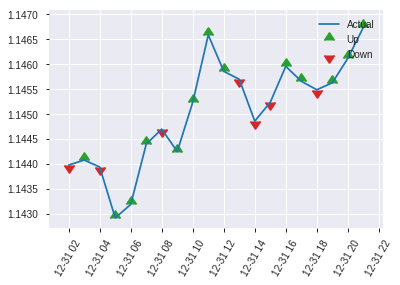


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1990250536214897
RMSE: 0.4461222406711973
LogLoss: 0.5897781300596425
Mean Per-Class Error: 0.27830824297294454
AUC: 0.7743551952837141
pr_auc: 0.7498249434712319
Gini: 0.5487103905674282
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4038797221791597: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      174  121  0.4102   (121.0/295.0)
1      48   274  0.1491   (48.0/322.0)
Total  222  395  0.2739   (169.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40388      0.764296  244
max f2                       0.126669     0.855441  361
max f0point5                 0.485175     0.739015  186
max accuracy                 0.407446     0.726094  242
max precision                0.839087     0.861111  28
max recall                   0.0774954    1         387
max specificity              0.984858     0.99661   0
max absolute_mcc             0.40388      0.458742  244
max min_per_class_accuracy   0.465294     0.720497  198
max mean_per_class_accuracy  0.470882     0.721692  195

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 47.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.939104           1.09494   1.09494            0.571429         0.962737   0.571429                    0.962737            0.0124224       0.0124224                  9.49423   9.49423
    2        0.0210697                   0.886206           1.59679   1.32656            0.833333         0.910732   0.692308                    0.938734            0.015528        0.0279503                  59.6791   32.6565
    3        0.0307942                   0.866114           1.59679   1.4119             0.833333         0.87868    0.736842                    0.91977             0.015528        0.0434783                  59.6791   41.1899
    4        0.0405186                   0.858281           1.91615   1.53292            1                0.863328   0.8                         0.906224            0.0186335       0.0621118                  91.6149   53.2919
    5        0.0502431                   0.849131           1.91615   1.60709            1                0.854865   0.83871                     0.896283            0.0186335       0.0807453                  91.6149   60.7093
    6        0.100486                    0.7552             1.60709   1.60709            0.83871          0.810453   0.83871                     0.853368            0.0807453       0.161491                   60.7093   60.7093
    7        0.150729                    0.717177           1.60709   1.60709            0.83871          0.734377   0.83871                     0.813704            0.0807453       0.242236                   60.7093   60.7093
    8        0.200972                    0.68106            1.60709   1.60709            0.83871          0.69756    0.83871                     0.784668            0.0807453       0.322981                   60.7093   60.7093
    9        0.299838                    0.591952           1.2879    1.50185            0.672131         0.637973   0.783784                    0.736298            0.127329        0.450311                   28.7903   50.1847
    10       0.400324                    0.52652            1.32894   1.45845            0.693548         0.561059   0.761134                    0.692311            0.13354         0.583851                   32.8942   45.8445
    11       0.50081                     0.469553           1.26713   1.42006            0.66129          0.498819   0.7411                      0.653487            0.127329        0.71118                    26.7131   42.0059
    12       0.599676                    0.423686           0.910956  1.33613            0.47541          0.446861   0.697297                    0.619422            0.0900621       0.801242                   -8.90439  33.6126
    13       0.700162                    0.368242           0.772641  1.25526            0.403226         0.397225   0.655093                    0.587533            0.0776398       0.878882                   -22.7359  25.5255
    14       0.799028                    0.274423           0.534009  1.16601            0.278689         0.323615   0.608519                    0.554878            0.052795        0.931677                   -46.5991  16.6014
    15       0.899514                    0.129885           0.401773  1.08064            0.209677         0.205888   0.563964                    0.515891            0.0403727       0.97205                    -59.8227  8.0639
    16       1                           0.0402346          0.278151  1                  0.145161         0.0885564  0.52188                     

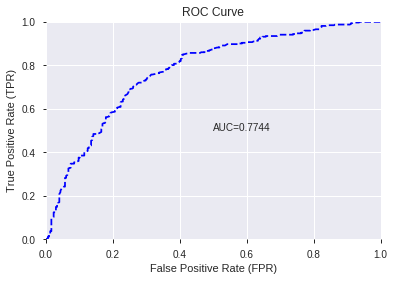

This function is available for GLM models only


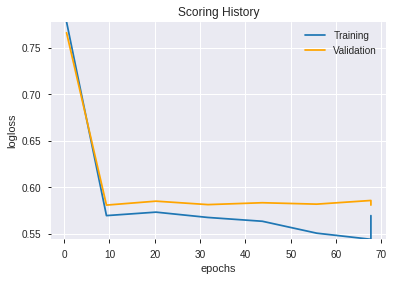

--2019-07-25 06:55:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_063348_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_063348_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'WILLR_8',
 'CORREL_24',
 'CCI_8',
 'TRANGE',
 'ULTOSC',
 'DIV',
 'SUB',
 'weekday_name',
 'STOCHRSI_fastk',
 'CDLTAKURI',
 'CORREL_30',
 'CDLEVENINGDOJISTAR',
 'CDLTHRUSTING',
 'CDLDRAGONFLYDOJI',
 'HT_TRENDMODE',
 'is_quarter_start',
 'CDLMORNINGSTAR',
 'CDLPIERCING',
 'WILLR_12',
 'hour',
 'CDLGAPSIDESIDEWHITE',
 'STOCH_slowd',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'STOCHRSI_fastd',
 'CDLIDENTICAL3CROWS',
 'CDLUNIQUE3RIVER',
 'CDLENGULFING',
 'CDLHOMINGPIGEON',
 'CDLEVENINGSTAR',
 'CDL3WHITESOLDIERS',
 'day',
 'MFI_20',
 'AROONOSC_8',
 'SAREXT',
 'CDLONNECK',
 'is_month_end',
 'CORREL_8',
 'aroonup_8',
 'CDL3BLACKCROWS',
 'PLUS_DM_8',
 'PLUS_DI_8',
 'is_month_start',
 'CDLSEPARATINGLINES']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_065625_model_1  0.781645  0.570042              0.285688  0.438941  0.192669

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.733531           1.000000    0.142621
1                 CCI_8             0.505901           0.689679    0.098363
2               WILLR_8             0.484026           0.659858    0.094110
3           STOCH_slowd             0.406062           0.553571    0.078951
4          STOCHF_fastk             0.300520           0.409690    0.058430
5                ULTOSC             0.263602           0.359361    0.051252
6         CDLHANGINGMAN             0.172073           0.234583    0.033456
7        STOCHRSI_fastk             0.151828           0.206983    0.029520
8                TRANGE             0.149604           0.203950    0.029088
9    CDLCLOSINGMARUBOZU             0.141218           0.192519    0.027457
10            CORREL_30             0.120742           0.164604    0.023476
11         CDLTHRUSTING             0.117464           0.160135    0.022839
12     CDLDRAGONFLYDOJI             0.101234           0.138009    0.019683
13                  SUB             0.099027           0.135000    0.019254
14      CDLHOMINGPIGEON             0.094694           0.129094    0.018411
15               MFI_20             0.092068           0.125514    0.017901
16    CDLDARKCLOUDCOVER             0.082124           0.111958    0.015967
17            PLUS_DI_8             0.078268           0.106700    0.015218
18            CDLTAKURI             0.077985           0.106314    0.015163
19            CDLONNECK             0.076791           0.104687    0.014931
20                  DIV             0.074207           0.101164    0.014428
21   CDLIDENTICAL3CROWS             0.062607           0.085351    0.012173
22       STOCHRSI_fastd             0.058857           0.080238    0.011444
23         CDLENGULFING             0.057518           0.078413    0.011183
24      CDLUNIQUE3RIVER             0.055835           0.076118    0.010856
25       CDL3BLACKCROWS             0.050243           0.068494    0.009769
26                 hour             0.046887           0.063920    0.009116
27         is_month_end             0.039765           0.054210    0.007731
28       is_month_start             0.036741           0.050088    0.007144
29               SAREXT             0.035697           0.048665    0.006941
30       CDLEVENINGSTAR             0.033770           0.046037    0.006566
31   CDLSEPARATINGLINES             0.031377           0.042775    0.006101
32          CDLLONGLINE             0.031256           0.042610    0.006077
33         CDLSHORTLINE             0.025369           0.034584    0.004932
34  CDLGAPSIDESIDEWHITE             0.025016           0.034103    0.004864
35    CDLSTALLEDPATTERN             0.024488           0.033384    0.004761
36   CDLEVENINGDOJISTAR             0.024453           0.033336    0.004754
37    CDL3WHITESOLDIERS             0.022512           0.030689    0.004377
38            CORREL_24             0.022290           0.030387    0.004334
39         weekday_name             0.021699           0.029581    0.004219
40             WILLR_12             0.019331           0.026353    0.003758
41     is_quarter_start             0.019168           0.026131    0.003727
42          CDLPIERCING             0.018586           0.025337    0.003614
43       CDLMORNINGSTAR             0.016837           0.022953    0.003274
44             CORREL_8             0.013486           0.018385    0.002622
45         HT_TRENDMODE             0.010456           0.014254    0.002033
46            PLUS_DM_8             0.008476           0.011556    0.001648
47            aroonup_8             0.005073           0.006915    0.000986
48           AROONOSC_8             0.001436           0.001957    0.000279
49                  day             0.001027           0.001400    0.000200

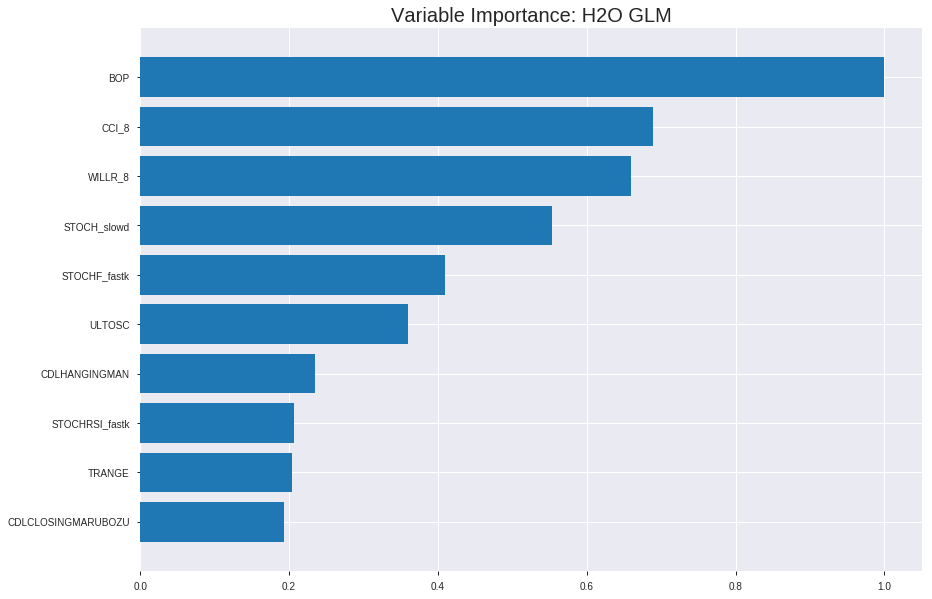

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_065625_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19199761481842606
RMSE: 0.4381753242920305
LogLoss: 0.565616638981544
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5972.1036478564565
Residual deviance: 4885.796527522577
AIC: 4987.796527522577
AUC: 0.7770227987177766
pr_auc: 0.7445277244551093
Gini: 0.5540455974355531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37532677138925885: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1288  1000  0.4371   (1000.0/2288.0)
1      344   1687  0.1694   (344.0/2031.0)
Total  1632  2687  0.3112   (1344.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375327     0.715134  247
max f2                       0.128153     0.82721   359
max f0point5                 0.514801     0.696427  182
max accuracy                 0.510313     0.711276  184
max precision                0.990029     1         0
max recall                   0.0406149    1         391
max specificity              0.990029     1         0
max absolute_mcc             0.510313     0.419232  184
max min_per_class_accuracy   0.480185     0.70542   199
max mean_per_class_accuracy  0.496636     0.708618  191

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.920339           1.98155   1.98155            0.931818         0.948181   0.931818                    0.948181            0.0201871       0.0201871                  98.1547   98.1547
    2        0.0201436                   0.89438            1.87927   1.93099            0.883721         0.907346   0.908046                    0.927998            0.01871         0.0388971                  87.9267   93.0995
    3        0.0300996                   0.873879           1.7309    1.86481            0.813953         0.885112   0.876923                    0.913813            0.0172329       0.05613                    73.0904   86.4811
    4        0.0400556                   0.858338           2.02763   1.90528            0.953488         0.86512    0.895954                    0.90171             0.0201871       0.0763171                  102.763   90.528
    5        0.0500116                   0.846486           1.87927   1.9001             0.883721         0.85246    0.893519                    0.891906            0.01871         0.0950271                  87.9267   90.0102
    6        0.100023                    0.791535           1.77212   1.83611            0.833333         0.81716    0.863426                    0.854533            0.0886263       0.183653                   77.2116   83.6109
    7        0.150035                    0.74204            1.60475   1.75899            0.75463          0.763645   0.82716                     0.824237            0.080256        0.263909                   60.4749   75.8989
    8        0.200046                    0.698267           1.53583   1.7032             0.722222         0.720359   0.800926                    0.798267            0.0768095       0.340719                   53.5833   70.32
    9        0.300069                    0.619977           1.46692   1.62444            0.689815         0.658049   0.763889                    0.751528            0.146726        0.487445                   46.6918   62.4439
    10       0.400093                    0.543681           1.23064   1.52599            0.578704         0.584332   0.717593                    0.709729            0.123092        0.610537                   23.0636   52.5988
    11       0.500116                    0.470533           1.08788   1.43837            0.511574         0.505615   0.676389                    0.668906            0.108813        0.71935                    8.7882    43.8367
    12       0.599907                    0.389696           0.927585  1.3534             0.436195         0.429967   0.636434                    0.62916             0.0925652       0.811915                   -7.24147  35.3401
    13       0.699931                    0.314923           0.723614  1.2634             0.340278         0.352461   0.594112                    0.589618            0.0723781       0.884293                   -27.6386  26.3402
    14       0.799954                    0.239877           0.531635  1.1719             0.25             0.278384   0.551085                    0.550703            0.0531758       0.937469                   -46.8365  17.1904
    15       0.899977                    0.153083           0.403649  1.08652            0.189815         0.198648   0.510934                    0.511575            0.0403742       0.977843                   -59.6351  8.65206
    16       1                           0.00277609         0.221514  1                  0.104167         0.0983944  0.470248                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19292099717648428
RMSE: 0.4392277281507672
LogLoss: 0.5668015548301358
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1707.2004406915303
Residual deviance: 1398.8662373207756
AIC: 1500.8662373207756
AUC: 0.7747286617492097
pr_auc: 0.7396099480996531
Gini: 0.5494573234984195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3498199667766436: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      340  310  0.4769   (310.0/650.0)
1      79   505  0.1353   (79.0/584.0)
Total  419  815  0.3152   (389.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34982      0.721944  258
max f2                       0.240862     0.833837  311
max f0point5                 0.526772     0.698198  175
max accuracy                 0.460255     0.713128  206
max precision                0.979227     1         0
max recall                   0.0889016    1         380
max specificity              0.979227     1         0
max absolute_mcc             0.452055     0.428939  210
max min_per_class_accuracy   0.473087     0.707192  201
max mean_per_class_accuracy  0.452055     0.714652  210

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.905512           2.11301   2.11301            1                0.939929  1                           0.939929            0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.884171           1.76084   1.94397            0.833333         0.895525  0.92                        0.918615            0.0171233       0.0393836                  76.0845   94.3973
    3        0.0299838                   0.867117           1.93693   1.94169            0.916667         0.875046  0.918919                    0.904485            0.0188356       0.0582192                  93.6929   94.1688
    4        0.0405186                   0.855201           1.78793   1.90171            0.846154         0.860095  0.9                         0.892943            0.0188356       0.0770548                  78.7935   90.1712
    5        0.0502431                   0.833072           2.11301   1.94261            1                0.840626  0.919355                    0.882817            0.0205479       0.0976027                  111.301   94.2609
    6        0.100486                    0.778364           1.63588   1.78925            0.774194         0.801257  0.846774                    0.842037            0.0821918       0.179795                   63.5882   78.9245
    7        0.149919                    0.734119           1.69734   1.75894            0.803279         0.756537  0.832432                    0.813845            0.0839041       0.263699                   69.7339   75.8941
    8        0.200162                    0.699733           1.39732   1.66817            0.66129          0.716202  0.789474                    0.789336            0.0702055       0.333904                   39.7316   66.8169
    9        0.299838                    0.621199           1.40868   1.5819             0.666667         0.658609  0.748649                    0.745878            0.140411        0.474315                   40.8676   58.1905
    10       0.400324                    0.542181           1.27803   1.50563            0.604839         0.582371  0.712551                    0.704836            0.128425        0.60274                    27.8032   50.5629
    11       0.5                         0.465737           1.21971   1.44863            0.577236         0.502856  0.685575                    0.664571            0.121575        0.724315                   21.9707   44.863
    12       0.599676                    0.397604           0.824591  1.3449             0.390244         0.429097  0.636486                    0.625431            0.0821918       0.806507                   -17.5409  34.4905
    13       0.700162                    0.314287           0.715698  1.2546             0.33871          0.355958  0.59375                     0.586757            0.0719178       0.878425                   -28.4302  25.4602
    14       0.799838                    0.228919           0.66998   1.18175            0.317073         0.270227  0.559271                    0.547311            0.0667808       0.945205                   -33.002   18.1746
    15       0.899514                    0.156194           0.360758  1.09077            0.170732         0.194564  0.516216                    0.508223            0.0359589       0.981164                   -63.9242  9.07719
    16       1                           0.0182096          0.187445  1                  0.0887097        0.102918  0.473258                    0.467495          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 06:56:26  0.000 sec   2            .2E2      51            1.3671230904540999  1.3678871826887853
     2019-07-25 06:56:26  0.048 sec   4            .12E2     51            1.3587508786676405  1.359529281333527
     2019-07-25 06:56:26  0.095 sec   6            .77E1     51            1.3467362234179212  1.3475205237147314
     2019-07-25 06:56:26  0.150 sec   8            .48E1     51            1.330372515192224   1.3311385187547697
     2019-07-25 06:56:26  0.202 sec   10           .3E1      51            1.3094955881521064  1.3101912357416945
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 06:56:27  0.719 sec   40           .24E-2    51            1.1305379167713154  1.1337270747958248
     2019-07-25 06:56:27  0.744 sec   41           .15E-2    51            1.1301626018606754  1.1340856175804257
     2019-07-25 06:56:27  0.765 sec   42           .91E-3    51            1.1299660349733074  1.1346243813306787
     2019-07-25 06:56:27  0.789 sec   43           .56E-3    51            1.1298713680918913  1.1352418734304157
     2019-07-25 06:56:27  0.811 sec   44           .35E-3    51            1.1298253470249042  1.135885171883977


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7325769854132901)

('F1', 0.7566807313642755)

('auc', 0.7816454363617223)

('logloss', 0.5700418511266263)

('mean_per_class_error', 0.270281082219181)

('rmse', 0.4389410081340618)

('mse', 0.19266920862174647)

glm prediction progress: |████████████████████████████████████████████████| 100%


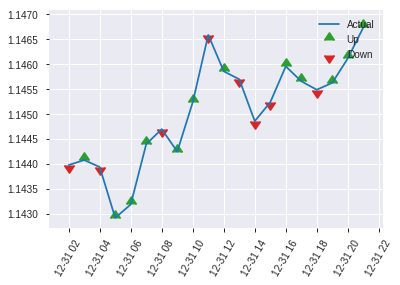


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19266920862174647
RMSE: 0.4389410081340618
LogLoss: 0.5700418511266263
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 860.749207800923
Residual deviance: 703.4316442902568
AIC: 805.4316442902568
AUC: 0.7816454363617223
pr_auc: 0.7673883101003667
Gini: 0.5632908727234447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38417588257759006: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      175  120  0.4068   (120.0/295.0)
1      53   269  0.1646   (53.0/322.0)
Total  228  389  0.2804   (173.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384176     0.756681  246
max f2                       0.135714     0.855441  353
max f0point5                 0.497515     0.740988  189
max accuracy                 0.431135     0.732577  225
max precision                0.967122     1         0
max recall                   0.0536616    1         388
max specificity              0.967122     1         0
max absolute_mcc             0.431135     0.464302  225
max min_per_class_accuracy   0.474573     0.720497  201
max mean_per_class_accuracy  0.431135     0.729719  225

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 47.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.923992           1.64241   1.64241            0.857143         0.937481   0.857143                    0.937481            0.0186335       0.0186335                  64.2413   64.2413
    2        0.0210697                   0.903158           1.59679   1.62136            0.833333         0.911445   0.846154                    0.925464            0.015528        0.0341615                  59.6791   62.1357
    3        0.0307942                   0.865972           1.59679   1.6136             0.833333         0.88563    0.842105                    0.912885            0.015528        0.0496894                  59.6791   61.3599
    4        0.0405186                   0.847659           1.59679   1.60957            0.833333         0.851381   0.84                        0.898124            0.015528        0.0652174                  59.6791   60.9565
    5        0.0502431                   0.839551           1.91615   1.6689             1                0.84258    0.870968                    0.887373            0.0186335       0.0838509                  91.6149   66.8904
    6        0.100486                    0.790762           1.48347   1.57619            0.774194         0.815651   0.822581                    0.851512            0.0745342       0.158385                   48.347    57.6187
    7        0.150729                    0.73912            1.73072   1.6277             0.903226         0.760421   0.849462                    0.821149            0.0869565       0.245342                   73.0715   62.7697
    8        0.200972                    0.70488            1.42166   1.57619            0.741935         0.718462   0.822581                    0.795477            0.0714286       0.31677                    42.1659   57.6187
    9        0.299838                    0.642099           1.41355   1.52256            0.737705         0.671289   0.794595                    0.754528            0.139752        0.456522                   41.3553   52.2562
    10       0.400324                    0.559872           1.26713   1.45845            0.66129          0.605325   0.761134                    0.717077            0.127329        0.583851                   26.7131   45.8445
    11       0.50081                     0.479134           1.26713   1.42006            0.66129          0.520112   0.7411                      0.677556            0.127329        0.71118                    26.7131   42.0059
    12       0.599676                    0.402996           0.973781  1.34648            0.508197         0.446      0.702703                    0.639381            0.0962733       0.807453                   -2.62193  34.6483
    13       0.700162                    0.323411           0.618113  1.24195            0.322581         0.363401   0.648148                    0.599773            0.0621118       0.869565                   -38.1887  24.1948
    14       0.799028                    0.238316           0.69107   1.17379            0.360656         0.280554   0.612576                    0.560275            0.068323        0.937888                   -30.893   17.3787
    15       0.899514                    0.137634           0.370868  1.08409            0.193548         0.191253   0.565766                    0.519051            0.0372671       0.975155                   -62.9132  8.40915
    16       1                           0.00405746         0.247245  1                  0.129032         0.0862931  0.52188                    

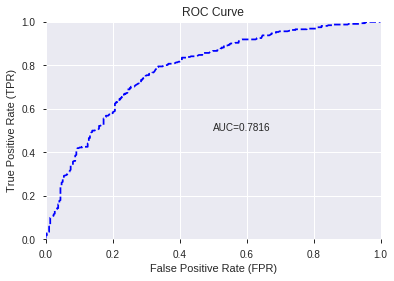

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


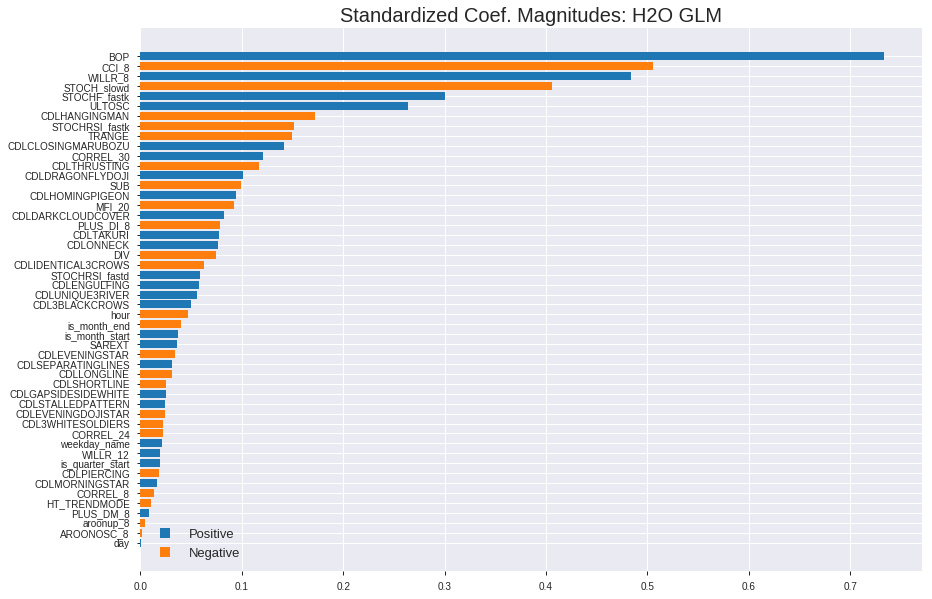

'log_likelihood'
--2019-07-25 06:56:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_065625_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_065625_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CCI_8',
 'WILLR_8',
 'STOCH_slowd',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLHANGINGMAN',
 'STOCHRSI_fastk',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CORREL_30',
 'CDLTHRUSTING',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'CDLHOMINGPIGEON',
 'MFI_20',
 'CDLDARKCLOUDCOVER',
 'PLUS_DI_8',
 'CDLTAKURI',
 'CDLONNECK',
 'DIV',
 'CDLIDENTICAL3CROWS',
 'STOCHRSI_fastd',
 'CDLENGULFING',
 'CDLUNIQUE3RIVER',
 'CDL3BLACKCROWS',
 'hour',
 'is_month_end',
 'is_month_start',
 'SAREXT',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CORREL_24',
 'weekday_name',
 'WILLR_12',
 'is_quarter_start',
 'CDLPIERCING',
 'CDLMORNINGSTAR',
 'CORREL_8',
 'HT_TRENDMODE',
 'PLUS_DM_8',
 'aroonup_8',
 'AROONOSC_8',
 'day']

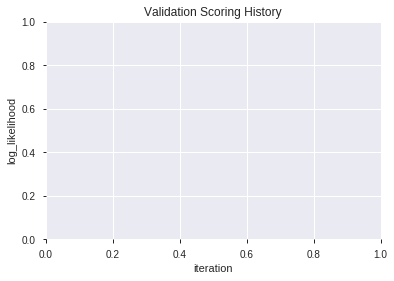

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_065735_model_2  0.799968  0.550251              0.293757  0.429836  0.184759
1  XGBoost_grid_1_AutoML_20190725_065735_model_6  0.796168  0.553746              0.299968  0.431541  0.186228
2               XGBoost_2_AutoML_20190725_065735  0.795468  0.552889              0.274534  0.431803  0.186454
3  XGBoost_grid_1_AutoML_20190725_065735_model_1  0.795236  0.555146              0.289515  0.432831  0.187342
4  XGBoost_grid_1_AutoML_20190725_065735_model_4  0.795094  0.555141              0.304911  0.432504  0.187059
5  XGBoost_grid_1_AutoML_20190725_065735_model_5  0.793289  0.556149              0.294173  0.433035  0.187520
6               XGBoost_3_AutoML_20190725_065735  0.792462  0.557155              0.288246  0.433645  0.188048
7  XGBoost_grid_1_AutoML_20190725_065735_model_3  0.791615  0.559318              0.278340  0.434378  0.188684
8               XGBoost_1_AutoML_20190725_065735  0.790810  0.556813              0.297137  0.433388  0.187825
9  XGBoost_grid_1_AutoML_20190725_065735_model_7  0.784814  0.563836              0.278482  0.437682  0.191566

variable  relative_importance  scaled_importance  percentage
0                   BOP          6412.995605           1.000000    0.375208
1          STOCHF_fastk          1148.421265           0.179077    0.067191
2                  hour          1047.160645           0.163287    0.061267
3                 CCI_8           667.903564           0.104148    0.039077
4                   DIV           596.754028           0.093054    0.034915
5                ULTOSC           555.371399           0.086601    0.032493
6                TRANGE           554.444824           0.086456    0.032439
7        STOCHRSI_fastk           472.157166           0.073625    0.027625
8               WILLR_8           456.846161           0.071238    0.026729
9             aroonup_8           432.133270           0.067384    0.025283
10       STOCHRSI_fastd           430.708252           0.067162    0.025200
11                  SUB           427.246033           0.066622    0.024997
12          STOCH_slowd           389.543060           0.060743    0.022791
13            PLUS_DI_8           373.076752           0.058175    0.021828
14               MFI_20           363.092102           0.056618    0.021244
15               SAREXT           351.894043           0.054872    0.020588
16            PLUS_DM_8           284.166840           0.044311    0.016626
17             WILLR_12           255.004059           0.039764    0.014920
18            CORREL_30           249.084824           0.038841    0.014573
19     CDLDRAGONFLYDOJI           241.775894           0.037701    0.014146
20                  day           211.046555           0.032909    0.012348
21           AROONOSC_8           199.323639           0.031081    0.011662
22         weekday_name           189.568726           0.029560    0.011091
23   CDLCLOSINGMARUBOZU           187.443253           0.029229    0.010967
24            CORREL_24           171.828934           0.026794    0.010053
25        CDLHANGINGMAN           127.005661           0.019804    0.007431
26            CDLTAKURI            85.592010           0.013347    0.005008
27         CDLSHORTLINE            43.595306           0.006798    0.002551
28         CDLENGULFING            27.310078           0.004259    0.001598
29  CDLGAPSIDESIDEWHITE            24.558411           0.003829    0.001437
30         is_month_end            23.711365           0.003697    0.001387
31          CDLLONGLINE            18.499523           0.002885    0.001082
32   CDLEVENINGDOJISTAR            17.802818           0.002776    0.001042
33          CDLPIERCING            17.033087           0.002656    0.000997
34         HT_TRENDMODE            14.643128           0.002283    0.000857
35       CDLMORNINGSTAR             9.467525           0.001476    0.000554
36     is_quarter_start             3.811646           0.000594    0.000223
37    CDLSTALLEDPATTERN             3.658209           0.000570    0.000214
38             CORREL_8             2.352747           0.000367    0.000138
39    CDL3WHITESOLDIERS             1.960279           0.000306    0.000115
40   CDLIDENTICAL3CROWS             1.833505           0.000286    0.000107

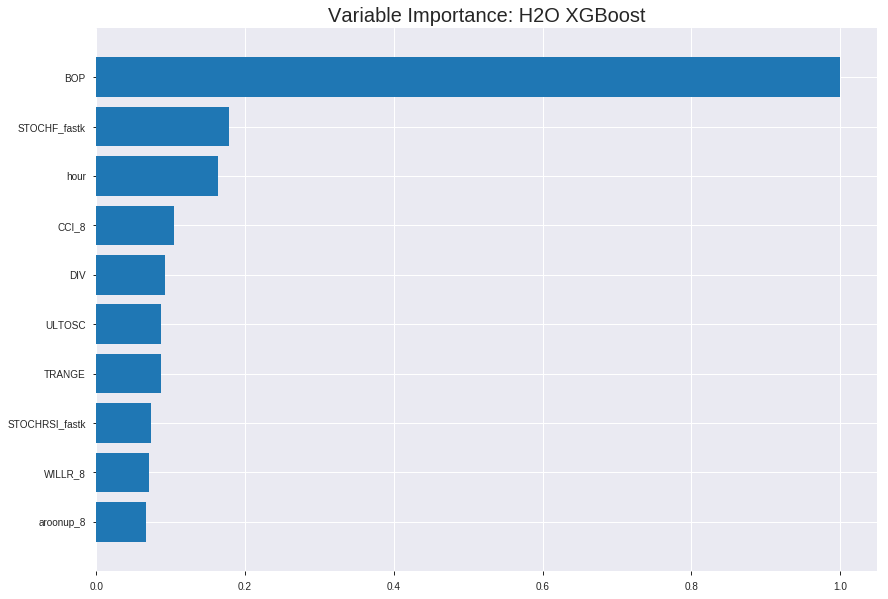

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_065735_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16311252967448264
RMSE: 0.4038719223646064
LogLoss: 0.498778314234399
Mean Per-Class Error: 0.23726728711957668
AUC: 0.8517061163848461
pr_auc: 0.8374630827318714
Gini: 0.7034122327696921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42070245146751406: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1516  772   0.3374   (772.0/2288.0)
1      304   1727  0.1497   (304.0/2031.0)
Total  1820  2499  0.2491   (1076.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420702     0.762472  232
max f2                       0.282713     0.855304  294
max f0point5                 0.581676     0.766679  151
max accuracy                 0.528182     0.764992  179
max precision                0.90476      1         0
max recall                   0.0811608    1         393
max specificity              0.90476      1         0
max absolute_mcc             0.528182     0.527575  179
max min_per_class_accuracy   0.500716     0.761364  193
max mean_per_class_accuracy  0.528182     0.762733  179

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 46.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.869707           2.12654    2.12654            1                0.883647  1                           0.883647            0.0216642       0.0216642                  112.654   112.654
    2        0.0201436                   0.852518           2.07708    2.1021             0.976744         0.86067   0.988506                    0.872291            0.0206795       0.0423437                  107.708   110.21
    3        0.0300996                   0.841553           2.12654    2.11018            1                0.846674  0.992308                    0.863818            0.0211718       0.0635155                  112.654   111.018
    4        0.0400556                   0.828902           2.07708    2.10195            0.976744         0.835238  0.988439                    0.856714            0.0206795       0.084195                   107.708   110.195
    5        0.0500116                   0.817143           1.97818    2.07731            0.930233         0.823563  0.976852                    0.850115            0.0196947       0.10389                    97.8175   107.731
    6        0.100023                    0.769812           2.01824    2.04778            0.949074         0.794716  0.962963                    0.822415            0.100935        0.204825                   101.824   104.778
    7        0.150035                    0.733301           1.9001     1.99855            0.893519         0.75161   0.939815                    0.798814            0.0950271       0.299852                   90.0102   99.8553
    8        0.200046                    0.694623           1.73274    1.9321             0.814815         0.714242  0.908565                    0.777671            0.0866568       0.386509                   73.2735   93.2098
    9        0.300069                    0.624573           1.56537    1.80986            0.736111         0.660062  0.85108                     0.738468            0.156573        0.543082                   56.5369   80.9855
    10       0.400093                    0.5587             1.28478    1.67859            0.604167         0.593342  0.789352                    0.702186            0.128508        0.67159                    28.4784   67.8587
    11       0.500116                    0.487247           1.05835    1.55454            0.497685         0.524648  0.731019                    0.666679            0.105859        0.77745                    5.83468   55.4539
    12       0.599907                    0.400139           0.85851    1.43876            0.403712         0.445651  0.676573                    0.629912            0.0856721       0.863122                   -14.149   43.8758
    13       0.699931                    0.308291           0.708846   1.33445            0.333333         0.35363   0.627522                    0.59043             0.070901        0.934023                   -29.1154  33.445
    14       0.799954                    0.221257           0.374113   1.21437            0.175926         0.262106  0.571056                    0.549378            0.03742         0.971443                   -62.5887  21.4374
    15       0.899977                    0.153091           0.241205   1.10622            0.113426         0.187339  0.520196                    0.509141            0.024126        0.995569                   -75.8795  10.6216
    16       1                           0.0641787          0.0443029  1                  0.0208333        0.117077  0.470248                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1907504003195683
RMSE: 0.43674981433260884
LogLoss: 0.5623951878400514
Mean Per-Class Error: 0.27823761854583773
AUC: 0.7806704425711275
pr_auc: 0.7405363943490773
Gini: 0.561340885142255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4403640180826187: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      420  230  0.3538   (230.0/650.0)
1      125  459  0.214    (125.0/584.0)
Total  545  689  0.2877   (355.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440364     0.721131  219
max f2                       0.210232     0.841584  329
max f0point5                 0.513334     0.703984  184
max accuracy                 0.513334     0.719611  184
max precision                0.91544      1         0
max recall                   0.11689      1         382
max specificity              0.91544      1         0
max absolute_mcc             0.472719     0.443604  205
max min_per_class_accuracy   0.500638     0.717466  191
max mean_per_class_accuracy  0.472719     0.721762  205

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.871228           1.78793   1.78793            0.846154         0.88914   0.846154                    0.88914             0.0188356       0.0188356                  78.7935   78.7935
    2        0.0202593                   0.854543           2.11301   1.94397            1                0.862201  0.92                        0.876209            0.0205479       0.0393836                  111.301   94.3973
    3        0.0299838                   0.838722           1.93693   1.94169            0.916667         0.846487  0.918919                    0.86657             0.0188356       0.0582192                  93.6929   94.1688
    4        0.0405186                   0.819083           1.95047   1.94397            0.923077         0.82962   0.92                        0.856963            0.0205479       0.0787671                  95.0474   94.3973
    5        0.0502431                   0.807059           1.76084   1.90853            0.833333         0.813091  0.903226                    0.848472            0.0171233       0.0958904                  76.0845   90.8529
    6        0.100486                    0.759608           1.63588   1.77221            0.774194         0.782683  0.83871                     0.815577            0.0821918       0.178082                   63.5882   77.2205
    7        0.149919                    0.729599           1.73198   1.75894            0.819672         0.744623  0.832432                    0.792182            0.0856164       0.263699                   73.1978   75.8941
    8        0.200162                    0.687538           1.4314    1.67672            0.677419         0.708649  0.793522                    0.771214            0.0719178       0.335616                   43.1396   67.6723
    9        0.299838                    0.624878           1.40868   1.58762            0.666667         0.656546  0.751351                    0.733095            0.140411        0.476027                   40.8676   58.7616
    10       0.400324                    0.552851           1.36323   1.53129            0.645161         0.590348  0.724696                    0.697263            0.136986        0.613014                   36.3235   53.1293
    11       0.5                         0.489527           1.16817   1.4589             0.552846         0.523617  0.690438                    0.662647            0.116438        0.729452                   16.817    45.8904
    12       0.599676                    0.404723           0.807412  1.35062            0.382114         0.449179  0.639189                    0.627165            0.0804795       0.809932                   -19.2588  35.0616
    13       0.700162                    0.313917           0.8009    1.27172            0.379032         0.356974  0.601852                    0.588388            0.0804795       0.890411                   -19.91    27.1721
    14       0.799838                    0.21964            0.652801  1.19459            0.308943         0.267165  0.56535                     0.548357            0.0650685       0.955479                   -34.7199  19.4591
    15       0.899514                    0.156307           0.292043  1.09458            0.138211         0.185339  0.518018                    0.50813             0.0291096       0.984589                   -70.7957  9.45792
    16       1                           0.0701928          0.153364  1                  0.0725806        0.123199  0.473258                    0.46945          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:57:47  2.099 sec   0                  0.5              0.693147            0.5             0                  1                0.529752                         0.5                0.693147              0.5               0                    1                  0.526742
    2019-07-25 06:57:47  2.209 sec   5                  0.479363         0.652546            0.792305        0.741014           1.9361           0.299606                         0.481467           0.656603              0.76306           0.697209             1.87823            0.331442
    2019-07-25 06:57:47  2.278 sec   10                 0.464099         0.622917            0.797702        0.758441           1.95777          0.292429                         0.46903            0.63221               0.762762          0.71294              1.96208            0.311183
    2019-07-25 06:57:47  2.355 sec   15                 0.452858         0.600942            0.802738        0.770891           2.00385          0.285714                         0.459991           0.614202              0.766861          0.722098             1.95047            0.32577
    2019-07-25 06:57:47  2.441 sec   20                 0.444473         0.584218            0.807081        0.778053           2.02988          0.279231                         0.454169           0.602288              0.768271          0.726294             1.95047            0.329822
    2019-07-25 06:57:47  2.539 sec   25                 0.438328         0.571693            0.810917        0.785544           1.98155          0.284788                         0.449843           0.59324               0.770813          0.727879             1.78793            0.32577
    2019-07-25 06:57:48  2.646 sec   30                 0.433316         0.561189            0.814489        0.791764           2.07821          0.279463                         0.44663            0.586267              0.772547          0.730649             1.78793            0.317666
    2019-07-25 06:57:48  2.779 sec   35                 0.429085         0.552236            0.818177        0.795916           2.07821          0.276221                         0.444337           0.581156              0.774062          0.733242             1.78793            0.296596
    2019-07-25 06:57:48  2.871 sec   40                 0.425671         0.544849            0.821575        0.801055           2.07821          0.268349                         0.442789           0.577487              0.774805          0.735517             1.78793            0.300648
    2019-07-25 06:57:48  2.960 sec   45                 0.422388         0.537884            0.826097        0.806379           2.07821          0.267655                         0.441333           0.574082              0.776387          0.737741             1.95047            0.3047
    2019-07-25 06:57:48  3.081 sec   50                 0.419961         0.532522            0.828793        0.810405           2.07821          0.268118                         0.44006            0.571059              0.778118          0.739048             1.95047            0.305511
    2019-07-25 06:57:48  3.180 sec   55                 0.417099         0.526443            0.83266         0.815723           2.07821          0.267423                         0.439282           0.569061              0.778405          0.739

Variable Importances: 


variable            relative_importance    scaled_importance       percentage
------------------  ---------------------  ----------------------  ----------------------
BOP                 6412.99560546875       1.0                     0.37520833262032777
STOCHF_fastk        1148.4212646484375     0.17907719501150274     0.06719125575059123
hour                1047.16064453125       0.16328728552975658     0.061266750141719346
CCI_8               667.903564453125       0.10414845191591324     0.03907736698835819
DIV                 596.7540283203125      0.09305386515646824     0.03491458558923527
---                 ---                    ---                     ---
is_quarter_start    3.8116455078125        0.0005943627194383353   0.00022300984493214148
CDLSTALLEDPATTERN   3.6582088470458984     0.0005704368242395679   0.00021403264968816323
CORREL_8            2.3527469635009766     0.0003668717567020702   0.00013765334011767432
CDL3WHITESOLDIERS   1.9602785110473633     0.00030567282930549884  0.00011469099261105428
CDLIDENTICAL3CROWS  1.8335046768188477     0.0002859045584337072   0.00010727377265846235


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7341977309562399)

('F1', 0.7671957671957672)

('auc', 0.799968417728182)

('logloss', 0.5502513431101155)

('mean_per_class_error', 0.2638961995999578)

('rmse', 0.4298358877134162)

('mse', 0.18475889036638052)

xgboost prediction progress: |████████████████████████████████████████████| 100%


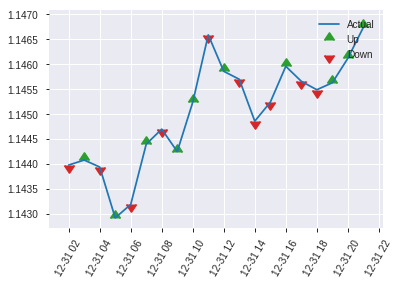


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18475889036638052
RMSE: 0.4298358877134162
LogLoss: 0.5502513431101155
Mean Per-Class Error: 0.2638961995999578
AUC: 0.799968417728182
pr_auc: 0.7909738250234943
Gini: 0.5999368354563639
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3237033188343048: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  144  0.4881   (144.0/295.0)
1      32   290  0.0994   (32.0/322.0)
Total  183  434  0.2853   (176.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323703     0.767196  282
max f2                       0.194231     0.863309  339
max f0point5                 0.525485     0.756445  181
max accuracy                 0.525485     0.734198  181
max precision                0.901811     1         0
max recall                   0.0698494    1         397
max specificity              0.901811     1         0
max absolute_mcc             0.525485     0.4728    181
max min_per_class_accuracy   0.49133      0.722034  201
max mean_per_class_accuracy  0.525485     0.736104  181

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.87338            1.64241   1.64241            0.857143         0.886488  0.857143                    0.886488            0.0186335       0.0186335                  64.2413   64.2413
    2        0.0210697                   0.851144           1.91615   1.76875            1                0.859252  0.923077                    0.873918            0.0186335       0.0372671                  91.6149   76.8753
    3        0.0307942                   0.840311           1.91615   1.8153             1                0.849104  0.947368                    0.866082            0.0186335       0.0559006                  91.6149   81.5299
    4        0.0405186                   0.828018           1.91615   1.8395             1                0.833179  0.96                        0.858185            0.0186335       0.0745342                  91.6149   83.9503
    5        0.0502431                   0.817736           1.59679   1.79253            0.833333         0.821658  0.935484                    0.851115            0.015528        0.0900621                  59.6791   79.2527
    6        0.100486                    0.7713             1.6689    1.73072            0.870968         0.792797  0.903226                    0.821956            0.0838509       0.173913                   66.8904   73.0715
    7        0.150729                    0.738888           1.48347   1.6483             0.774194         0.751347  0.860215                    0.79842             0.0745342       0.248447                   48.347    64.83
    8        0.200972                    0.701959           1.48347   1.60709            0.774194         0.719927  0.83871                     0.778796            0.0745342       0.322981                   48.347    60.7093
    9        0.299838                    0.64606            1.50779   1.57435            0.786885         0.670293  0.821622                    0.74302             0.149068        0.47205                    50.7789   57.435
    10       0.400324                    0.572561           1.29804   1.50499            0.677419         0.61286   0.785425                    0.710348            0.130435        0.602484                   29.8036   50.4992
    11       0.50081                     0.498774           1.1126    1.42626            0.580645         0.536081  0.744337                    0.675382            0.111801        0.714286                   11.2603   42.626
    12       0.599676                    0.420167           0.942368  1.34648            0.491803         0.457015  0.702703                    0.639381            0.0931677       0.807453                   -5.76316  34.6483
    13       0.700162                    0.328131           0.896263  1.28187            0.467742         0.375845  0.668981                    0.601558            0.0900621       0.897516                   -10.3737  28.1868
    14       0.799028                    0.229203           0.471184  1.18156            0.245902         0.267945  0.616633                    0.56028             0.0465839       0.944099                   -52.8816  18.156
    15       0.899514                    0.156079           0.309056  1.08409            0.16129          0.187614  0.565766                    0.518648            0.0310559       0.975155                   -69.0944  8.40915
    16       1                           0.0642276          0.247245  1                  0.129032         0.118942  0.52188                     0.478483            0.

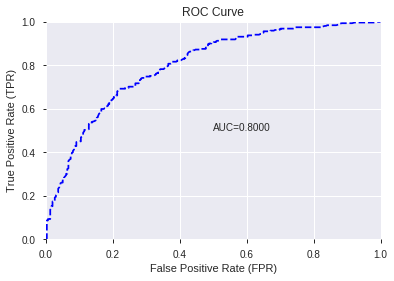

This function is available for GLM models only


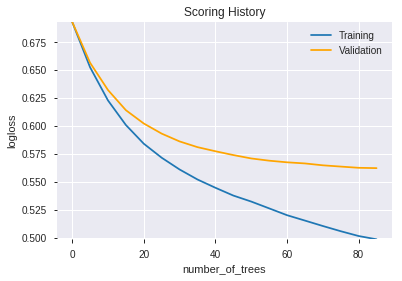

--2019-07-25 06:58:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_065735_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_065735_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'hour',
 'CCI_8',
 'DIV',
 'ULTOSC',
 'TRANGE',
 'STOCHRSI_fastk',
 'WILLR_8',
 'aroonup_8',
 'STOCHRSI_fastd',
 'SUB',
 'STOCH_slowd',
 'PLUS_DI_8',
 'MFI_20',
 'SAREXT',
 'PLUS_DM_8',
 'WILLR_12',
 'CORREL_30',
 'CDLDRAGONFLYDOJI',
 'day',
 'AROONOSC_8',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'CORREL_24',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLGAPSIDESIDEWHITE',
 'is_month_end',
 'CDLLONGLINE',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'HT_TRENDMODE',
 'CDLMORNINGSTAR',
 'is_quarter_start',
 'CDLSTALLEDPATTERN',
 'CORREL_8',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_065914_model_1  0.78344  0.587569              0.291768  0.448444  0.201102

variable  relative_importance  scaled_importance    percentage
0                          BOP         5.097236e-01       1.000000e+00  4.185906e-02
1                        CCI_8         1.917185e-01       3.761224e-01  1.574413e-02
2                 STOCHF_fastk         1.876232e-01       3.680881e-01  1.540782e-02
3                      WILLR_8         1.779766e-01       3.491630e-01  1.461563e-02
4           CDLCLOSINGMARUBOZU         1.703234e-01       3.341486e-01  1.398715e-02
...                        ...                  ...                ...           ...
1032  BBANDS_middleband_12_5_4         1.248198e-05       2.448774e-05  1.025034e-06
1033   BBANDS_lowerband_20_3_4         7.003635e-06       1.374006e-05  5.751462e-07
1034   BBANDS_lowerband_12_1_2         5.437654e-06       1.066785e-05  4.465461e-07
1035   BBANDS_upperband_14_6_5         9.592888e-07       1.881978e-06  7.877785e-08
1036  BBANDS_middleband_12_5_3         4.005903e-07       7.858972e-07  3.289692e-08

[1037 rows x 4 columns]

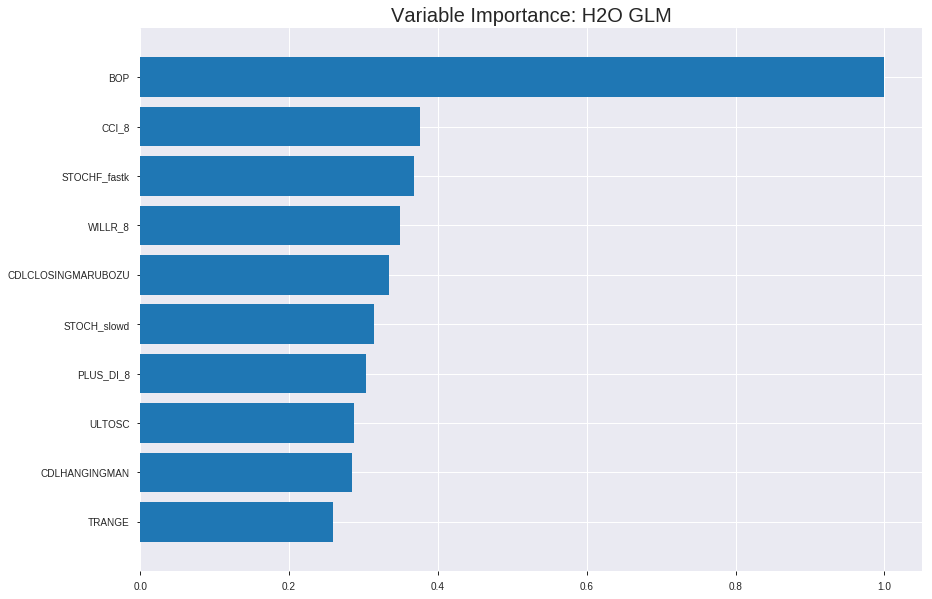

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_065914_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18769338870957855
RMSE: 0.43323595038913676
LogLoss: 0.5549592057164411
Null degrees of freedom: 4318
Residual degrees of freedom: 3281
Null deviance: 5972.1036478564565
Residual deviance: 4793.737618978618
AIC: 6869.737618978618
AUC: 0.7882844322098383
pr_auc: 0.7592783013149708
Gini: 0.5765688644196767
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3674329859895268: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1262  1026  0.4484   (1026.0/2288.0)
1      299   1732  0.1472   (299.0/2031.0)
Total  1561  2758  0.3068   (1325.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367433     0.723324  249
max f2                       0.177629     0.83145   340
max f0point5                 0.575831     0.704388  150
max accuracy                 0.477408     0.717064  198
max precision                0.979355     1         0
max recall                   0.0302981    1         393
max specificity              0.979355     1         0
max absolute_mcc             0.477408     0.433533  198
max min_per_class_accuracy   0.477408     0.716783  198
max mean_per_class_accuracy  0.477408     0.717082  198

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.914136           2.12654   2.12654            1                0.938276  1                           0.938276            0.0216642       0.0216642                  112.654   112.654
    2        0.0201436                   0.88744            1.87927   2.00432            0.883721         0.899931  0.942529                    0.919324            0.01871         0.0403742                  87.9267   100.432
    3        0.0300996                   0.863983           1.87927   1.96296            0.883721         0.875209  0.923077                    0.904732            0.01871         0.0590842                  87.9267   96.2959
    4        0.0400556                   0.850756           1.82981   1.92986            0.860465         0.856848  0.907514                    0.89283             0.0182176       0.0773018                  82.9812   92.9865
    5        0.0500116                   0.837921           1.87927   1.91979            0.883721         0.84379   0.902778                    0.883068            0.01871         0.0960118                  87.9267   91.9792
    6        0.100023                    0.78062            1.84103   1.88041            0.865741         0.806963  0.884259                    0.845015            0.0920729       0.188085                   84.1031   88.0411
    7        0.150035                    0.733262           1.5949    1.78524            0.75             0.75648   0.839506                    0.815503            0.0797637       0.267848                   59.4904   78.5242
    8        0.200046                    0.692981           1.56537   1.73027            0.736111         0.712869  0.813657                    0.789845            0.0782866       0.346135                   56.5369   73.0274
    9        0.300069                    0.61613            1.43738   1.63264            0.675926         0.652951  0.767747                    0.744213            0.143772        0.489906                   43.7383   63.2643
    10       0.400093                    0.540743           1.29463   1.54814            0.608796         0.579236  0.728009                    0.702969            0.129493        0.619399                   29.4629   54.814
    11       0.500116                    0.466231           1.0928    1.45707            0.513889         0.503481  0.685185                    0.663072            0.109306        0.728705                   9.28046   45.7073
    12       0.599907                    0.397198           0.902915  1.36489            0.424594         0.431896  0.641837                    0.624617            0.0901034       0.818808                   -9.70845  36.4891
    13       0.699931                    0.325226           0.753149  1.27747            0.354167         0.36005   0.600728                    0.586809            0.0753323       0.894141                   -24.6851  27.7471
    14       0.799954                    0.249475           0.477487  1.17744            0.224537         0.287245  0.55369                     0.549352            0.0477597       0.941901                   -52.2513  17.7444
    15       0.899977                    0.162286           0.398726  1.0909             0.1875           0.206876  0.512992                    0.51129             0.0398818       0.981782                   -60.1274  9.08974
    16       1                           0.0018919          0.182134  1                  0.0856481        0.100965  0.470248                    0.470248          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19608225560296283
RMSE: 0.4428117609131027
LogLoss: 0.5755852172988464
Null degrees of freedom: 1233
Residual degrees of freedom: 196
Null deviance: 1707.2004406915303
Residual deviance: 1420.544316293553
AIC: 3496.544316293553
AUC: 0.7733746048472077
pr_auc: 0.7296047830875421
Gini: 0.5467492096944153
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2942615235299356: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      330  320  0.4923   (320.0/650.0)
1      66   518  0.113    (66.0/584.0)
Total  396  838  0.3128   (386.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294262     0.728551  277
max f2                       0.166271     0.83211   338
max f0point5                 0.479958     0.697761  182
max accuracy                 0.479958     0.708266  182
max precision                0.928981     1         0
max recall                   0.0355365    1         392
max specificity              0.928981     1         0
max absolute_mcc             0.294262     0.422121  277
max min_per_class_accuracy   0.429477     0.703077  207
max mean_per_class_accuracy  0.438124     0.705803  201

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 43.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.871455           1.95047   1.95047            0.923077         0.905223   0.923077                    0.905223            0.0205479       0.0205479                  95.0474   95.0474
    2        0.0202593                   0.849333           1.93693   1.94397            0.916667         0.858913   0.92                        0.882994            0.0188356       0.0393836                  93.6929   94.3973
    3        0.0299838                   0.832508           1.40868   1.77036            0.666667         0.84142    0.837838                    0.869511            0.0136986       0.0530822                  40.8676   77.0363
    4        0.0405186                   0.807234           1.78793   1.77493            0.846154         0.821648   0.84                        0.857066            0.0188356       0.0719178                  78.7935   77.4932
    5        0.0502431                   0.788486           1.58476   1.73812            0.75             0.798449   0.822581                    0.845721            0.015411        0.0873288                  58.476    73.8124
    6        0.100486                    0.731805           1.80629   1.77221            0.854839         0.759599   0.83871                     0.80266             0.0907534       0.178082                   80.6286   77.2205
    7        0.149919                    0.691004           1.59342   1.71325            0.754098         0.71362    0.810811                    0.773301            0.0787671       0.256849                   59.342    71.3254
    8        0.200162                    0.649893           1.56772   1.67672            0.741935         0.670265   0.793522                    0.747438            0.0787671       0.335616                   56.772    67.6723
    9        0.299838                    0.574327           1.3915    1.5819             0.658537         0.611292   0.748649                    0.702178            0.138699        0.474315                   39.1497   58.1905
    10       0.400324                    0.497473           1.32915   1.51846            0.629032         0.534438   0.718623                    0.660073            0.133562        0.607877                   32.9154   51.8461
    11       0.5                         0.421408           1.04792   1.42466            0.495935         0.457891   0.67423                     0.619768            0.104452        0.712329                   4.79174   42.4658
    12       0.599676                    0.348133           0.962022  1.34776            0.455285         0.382315   0.637838                    0.5803              0.0958904       0.808219                   -3.79775  34.776
    13       0.700162                    0.283963           0.886103  1.2815             0.419355         0.31429    0.606481                    0.542122            0.0890411       0.89726                    -11.3897  28.1504
    14       0.799838                    0.209806           0.412295  1.17318            0.195122         0.246883   0.555218                    0.50533             0.0410959       0.938356                   -58.7705  17.3183
    15       0.899514                    0.138435           0.395116  1.08696            0.186992         0.17649    0.514414                    0.468891            0.0393836       0.97774                    -60.4884  8.69647
    16       1                           0.00759023         0.221526  1                  0.104839         0.0917378  0.473258                    


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 06:59:22  0.000 sec         2            .2E2      839           1.3600705007225014  1.360765685202014
     2019-07-25 06:59:27  4.966 sec         4            .15E2     870           1.3534748038136957  1.354091322476718
     2019-07-25 06:59:32  9.752 sec         6            .11E2     933           1.345281499815449   1.3458326034672117
     2019-07-25 06:59:37  14.768 sec        8            .77E1     974           1.3353111378663216  1.335817538983995
     2019-07-25 06:59:42  19.689 sec        10           .56E1     997           1.3234053575530837  1.3239081258891576
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-07-25 07:01:09  1 min 46.923 sec  46           .19E-1    1038          1.1058741714925282  1.151320025956216
     2019-07-25 07:01:14  1 min 51.903 sec  48           .14E-1    1038          1.1022790788714645  1.1518684073738534
     2019-07-25 07:01:19  1 min 56.733 sec  50           .98E-2    1038          1.0990684685661902  1.1527698837286677
     2019-07-25 07:01:24  2 min  1.597 sec  52           .72E-2    1038          1.0961883600846283  1.1539582463127573
     2019-07-25 07:01:29  2 min  6.538 sec  54           .52E-2    1038          1.093610963140947   1.1553595369979435


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7196110210696921)

('F1', 0.7582417582417582)

('auc', 0.7834403621433835)

('logloss', 0.587568981490185)

('mean_per_class_error', 0.2812822402358144)

('rmse', 0.4484438010198866)

('mse', 0.20110184267316367)

glm prediction progress: |████████████████████████████████████████████████| 100%


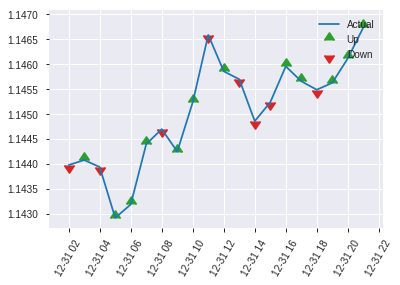


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20110184267316367
RMSE: 0.4484438010198866
LogLoss: 0.587568981490185
Null degrees of freedom: 616
Residual degrees of freedom: -421
Null deviance: 860.749207800923
Residual deviance: 725.0601231588882
AIC: 2801.060123158888
AUC: 0.7834403621433835
pr_auc: 0.7763953181601577
Gini: 0.5668807242867671
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3009270153916875: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      165  130  0.4407   (130.0/295.0)
1      46   276  0.1429   (46.0/322.0)
Total  211  406  0.2853   (176.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300927     0.758242  257
max f2                       0.18273      0.85881   321
max f0point5                 0.53742      0.734783  141
max accuracy                 0.395842     0.719611  210
max precision                0.98347      1         0
max recall                   0.0388343    1         390
max specificity              0.98347      1         0
max absolute_mcc             0.300927     0.438544  257
max min_per_class_accuracy   0.408404     0.708475  203
max mean_per_class_accuracy  0.395842     0.718718  210

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 41.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.897314           1.91615   1.91615            1                0.928177   1                           0.928177            0.0217391       0.0217391                  91.6149   91.6149
    2        0.0210697                   0.828049           1.59679   1.76875            0.833333         0.856759   0.923077                    0.895215            0.015528        0.0372671                  59.6791   76.8753
    3        0.0307942                   0.811078           1.27743   1.6136             0.666667         0.81648    0.842105                    0.870351            0.0124224       0.0496894                  27.7433   61.3599
    4        0.0405186                   0.803764           1.59679   1.60957            0.833333         0.8059     0.84                        0.854883            0.015528        0.0652174                  59.6791   60.9565
    5        0.0502431                   0.785266           1.59679   1.60709            0.833333         0.794854   0.83871                     0.843264            0.015528        0.0807453                  59.6791   60.7093
    6        0.100486                    0.725165           1.73072   1.6689             0.903226         0.756205   0.870968                    0.799735            0.0869565       0.167702                   73.0715   66.8904
    7        0.150729                    0.669738           1.6689    1.6689             0.870968         0.694608   0.870968                    0.764692            0.0838509       0.251553                   66.8904   66.8904
    8        0.200972                    0.62649            1.35985   1.59164            0.709677         0.643273   0.830645                    0.734338            0.068323        0.319876                   35.9848   59.164
    9        0.299838                    0.559624           1.47638   1.55363            0.770492         0.593355   0.810811                    0.687851            0.145963        0.465839                   47.6377   55.3634
    10       0.400324                    0.490272           1.1126    1.44293            0.580645         0.524023   0.753036                    0.646729            0.111801        0.57764                    11.2603   44.293
    11       0.50081                     0.415718           1.20532   1.39525            0.629032         0.451519   0.728155                    0.60756             0.121118        0.698758                   20.532    39.5254
    12       0.599676                    0.343029           1.00519   1.33095            0.52459          0.376285   0.694595                    0.569431            0.0993789       0.798137                   0.519295  33.0947
    13       0.700162                    0.272613           0.865358  1.26413            0.451613         0.307327   0.659722                    0.531814            0.0869565       0.885093                   -13.4642  26.4126
    14       0.799028                    0.204412           0.502596  1.1699             0.262295         0.236704   0.610548                    0.4953              0.0496894       0.934783                   -49.7404  16.99
    15       0.899514                    0.125445           0.432679  1.08754            0.225806         0.165063   0.567568                    0.458408            0.0434783       0.978261                   -56.7321  8.75441
    16       1                           0.00939513         0.216339  1                  0.112903         0.0724225  0.52188                     0.4

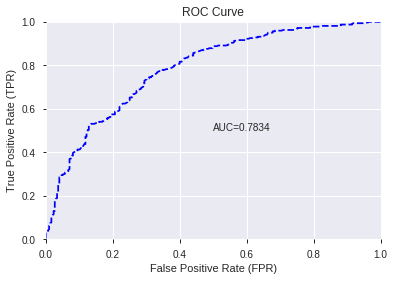

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


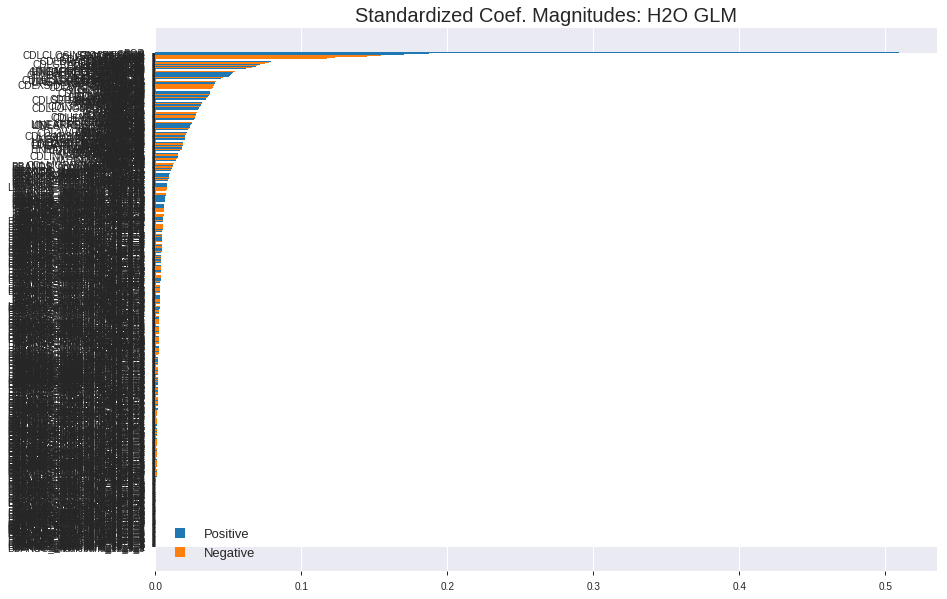

'log_likelihood'
--2019-07-25 07:01:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_065914_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_065914_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

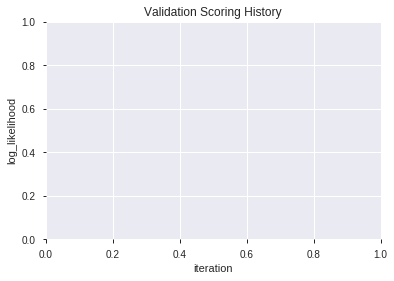

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_070255_model_4  0.795689  0.554679              0.285972  0.431955  0.186585
1               XGBoost_3_AutoML_20190725_070255  0.794289  0.558970              0.270718  0.433889  0.188260
2  XGBoost_grid_1_AutoML_20190725_070255_model_2  0.792952  0.561193              0.305053  0.434908  0.189145
3               XGBoost_2_AutoML_20190725_070255  0.791146  0.557830              0.295868  0.433402  0.187838
4               XGBoost_1_AutoML_20190725_070255  0.788346  0.560735              0.269723  0.434581  0.188861
5  XGBoost_grid_1_AutoML_20190725_070255_model_1  0.787499  0.562568              0.272981  0.435866  0.189979
6  XGBoost_grid_1_AutoML_20190725_070255_model_7  0.785025  0.561070              0.294731  0.435462  0.189627
7  XGBoost_grid_1_AutoML_20190725_070255_model_3  0.783746  0.566621              0.272544  0.437696  0.191578
8  XGBoost_grid_1_AutoML_20190725_070255_model_6  0.782140  0.568656              0.299542  0.438732  0.192486
9  XGBoost_grid_1_AutoML_20190725_070255_model_5  0.770302  0.581005              0.307875  0.444458  0.197543

variable  relative_importance  scaled_importance  percentage
0                        BOP          4846.745117           1.000000    0.346127
1               STOCHF_fastk           739.443604           0.152565    0.052807
2                     TRANGE           567.331543           0.117054    0.040516
3                       hour           457.685333           0.094431    0.032685
4                        DIV           450.852539           0.093022    0.032197
..                       ...                  ...                ...         ...
190                  BETA_20             5.397049           0.001114    0.000385
191              MINUS_DM_14             4.683193           0.000966    0.000334
192  BBANDS_upperband_12_3_2             4.513329           0.000931    0.000322
193              MINUS_DI_24             3.668709           0.000757    0.000262
194                   CMO_12             2.170269           0.000448    0.000155

[195 rows x 4 columns]

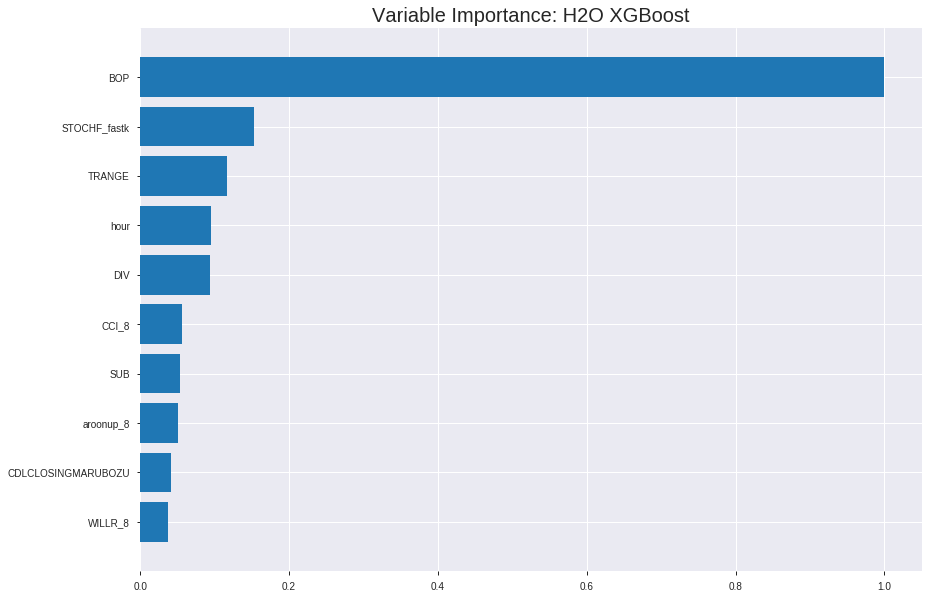

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_070255_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16636272194899154
RMSE: 0.4078758658574831
LogLoss: 0.5071925898493438
Mean Per-Class Error: 0.2357152940609366
AUC: 0.8476233115727206
pr_auc: 0.8311275104154772
Gini: 0.6952466231454413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41695005297660825: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1485  803   0.351    (803.0/2288.0)
1      299   1732  0.1472   (299.0/2031.0)
Total  1784  2535  0.2552   (1102.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41695      0.758651  222
max f2                       0.224231     0.853836  322
max f0point5                 0.594984     0.768477  135
max accuracy                 0.540501     0.767307  163
max precision                0.889599     1         0
max recall                   0.105089     1         382
max specificity              0.889599     1         0
max absolute_mcc             0.540501     0.532366  163
max min_per_class_accuracy   0.509481     0.75677   180
max mean_per_class_accuracy  0.539        0.764285  164

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.860481           2.12654    2.12654            1                0.87187   1                           0.87187             0.0216642       0.0216642                  112.654   112.654
    2        0.0201436                   0.840254           2.12654    2.12654            1                0.851091  1                           0.8616              0.0211718       0.042836                   112.654   112.654
    3        0.0300996                   0.826533           2.07708    2.11018            0.976744         0.832385  0.992308                    0.851936            0.0206795       0.0635155                  107.708   111.018
    4        0.0400556                   0.810282           2.07708    2.10195            0.976744         0.817938  0.988439                    0.843486            0.0206795       0.084195                   107.708   110.195
    5        0.0500116                   0.799103           1.82981    2.04778            0.860465         0.804178  0.962963                    0.835661            0.0182176       0.102413                   82.9812   104.778
    6        0.100023                    0.756911           1.93948    1.99363            0.912037         0.776668  0.9375                      0.806165            0.0969966       0.199409                   93.9482   99.363
    7        0.150035                    0.71974            1.93948    1.97558            0.912037         0.738196  0.929012                    0.783508            0.0969966       0.296406                   93.9482   97.5581
    8        0.200046                    0.689384           1.73274    1.91487            0.814815         0.704541  0.900463                    0.763767            0.0866568       0.383063                   73.2735   91.4869
    9        0.300069                    0.626019           1.58014    1.80329            0.743056         0.657773  0.847994                    0.728435            0.15805         0.541113                   58.0136   80.3292
    10       0.400093                    0.564895           1.33401    1.68597            0.627315         0.596194  0.792824                    0.695375            0.133432        0.674545                   33.4009   68.5971
    11       0.500116                    0.496157           0.954973   1.53977            0.449074         0.529696  0.724074                    0.662239            0.0955194       0.770064                   -4.50266  53.9772
    12       0.599907                    0.404673           0.902915   1.43383            0.424594         0.450499  0.674257                    0.627017            0.0901034       0.860167                   -9.70845  43.3834
    13       0.699931                    0.315821           0.694079   1.32812            0.326389         0.359951  0.624545                    0.588852            0.0694239       0.929591                   -30.5921  32.8119
    14       0.799954                    0.238577           0.438106   1.21684            0.206019         0.276096  0.572214                    0.549747            0.0438208       0.973412                   -56.1894  21.6836
    15       0.899977                    0.165877           0.206747   1.10457            0.0972222        0.201741  0.519424                    0.511069            0.0206795       0.994092                   -79.3253  10.4575
    16       1                           0.0502167          0.0590705  1                  0.0277778        0.122773  0.470248                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19276525387896437
RMSE: 0.4390504001580734
LogLoss: 0.567359370291501
Mean Per-Class Error: 0.2842439409905163
AUC: 0.7760958904109588
pr_auc: 0.7407183254062965
Gini: 0.5521917808219177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.301426000893116: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      296  354  0.5446   (354.0/650.0)
1      56   528  0.0959   (56.0/584.0)
Total  352  882  0.3323   (410.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301426     0.720327  284
max f2                       0.200837     0.837526  335
max f0point5                 0.575523     0.700845  153
max accuracy                 0.507623     0.714749  188
max precision                0.901245     1         0
max recall                   0.0938335    1         390
max specificity              0.901245     1         0
max absolute_mcc             0.492959     0.43094   195
max min_per_class_accuracy   0.511625     0.710769  187
max mean_per_class_accuracy  0.492959     0.715756  195

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 47.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.857544           2.11301   2.11301            1                0.875368  1                           0.875368            0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.839464           1.76084   1.94397            0.833333         0.849081  0.92                        0.86275             0.0171233       0.0393836                  76.0845   94.3973
    3        0.0299838                   0.827496           1.93693   1.94169            0.916667         0.834383  0.918919                    0.85355             0.0188356       0.0582192                  93.6929   94.1688
    4        0.0405186                   0.818615           1.6254    1.85945            0.769231         0.822826  0.88                        0.845562            0.0171233       0.0753425                  62.5395   85.9452
    5        0.0502431                   0.801129           1.58476   1.80629            0.75             0.810155  0.854839                    0.838709            0.015411        0.0907534                  58.476    80.6286
    6        0.100486                    0.756625           1.80629   1.80629            0.854839         0.775584  0.854839                    0.807146            0.0907534       0.181507                   80.6286   80.6286
    7        0.149919                    0.726555           1.6627    1.75894            0.786885         0.742189  0.832432                    0.785728            0.0821918       0.263699                   66.2699   75.8941
    8        0.200162                    0.696971           1.49956   1.69383            0.709677         0.711058  0.801619                    0.766985            0.0753425       0.339041                   49.9558   69.3833
    9        0.299838                    0.643074           1.28842   1.55906            0.609756         0.671451  0.737838                    0.735226            0.128425        0.467466                   28.8423   55.9061
    10       0.400324                    0.579674           1.44844   1.53129            0.685484         0.610357  0.724696                    0.703883            0.145548        0.613014                   44.8437   53.1293
    11       0.5                         0.499022           1.13381   1.45205            0.536585         0.541659  0.687196                    0.671543            0.113014        0.726027                   13.3812   45.2055
    12       0.599676                    0.411077           0.790233  1.34205            0.373984         0.452932  0.635135                    0.635206            0.0787671       0.804795                   -20.9767  34.2049
    13       0.700162                    0.313827           0.834981  1.26928            0.395161         0.363036  0.600694                    0.596145            0.0839041       0.888699                   -16.5019  26.9276
    14       0.799838                    0.234171           0.635622  1.19031            0.300813         0.27317   0.563323                    0.555896            0.0633562       0.952055                   -36.4378  19.031
    15       0.899514                    0.160195           0.274864  1.08887            0.130081         0.196625  0.515315                    0.516085            0.0273973       0.979452                   -72.5136  8.88683
    16       1                           0.0680527          0.204485  1                  0.0967742        0.124072  0.473258                    0.476693          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:04:20  33.140 sec  0                  0.5              0.693147            0.5             0                  1                0.529752                         0.5                0.693147              0.5               0                    1                  0.526742
    2019-07-25 07:04:22  34.873 sec  5                  0.477954         0.649768            0.788152        0.754625           2.03605          0.294744                         0.480407           0.654496              0.754921          0.715056             2.11301            0.318476
    2019-07-25 07:04:22  35.646 sec  10                 0.462701         0.620035            0.795709        0.764713           2.08401          0.31072                          0.468343           0.630729              0.75544           0.719801             2.11301            0.339546
    2019-07-25 07:04:23  36.394 sec  15                 0.45203          0.598891            0.799731        0.768153           2.07821          0.306089                         0.459994           0.613897              0.759968          0.723328             2.11301            0.342788
    2019-07-25 07:04:24  37.131 sec  20                 0.444233         0.583068            0.803674        0.776064           2.12654          0.292892                         0.453473           0.600338              0.763688          0.727232             1.95047            0.315235
    2019-07-25 07:04:25  37.893 sec  25                 0.438295         0.570619            0.806682        0.779003           2.12654          0.293586                         0.450052           0.592796              0.764182          0.724639             1.95047            0.309562
    2019-07-25 07:04:25  38.626 sec  30                 0.434044         0.561432            0.809119        0.781835           2.12654          0.302153                         0.447303           0.586593              0.766442          0.729041             1.95047            0.322528
    2019-07-25 07:04:26  39.401 sec  35                 0.430293         0.553295            0.812439        0.785603           2.12654          0.295439                         0.445084           0.58154               0.768435          0.732071             1.95047            0.317666
    2019-07-25 07:04:27  40.155 sec  40                 0.427463         0.547045            0.815335        0.789759           2.12654          0.296365                         0.443584           0.577865              0.769963          0.734626             2.11301            0.353323
    2019-07-25 07:04:28  40.948 sec  45                 0.42412          0.540014            0.820597        0.797321           2.12654          0.294744                         0.442813           0.575973              0.770153          0.729431             1.95047            0.322528
    2019-07-25 07:04:28  41.716 sec  50                 0.421354         0.534289            0.825419        0.804438           2.12654          0.285946                         0.442494           0.575012              0.769762          0.731633             1.95047            0.346029
    2019-07-25 07:04:29  42.453 sec  55                 0.418953         0.529377            0.829158        0.809116           2.12654          0.283399                         0.44099            0.571894              0.773203          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      4846.7451171875        1.0                    0.34612741493870136
STOCHF_fastk             739.443603515625       0.1525649865294988     0.05280692439761322
TRANGE                   567.33154296875        0.11705413205181393    0.04051564413498775
hour                     457.6853332519531      0.09443148384859604    0.03268532539334028
DIV                      450.8525390625         0.0930217141940659     0.032197365467158734
---                      ---                    ---                    ---
BETA_20                  5.3970489501953125     0.0011135409062581665  0.000385427035311638
MINUS_DM_14              4.683193206787109      0.0009662553102245044  0.0003344474526988006
BBANDS_upperband_12_3_2  4.513328552246094      0.0009312081496179681  0.00032231666959711875
MINUS_DI_24              3.6687088012695312     0.0007569427961581014  0.00026199865329067605
CMO_12                   2.170269012451172      0.0004477786555672128  0.0001549884685162065


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7325769854132901)

('F1', 0.7580419580419581)

('auc', 0.7956890198968313)

('logloss', 0.5546794747660174)

('mean_per_class_error', 0.2684335193178229)

('rmse', 0.43195505088665)

('mse', 0.1865851659864884)

xgboost prediction progress: |████████████████████████████████████████████| 100%


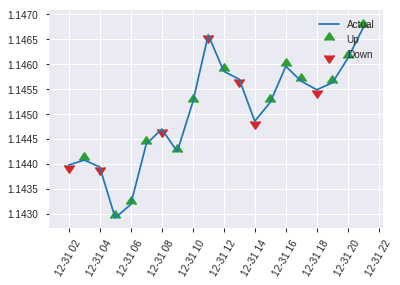


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1865851659864884
RMSE: 0.43195505088665
LogLoss: 0.5546794747660174
Mean Per-Class Error: 0.2684335193178229
AUC: 0.7956890198968313
pr_auc: 0.7950345338955714
Gini: 0.5913780397936625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4081159234046936: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      173  122  0.4136   (122.0/295.0)
1      51   271  0.1584   (51.0/322.0)
Total  224  393  0.2804   (173.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408116     0.758042  246
max f2                       0.178319     0.862445  353
max f0point5                 0.512847     0.742138  195
max accuracy                 0.499464     0.732577  202
max precision                0.898305     1         0
max recall                   0.0896791    1         391
max specificity              0.898305     1         0
max absolute_mcc             0.459548     0.464136  219
max min_per_class_accuracy   0.515473     0.725424  193
max mean_per_class_accuracy  0.499464     0.731566  202

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 48.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.855666           1.64241   1.64241            0.857143         0.873746  0.857143                    0.873746            0.0186335       0.0186335                  64.2413   64.2413
    2        0.0210697                   0.84218            1.91615   1.76875            1                0.848307  0.923077                    0.862005            0.0186335       0.0372671                  91.6149   76.8753
    3        0.0307942                   0.824354           1.59679   1.71445            0.833333         0.834151  0.894737                    0.853209            0.015528        0.052795                   59.6791   71.4449
    4        0.0405186                   0.819084           1.91615   1.76286            1                0.821217  0.92                        0.845531            0.0186335       0.0714286                  91.6149   76.2857
    5        0.0502431                   0.805705           1.59679   1.73072            0.833333         0.81463   0.903226                    0.83955             0.015528        0.0869565                  59.6791   73.0715
    6        0.100486                    0.764422           1.85434   1.79253            0.967742         0.783825  0.935484                    0.811687            0.0931677       0.180124                   85.4338   79.2527
    7        0.150729                    0.733778           1.54528   1.71011            0.806452         0.74943   0.892473                    0.790935            0.0776398       0.257764                   54.5282   71.0112
    8        0.200972                    0.708744           1.48347   1.65345            0.774194         0.720428  0.862903                    0.773308            0.0745342       0.332298                   48.347    65.3451
    9        0.299838                    0.649343           1.44496   1.58471            0.754098         0.681041  0.827027                    0.742885            0.142857        0.475155                   44.4965   58.4707
    10       0.400324                    0.597255           1.17441   1.48172            0.612903         0.622691  0.773279                    0.712715            0.118012        0.593168                   17.4414   48.1719
    11       0.50081                     0.526139           1.17441   1.42006            0.612903         0.562392  0.7411                      0.682553            0.118012        0.71118                    17.4414   42.0059
    12       0.599676                    0.431372           1.00519   1.35166            0.52459          0.480212  0.705405                    0.649194            0.0993789       0.810559                   0.519295  35.1662
    13       0.700162                    0.330388           0.741735  1.26413            0.387097         0.385648  0.659722                    0.61137             0.0745342       0.885093                   -25.8265  26.4126
    14       0.799028                    0.234744           0.471184  1.16601            0.245902         0.278513  0.608519                    0.570185            0.0465839       0.931677                   -52.8816  16.6014
    15       0.899514                    0.165293           0.525396  1.09445            0.274194         0.196486  0.571171                    0.528439            0.052795        0.984472                   -47.4604  9.44491
    16       1                           0.0580827          0.154528  1                  0.0806452        0.123104  0.52188                     0.487708         

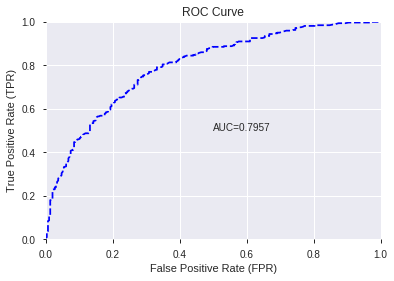

This function is available for GLM models only


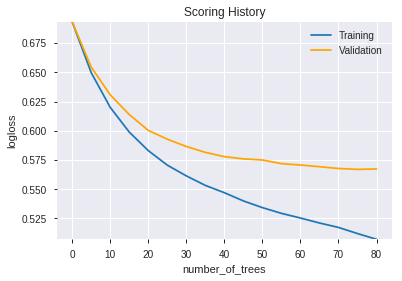

--2019-07-25 07:05:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_070255_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_070255_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190725_070626  0.771713  0.577469              0.288804  0.441272  0.194721
1  DeepLearning_grid_1_AutoML_20190725_070626_model_9  0.770192  0.578739              0.287809  0.442316  0.195643
2  DeepLearning_grid_1_AutoML_20190725_070626_model_6  0.766997  0.588884              0.344473  0.445299  0.198292
3  DeepLearning_grid_1_AutoML_20190725_070626_model_8  0.765949  0.590129              0.309285  0.447738  0.200469
4  DeepLearning_grid_1_AutoML_20190725_070626_model_5  0.758248  0.594259              0.311254  0.449410  0.201969
5  DeepLearning_grid_1_AutoML_20190725_070626_model_3  0.749837  0.672806              0.308848  0.457300  0.209123
6  DeepLearning_grid_1_AutoML_20190725_070626_model_4  0.749184  0.669093              0.319597  0.469096  0.220051
7  DeepLearning_grid_1_AutoML_20190725_070626_model_7  0.743015  0.660628              0.314786  0.467854  0.218887
8  DeepLearning_grid_1_AutoML_20190725_070626_model_2  0.738967  0.663689              0.321423  0.462820  0.214202
9  DeepLearning_grid_1_AutoML_20190725_070626_model_1  0.697537  0.882536              0.391931  0.501738  0.251741

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.032879
1        CDL3BLACKCROWS             0.881654           0.881654    0.028988
2          STOCHF_fastk             0.864293           0.864293    0.028417
3                   SUB             0.845536           0.845536    0.027801
4     CDLSTALLEDPATTERN             0.844433           0.844433    0.027764
5       CDLUNIQUE3RIVER             0.762048           0.762048    0.025056
6       CDLHOMINGPIGEON             0.732192           0.732192    0.024074
7             CDLONNECK             0.728481           0.728481    0.023952
8          CDLTHRUSTING             0.703709           0.703709    0.023137
9    CDLIDENTICAL3CROWS             0.690411           0.690411    0.022700
10     CDLDRAGONFLYDOJI             0.675892           0.675892    0.022223
11            CORREL_24             0.669092           0.669092    0.021999
12           AROONOSC_8             0.659945           0.659945    0.021699
13         weekday_name             0.658890           0.658890    0.021664
14               MFI_20             0.653446           0.653446    0.021485
15          CDLPIERCING             0.651220           0.651220    0.021412
16         CDLENGULFING             0.647677           0.647677    0.021295
17         is_month_end             0.647119           0.647119    0.021277
18       is_month_start             0.645189           0.645189    0.021213
19            PLUS_DI_8             0.632042           0.632042    0.020781
20             CORREL_8             0.621383           0.621383    0.020431
21            CORREL_30             0.619051           0.619051    0.020354
22    CDLDARKCLOUDCOVER             0.618164           0.618164    0.020325
23          STOCH_slowd             0.605591           0.605591    0.019911
24               SAREXT             0.601351           0.601351    0.019772
25       STOCHRSI_fastd             0.595933           0.595933    0.019594
26    CDL3WHITESOLDIERS             0.582823           0.582823    0.019163
27                  DIV             0.577550           0.577550    0.018989
28            PLUS_DM_8             0.572605           0.572605    0.018827
29        CDLHANGINGMAN             0.562554           0.562554    0.018496
30               TRANGE             0.555150           0.555150    0.018253
31               ULTOSC             0.537552           0.537552    0.017674
32            CDLTAKURI             0.532419           0.532419    0.017506
33             WILLR_12             0.531556           0.531556    0.017477
34         HT_TRENDMODE             0.525120           0.525120    0.017266
35  CDLGAPSIDESIDEWHITE             0.521583           0.521583    0.017149
36         CDLSHORTLINE             0.517048           0.517048    0.017000
37                  day             0.517019           0.517019    0.016999
38       STOCHRSI_fastk             0.515485           0.515485    0.016949
39                CCI_8             0.515350           0.515350    0.016944
40       CDLEVENINGSTAR             0.515263           0.515263    0.016942
41   CDLSEPARATINGLINES             0.504316           0.504316    0.016582
42                 hour             0.475521           0.475521    0.015635
43   CDLCLOSINGMARUBOZU             0.474796           0.474796    0.015611
44   CDLEVENINGDOJISTAR             0.473079           0.473079    0.015555
45              WILLR_8             0.467198           0.467198    0.015361
46          CDLLONGLINE             0.462916           0.462916    0.015220
47     is_quarter_start             0.444393           0.444393    0.014611
48       CDLMORNINGSTAR             0.431697           0.431697    0.014194
49            aroonup_8             0.346513           0.346513    0.011393

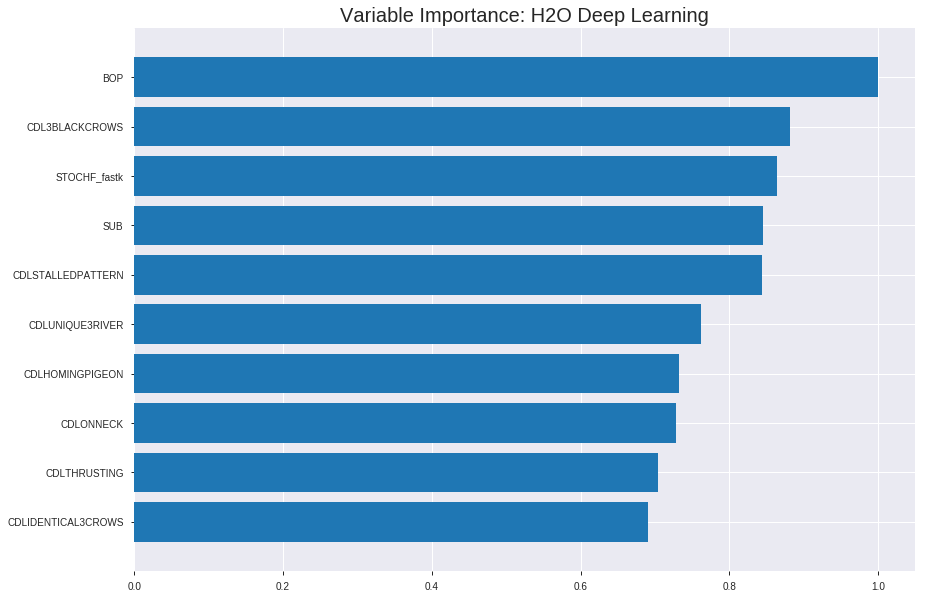

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190725_070626


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18963569835367305
RMSE: 0.4354718112044373
LogLoss: 0.5591843905083673
Mean Per-Class Error: 0.2890289025351802
AUC: 0.786036280312499
pr_auc: 0.756012338505022
Gini: 0.5720725606249979
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4163796731528178: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1255  1033  0.4515   (1033.0/2288.0)
1      319   1712  0.1571   (319.0/2031.0)
Total  1574  2745  0.313    (1352.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41638      0.716918  236
max f2                       0.182338     0.833473  334
max f0point5                 0.603934     0.710056  149
max accuracy                 0.603934     0.713823  149
max precision                0.999743     1         0
max recall                   0.0152483    1         396
max specificity              0.999743     1         0
max absolute_mcc             0.603934     0.427481  149
max min_per_class_accuracy   0.525817     0.709353  187
max mean_per_class_accuracy  0.512484     0.710971  192

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 49.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.971965           2.02988   2.02988            0.954545         0.983593   0.954545                    0.983593            0.0206795       0.0206795                  102.988   102.988
    2        0.0201436                   0.935734           1.92872   1.97988            0.906977         0.954419   0.931034                    0.969174            0.0192024       0.0398818                  92.8721   97.9881
    3        0.0300996                   0.908523           1.82981   1.93024            0.860465         0.919772   0.907692                    0.952833            0.0182176       0.0580995                  82.9812   93.0243
    4        0.0400556                   0.886355           1.82981   1.90528            0.860465         0.896399   0.895954                    0.938806            0.0182176       0.0763171                  82.9812   90.528
    5        0.0500116                   0.871908           1.87927   1.9001             0.883721         0.878101   0.893519                    0.926721            0.01871         0.0950271                  87.9267   90.0102
    6        0.100023                    0.793593           1.87057   1.88533            0.87963          0.825263   0.886574                    0.875992            0.09355         0.188577                   87.0566   88.5334
    7        0.150035                    0.755935           1.64413   1.80493            0.773148         0.774778   0.848765                    0.842254            0.0822255       0.270803                   64.4129   80.4932
    8        0.200046                    0.719846           1.61459   1.75735            0.759259         0.738541   0.826389                    0.816326            0.0807484       0.351551                   61.4594   75.7348
    9        0.300069                    0.652375           1.48661   1.6671             0.699074         0.685539   0.783951                    0.77273             0.148695        0.500246                   48.6608   66.7101
    10       0.400093                    0.584709           1.18141   1.54568            0.555556         0.618191   0.726852                    0.734095            0.118168        0.618415                   18.141    54.5679
    11       0.500116                    0.515181           1.03866   1.44427            0.488426         0.551293   0.679167                    0.697535            0.10389         0.722304                   3.86566   44.4274
    12       0.599907                    0.443031           0.88318   1.35094            0.415313         0.480079   0.635276                    0.661362            0.0881339       0.810438                   -11.682   35.0939
    13       0.699931                    0.363579           0.718691  1.26059            0.337963         0.40314    0.592789                    0.624461            0.0718858       0.882324                   -28.1309  26.0588
    14       0.799954                    0.266097           0.60055   1.17806            0.282407         0.315033   0.55398                     0.585771            0.0600689       0.942393                   -39.945   17.8059
    15       0.899977                    0.149172           0.398726  1.09144            0.1875           0.209643   0.513249                    0.543969            0.0398818       0.982275                   -60.1274  9.14445
    16       1                           7.27501e-06        0.177212  1                  0.0833333        0.0829466  0.470248                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2014622059730586
RMSE: 0.4488454143388998
LogLoss: 0.5966463005640622
Mean Per-Class Error: 0.2973814541622761
AUC: 0.7567202318229715
pr_auc: 0.7154384656779661
Gini: 0.5134404636459431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3729326252459684: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      302  348  0.5354   (348.0/650.0)
1      63   521  0.1079   (63.0/584.0)
Total  365  869  0.3331   (411.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372933     0.717137  263
max f2                       0.145014     0.826087  349
max f0point5                 0.548569     0.680575  180
max accuracy                 0.533861     0.699352  187
max precision                0.999924     1         0
max recall                   0.00667944   1         397
max specificity              0.999924     1         0
max absolute_mcc             0.471163     0.407472  216
max min_per_class_accuracy   0.535872     0.695385  186
max mean_per_class_accuracy  0.48475      0.702619  210

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 49.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.948368           1.95047   1.95047            0.923077         0.973055   0.923077                    0.973055            0.0205479       0.0205479                  95.0474   95.0474
    2        0.0202593                   0.908938           2.11301   2.02849            1                0.928357   0.96                        0.9516              0.0205479       0.0410959                  111.301   102.849
    3        0.0299838                   0.875005           1.76084   1.94169            0.833333         0.893376   0.918919                    0.932716            0.0171233       0.0582192                  76.0845   94.1688
    4        0.0405186                   0.850804           1.46286   1.81719            0.692308         0.863659   0.86                        0.914762            0.015411        0.0736301                  46.2856   81.7192
    5        0.0502431                   0.830308           1.58476   1.77221            0.75             0.840005   0.83871                     0.900293            0.015411        0.0890411                  58.476    77.2205
    6        0.100486                    0.783945           1.6018    1.687              0.758065         0.80666    0.798387                    0.853476            0.0804795       0.169521                   60.1801   68.7003
    7        0.149919                    0.757861           1.52414   1.6333             0.721311         0.771633   0.772973                    0.82649             0.0753425       0.244863                   52.4141   63.3302
    8        0.200162                    0.721301           1.6018    1.6254             0.758065         0.738686   0.769231                    0.80445             0.0804795       0.325342                   60.1801   62.5395
    9        0.299838                    0.648487           1.40868   1.55335            0.666667         0.68884    0.735135                    0.766018            0.140411        0.465753                   40.8676   55.3351
    10       0.400324                    0.588511           1.17579   1.45858            0.556452         0.617398   0.690283                    0.728712            0.118151        0.583904                   17.579    45.8578
    11       0.5                         0.528886           1.23689   1.41438            0.585366         0.559371   0.669368                    0.694954            0.123288        0.707192                   23.6886   41.4384
    12       0.599676                    0.451285           0.979201  1.34205            0.463415         0.485821   0.635135                    0.660193            0.0976027       0.804795                   -2.07985  34.2049
    13       0.700162                    0.37614            0.817941  1.26683            0.387097         0.419485   0.599537                    0.625647            0.0821918       0.886986                   -18.2059  26.683
    14       0.799838                    0.263748           0.446653  1.16462            0.211382         0.323878   0.551165                    0.58804             0.0445205       0.931507                   -55.3347  16.462
    15       0.899514                    0.145595           0.429474  1.08316            0.203252         0.203768   0.512613                    0.545459            0.0428082       0.974315                   -57.0526  8.31575
    16       1                           0.00327282         0.255606  1                  0.120968         0.0751884  0.473258                    0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:06:26  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 07:06:26  0.144 sec   70803 obs/sec     1         1             4319       0.480468         0.674296            0.073322       0.734911        0.687678           1.69156          0.36652                          0.491472           0.710608              0.0310499        0.708153          0.649811             1.6254             0.376013
    2019-07-25 07:06:27  0.858 sec   59326 obs/sec     10        10            43190      0.435472         0.559184            0.238762       0.786036        0.756012           2.02988          0.313035                         0.448845           0.596646              0.191839         0.75672           0.715438             1.95047            0.333063

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.032879323320215266
CDL3BLACKCROWS     0.8816543221473694     0.8816543221473694   0.028988197514548588
STOCHF_fastk       0.8642930388450623     0.8642930388450623   0.028417370267598177
SUB                0.845535933971405      0.845535933971405    0.027800649351906015
CDLSTALLEDPATTERN  0.8444331288337708     0.8444331288337708   0.027764389865226544
---                ---                    ---                  ---
WILLR_8            0.46719837188720703    0.46719837188720703  0.015361166323957651
CDLLONGLINE        0.4629160463809967     0.4629160463809967   0.015220366359076557
is_quarter_start   0.4443928599357605     0.4443928599357605   0.014611336523023008
CDLMORNINGSTAR     0.4316965639591217     0.4316965639591217   0.014193890902637953
aroonup_8          0.3465128540992737     0.3465128540992737   0.0113931081645406


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7212317666126418)

('F1', 0.7622950819672131)

('auc', 0.7717128118749342)

('logloss', 0.5774694076836159)

('mean_per_class_error', 0.28001368565112117)

('rmse', 0.4412719440917228)

('mse', 0.19472092864248855)

deeplearning prediction progress: |███████████████████████████████████████| 100%


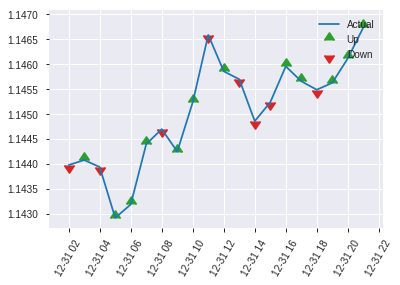


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19472092864248855
RMSE: 0.4412719440917228
LogLoss: 0.5774694076836159
Mean Per-Class Error: 0.28001368565112117
AUC: 0.7717128118749342
pr_auc: 0.7455389990770716
Gini: 0.5434256237498685
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41548146422735366: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      164  131  0.4441   (131.0/295.0)
1      43   279  0.1335   (43.0/322.0)
Total  207  410  0.282    (174.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415481     0.762295  257
max f2                       0.0695385    0.855473  382
max f0point5                 0.567974     0.735704  174
max accuracy                 0.501858     0.721232  208
max precision                0.998995     1         0
max recall                   0.0695385    1         382
max specificity              0.998995     1         0
max absolute_mcc             0.419666     0.44775   254
max min_per_class_accuracy   0.526116     0.715254  196
max mean_per_class_accuracy  0.501858     0.719986  208

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.962067           1.64241   1.64241            0.857143         0.978986   0.857143                    0.978986            0.0186335       0.0186335                  64.2413   64.2413
    2        0.0210697                   0.921894           1.91615   1.76875            1                0.925564   0.923077                    0.95433             0.0186335       0.0372671                  91.6149   76.8753
    3        0.0307942                   0.888145           0.958075  1.51275            0.5              0.910101   0.789474                    0.940363            0.00931677      0.0465839                  -4.19255  51.2749
    4        0.0405186                   0.872153           1.27743   1.45627            0.666667         0.879574   0.76                        0.925774            0.0124224       0.0590062                  27.7433   45.6273
    5        0.0502431                   0.856984           1.59679   1.48347            0.833333         0.866694   0.774194                    0.914339            0.015528        0.0745342                  59.6791   48.347
    6        0.100486                    0.798564           1.60709   1.54528            0.83871          0.823832   0.806452                    0.869085            0.0807453       0.15528                    60.7093   54.5282
    7        0.150729                    0.760881           1.60709   1.56589            0.83871          0.779482   0.817204                    0.839217            0.0807453       0.236025                   60.7093   56.5885
    8        0.200972                    0.733382           1.35985   1.51438            0.709677         0.74526    0.790323                    0.815728            0.068323        0.304348                   35.9848   51.4376
    9        0.299838                    0.6685             1.41355   1.48113            0.737705         0.700111   0.772973                    0.777606            0.139752        0.444099                   41.3553   48.1131
    10       0.400324                    0.60621            1.42166   1.4662             0.741935         0.635426   0.765182                    0.741917            0.142857        0.586957                   42.1659   46.6203
    11       0.50081                     0.533531           1.20532   1.41386            0.629032         0.569348   0.737864                    0.707291            0.121118        0.708075                   20.532    41.3858
    12       0.599676                    0.459988           0.942368  1.33613            0.491803         0.493954   0.697297                    0.672119            0.0931677       0.801242                   -5.76316  33.6126
    13       0.700162                    0.386957           0.834452  1.26413            0.435484         0.424241   0.659722                    0.636544            0.0838509       0.885093                   -16.5548  26.4126
    14       0.799028                    0.284453           0.502596  1.1699             0.262295         0.338168   0.610548                    0.599626            0.0496894       0.934783                   -49.7404  16.99
    15       0.899514                    0.158836           0.339962  1.07719            0.177419         0.220172   0.562162                    0.557236            0.0341615       0.968944                   -66.0038  7.71865
    16       1                           0.00101801         0.309056  1                  0.16129          0.0829909  0.52188                     0.

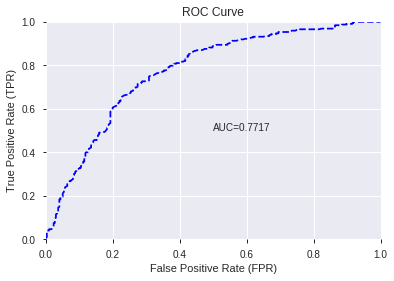

This function is available for GLM models only


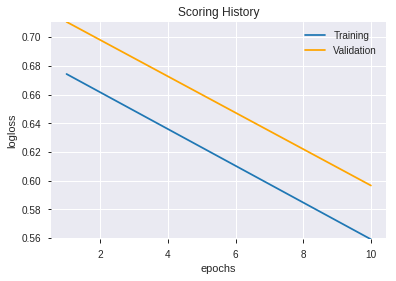

--2019-07-25 07:30:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190725_070626',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190725_070626',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_98e0'

['BOP',
 'CDL3BLACKCROWS',
 'STOCHF_fastk',
 'SUB',
 'CDLSTALLEDPATTERN',
 'CDLUNIQUE3RIVER',
 'CDLHOMINGPIGEON',
 'CDLONNECK',
 'CDLTHRUSTING',
 'CDLIDENTICAL3CROWS',
 'CDLDRAGONFLYDOJI',
 'CORREL_24',
 'AROONOSC_8',
 'weekday_name',
 'MFI_20',
 'CDLPIERCING',
 'CDLENGULFING',
 'is_month_end',
 'is_month_start',
 'PLUS_DI_8',
 'CORREL_8',
 'CORREL_30',
 'CDLDARKCLOUDCOVER',
 'STOCH_slowd',
 'SAREXT',
 'STOCHRSI_fastd',
 'CDL3WHITESOLDIERS',
 'DIV',
 'PLUS_DM_8',
 'CDLHANGINGMAN',
 'TRANGE',
 'ULTOSC',
 'CDLTAKURI',
 'WILLR_12',
 'HT_TRENDMODE',
 'CDLGAPSIDESIDEWHITE',
 'CDLSHORTLINE',
 'day',
 'STOCHRSI_fastk',
 'CCI_8',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'CDLEVENINGDOJISTAR',
 'WILLR_8',
 'CDLLONGLINE',
 'is_quarter_start',
 'CDLMORNINGSTAR',
 'aroonup_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_073152_model_1  0.781645  0.570042              0.285688  0.438941  0.192669

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.733531           1.000000    0.142621
1                 CCI_8             0.505901           0.689679    0.098363
2               WILLR_8             0.484026           0.659858    0.094110
3           STOCH_slowd             0.406062           0.553571    0.078951
4          STOCHF_fastk             0.300520           0.409690    0.058430
5                ULTOSC             0.263602           0.359361    0.051252
6         CDLHANGINGMAN             0.172073           0.234583    0.033456
7        STOCHRSI_fastk             0.151828           0.206983    0.029520
8                TRANGE             0.149604           0.203950    0.029088
9    CDLCLOSINGMARUBOZU             0.141218           0.192519    0.027457
10            CORREL_30             0.120742           0.164604    0.023476
11         CDLTHRUSTING             0.117464           0.160135    0.022839
12     CDLDRAGONFLYDOJI             0.101234           0.138009    0.019683
13                  SUB             0.099027           0.135000    0.019254
14      CDLHOMINGPIGEON             0.094694           0.129094    0.018411
15               MFI_20             0.092068           0.125514    0.017901
16    CDLDARKCLOUDCOVER             0.082124           0.111958    0.015967
17            PLUS_DI_8             0.078268           0.106700    0.015218
18            CDLTAKURI             0.077985           0.106314    0.015163
19            CDLONNECK             0.076791           0.104687    0.014931
20                  DIV             0.074207           0.101164    0.014428
21   CDLIDENTICAL3CROWS             0.062607           0.085351    0.012173
22       STOCHRSI_fastd             0.058857           0.080238    0.011444
23         CDLENGULFING             0.057518           0.078413    0.011183
24      CDLUNIQUE3RIVER             0.055835           0.076118    0.010856
25       CDL3BLACKCROWS             0.050243           0.068494    0.009769
26                 hour             0.046887           0.063920    0.009116
27         is_month_end             0.039765           0.054210    0.007731
28       is_month_start             0.036741           0.050088    0.007144
29               SAREXT             0.035697           0.048665    0.006941
30       CDLEVENINGSTAR             0.033770           0.046037    0.006566
31   CDLSEPARATINGLINES             0.031377           0.042775    0.006101
32          CDLLONGLINE             0.031256           0.042610    0.006077
33         CDLSHORTLINE             0.025369           0.034584    0.004932
34  CDLGAPSIDESIDEWHITE             0.025016           0.034103    0.004864
35    CDLSTALLEDPATTERN             0.024488           0.033384    0.004761
36   CDLEVENINGDOJISTAR             0.024453           0.033336    0.004754
37    CDL3WHITESOLDIERS             0.022512           0.030689    0.004377
38            CORREL_24             0.022290           0.030387    0.004334
39         weekday_name             0.021699           0.029581    0.004219
40             WILLR_12             0.019331           0.026353    0.003758
41     is_quarter_start             0.019168           0.026131    0.003727
42          CDLPIERCING             0.018586           0.025337    0.003614
43       CDLMORNINGSTAR             0.016837           0.022953    0.003274
44             CORREL_8             0.013486           0.018385    0.002622
45         HT_TRENDMODE             0.010456           0.014254    0.002033
46            PLUS_DM_8             0.008476           0.011556    0.001648
47            aroonup_8             0.005073           0.006915    0.000986
48           AROONOSC_8             0.001436           0.001957    0.000279
49                  day             0.001027           0.001400    0.000200

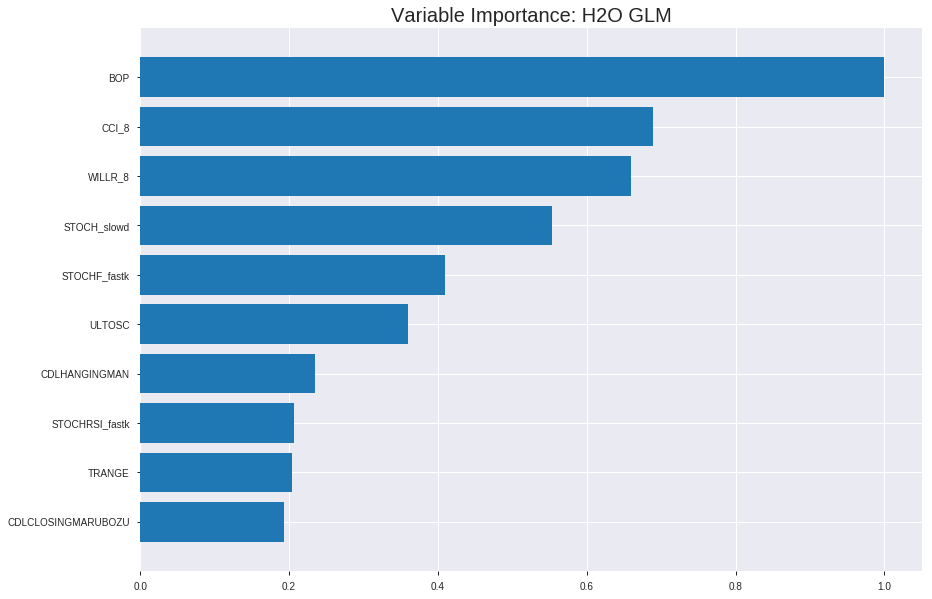

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_073152_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19199761481842606
RMSE: 0.4381753242920305
LogLoss: 0.565616638981544
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5972.1036478564565
Residual deviance: 4885.796527522577
AIC: 4987.796527522577
AUC: 0.7770227987177766
pr_auc: 0.7445277244551093
Gini: 0.5540455974355531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37532677138925885: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1288  1000  0.4371   (1000.0/2288.0)
1      344   1687  0.1694   (344.0/2031.0)
Total  1632  2687  0.3112   (1344.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375327     0.715134  247
max f2                       0.128153     0.82721   359
max f0point5                 0.514801     0.696427  182
max accuracy                 0.510313     0.711276  184
max precision                0.990029     1         0
max recall                   0.0406149    1         391
max specificity              0.990029     1         0
max absolute_mcc             0.510313     0.419232  184
max min_per_class_accuracy   0.480185     0.70542   199
max mean_per_class_accuracy  0.496636     0.708618  191

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.920339           1.98155   1.98155            0.931818         0.948181   0.931818                    0.948181            0.0201871       0.0201871                  98.1547   98.1547
    2        0.0201436                   0.89438            1.87927   1.93099            0.883721         0.907346   0.908046                    0.927998            0.01871         0.0388971                  87.9267   93.0995
    3        0.0300996                   0.873879           1.7309    1.86481            0.813953         0.885112   0.876923                    0.913813            0.0172329       0.05613                    73.0904   86.4811
    4        0.0400556                   0.858338           2.02763   1.90528            0.953488         0.86512    0.895954                    0.90171             0.0201871       0.0763171                  102.763   90.528
    5        0.0500116                   0.846486           1.87927   1.9001             0.883721         0.85246    0.893519                    0.891906            0.01871         0.0950271                  87.9267   90.0102
    6        0.100023                    0.791535           1.77212   1.83611            0.833333         0.81716    0.863426                    0.854533            0.0886263       0.183653                   77.2116   83.6109
    7        0.150035                    0.74204            1.60475   1.75899            0.75463          0.763645   0.82716                     0.824237            0.080256        0.263909                   60.4749   75.8989
    8        0.200046                    0.698267           1.53583   1.7032             0.722222         0.720359   0.800926                    0.798267            0.0768095       0.340719                   53.5833   70.32
    9        0.300069                    0.619977           1.46692   1.62444            0.689815         0.658049   0.763889                    0.751528            0.146726        0.487445                   46.6918   62.4439
    10       0.400093                    0.543681           1.23064   1.52599            0.578704         0.584332   0.717593                    0.709729            0.123092        0.610537                   23.0636   52.5988
    11       0.500116                    0.470533           1.08788   1.43837            0.511574         0.505615   0.676389                    0.668906            0.108813        0.71935                    8.7882    43.8367
    12       0.599907                    0.389696           0.927585  1.3534             0.436195         0.429967   0.636434                    0.62916             0.0925652       0.811915                   -7.24147  35.3401
    13       0.699931                    0.314923           0.723614  1.2634             0.340278         0.352461   0.594112                    0.589618            0.0723781       0.884293                   -27.6386  26.3402
    14       0.799954                    0.239877           0.531635  1.1719             0.25             0.278384   0.551085                    0.550703            0.0531758       0.937469                   -46.8365  17.1904
    15       0.899977                    0.153083           0.403649  1.08652            0.189815         0.198648   0.510934                    0.511575            0.0403742       0.977843                   -59.6351  8.65206
    16       1                           0.00277609         0.221514  1                  0.104167         0.0983944  0.470248                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19292099717648428
RMSE: 0.4392277281507672
LogLoss: 0.5668015548301358
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1707.2004406915303
Residual deviance: 1398.8662373207756
AIC: 1500.8662373207756
AUC: 0.7747286617492097
pr_auc: 0.7396099480996531
Gini: 0.5494573234984195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3498199667766436: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      340  310  0.4769   (310.0/650.0)
1      79   505  0.1353   (79.0/584.0)
Total  419  815  0.3152   (389.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34982      0.721944  258
max f2                       0.240862     0.833837  311
max f0point5                 0.526772     0.698198  175
max accuracy                 0.460255     0.713128  206
max precision                0.979227     1         0
max recall                   0.0889016    1         380
max specificity              0.979227     1         0
max absolute_mcc             0.452055     0.428939  210
max min_per_class_accuracy   0.473087     0.707192  201
max mean_per_class_accuracy  0.452055     0.714652  210

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.905512           2.11301   2.11301            1                0.939929  1                           0.939929            0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.884171           1.76084   1.94397            0.833333         0.895525  0.92                        0.918615            0.0171233       0.0393836                  76.0845   94.3973
    3        0.0299838                   0.867117           1.93693   1.94169            0.916667         0.875046  0.918919                    0.904485            0.0188356       0.0582192                  93.6929   94.1688
    4        0.0405186                   0.855201           1.78793   1.90171            0.846154         0.860095  0.9                         0.892943            0.0188356       0.0770548                  78.7935   90.1712
    5        0.0502431                   0.833072           2.11301   1.94261            1                0.840626  0.919355                    0.882817            0.0205479       0.0976027                  111.301   94.2609
    6        0.100486                    0.778364           1.63588   1.78925            0.774194         0.801257  0.846774                    0.842037            0.0821918       0.179795                   63.5882   78.9245
    7        0.149919                    0.734119           1.69734   1.75894            0.803279         0.756537  0.832432                    0.813845            0.0839041       0.263699                   69.7339   75.8941
    8        0.200162                    0.699733           1.39732   1.66817            0.66129          0.716202  0.789474                    0.789336            0.0702055       0.333904                   39.7316   66.8169
    9        0.299838                    0.621199           1.40868   1.5819             0.666667         0.658609  0.748649                    0.745878            0.140411        0.474315                   40.8676   58.1905
    10       0.400324                    0.542181           1.27803   1.50563            0.604839         0.582371  0.712551                    0.704836            0.128425        0.60274                    27.8032   50.5629
    11       0.5                         0.465737           1.21971   1.44863            0.577236         0.502856  0.685575                    0.664571            0.121575        0.724315                   21.9707   44.863
    12       0.599676                    0.397604           0.824591  1.3449             0.390244         0.429097  0.636486                    0.625431            0.0821918       0.806507                   -17.5409  34.4905
    13       0.700162                    0.314287           0.715698  1.2546             0.33871          0.355958  0.59375                     0.586757            0.0719178       0.878425                   -28.4302  25.4602
    14       0.799838                    0.228919           0.66998   1.18175            0.317073         0.270227  0.559271                    0.547311            0.0667808       0.945205                   -33.002   18.1746
    15       0.899514                    0.156194           0.360758  1.09077            0.170732         0.194564  0.516216                    0.508223            0.0359589       0.981164                   -63.9242  9.07719
    16       1                           0.0182096          0.187445  1                  0.0887097        0.102918  0.473258                    0.467495          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 07:31:52  0.000 sec   2            .2E2      51            1.3671230904540999  1.3678871826887853
     2019-07-25 07:31:52  0.019 sec   4            .12E2     51            1.3587508786676405  1.359529281333527
     2019-07-25 07:31:52  0.036 sec   6            .77E1     51            1.3467362234179212  1.3475205237147314
     2019-07-25 07:31:52  0.060 sec   8            .48E1     51            1.330372515192224   1.3311385187547697
     2019-07-25 07:31:52  0.079 sec   10           .3E1      51            1.3094955881521064  1.3101912357416945
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 07:31:53  0.340 sec   40           .24E-2    51            1.1305379167713154  1.1337270747958248
     2019-07-25 07:31:53  0.351 sec   41           .15E-2    51            1.1301626018606754  1.1340856175804257
     2019-07-25 07:31:53  0.360 sec   42           .91E-3    51            1.1299660349733074  1.1346243813306787
     2019-07-25 07:31:53  0.370 sec   43           .56E-3    51            1.1298713680918913  1.1352418734304157
     2019-07-25 07:31:53  0.379 sec   44           .35E-3    51            1.1298253470249042  1.135885171883977


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7325769854132901)

('F1', 0.7566807313642755)

('auc', 0.7816454363617223)

('logloss', 0.5700418511266263)

('mean_per_class_error', 0.270281082219181)

('rmse', 0.4389410081340618)

('mse', 0.19266920862174647)

glm prediction progress: |████████████████████████████████████████████████| 100%


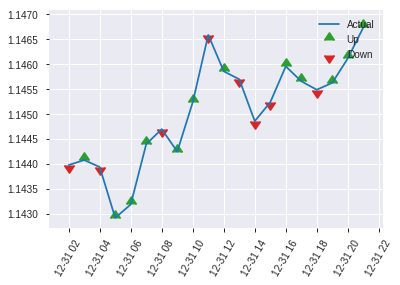


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19266920862174647
RMSE: 0.4389410081340618
LogLoss: 0.5700418511266263
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 860.749207800923
Residual deviance: 703.4316442902568
AIC: 805.4316442902568
AUC: 0.7816454363617223
pr_auc: 0.7673883101003667
Gini: 0.5632908727234447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38417588257759006: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      175  120  0.4068   (120.0/295.0)
1      53   269  0.1646   (53.0/322.0)
Total  228  389  0.2804   (173.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384176     0.756681  246
max f2                       0.135714     0.855441  353
max f0point5                 0.497515     0.740988  189
max accuracy                 0.431135     0.732577  225
max precision                0.967122     1         0
max recall                   0.0536616    1         388
max specificity              0.967122     1         0
max absolute_mcc             0.431135     0.464302  225
max min_per_class_accuracy   0.474573     0.720497  201
max mean_per_class_accuracy  0.431135     0.729719  225

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 47.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.923992           1.64241   1.64241            0.857143         0.937481   0.857143                    0.937481            0.0186335       0.0186335                  64.2413   64.2413
    2        0.0210697                   0.903158           1.59679   1.62136            0.833333         0.911445   0.846154                    0.925464            0.015528        0.0341615                  59.6791   62.1357
    3        0.0307942                   0.865972           1.59679   1.6136             0.833333         0.88563    0.842105                    0.912885            0.015528        0.0496894                  59.6791   61.3599
    4        0.0405186                   0.847659           1.59679   1.60957            0.833333         0.851381   0.84                        0.898124            0.015528        0.0652174                  59.6791   60.9565
    5        0.0502431                   0.839551           1.91615   1.6689             1                0.84258    0.870968                    0.887373            0.0186335       0.0838509                  91.6149   66.8904
    6        0.100486                    0.790762           1.48347   1.57619            0.774194         0.815651   0.822581                    0.851512            0.0745342       0.158385                   48.347    57.6187
    7        0.150729                    0.73912            1.73072   1.6277             0.903226         0.760421   0.849462                    0.821149            0.0869565       0.245342                   73.0715   62.7697
    8        0.200972                    0.70488            1.42166   1.57619            0.741935         0.718462   0.822581                    0.795477            0.0714286       0.31677                    42.1659   57.6187
    9        0.299838                    0.642099           1.41355   1.52256            0.737705         0.671289   0.794595                    0.754528            0.139752        0.456522                   41.3553   52.2562
    10       0.400324                    0.559872           1.26713   1.45845            0.66129          0.605325   0.761134                    0.717077            0.127329        0.583851                   26.7131   45.8445
    11       0.50081                     0.479134           1.26713   1.42006            0.66129          0.520112   0.7411                      0.677556            0.127329        0.71118                    26.7131   42.0059
    12       0.599676                    0.402996           0.973781  1.34648            0.508197         0.446      0.702703                    0.639381            0.0962733       0.807453                   -2.62193  34.6483
    13       0.700162                    0.323411           0.618113  1.24195            0.322581         0.363401   0.648148                    0.599773            0.0621118       0.869565                   -38.1887  24.1948
    14       0.799028                    0.238316           0.69107   1.17379            0.360656         0.280554   0.612576                    0.560275            0.068323        0.937888                   -30.893   17.3787
    15       0.899514                    0.137634           0.370868  1.08409            0.193548         0.191253   0.565766                    0.519051            0.0372671       0.975155                   -62.9132  8.40915
    16       1                           0.00405746         0.247245  1                  0.129032         0.0862931  0.52188                    

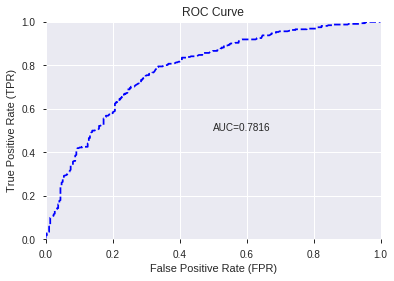

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


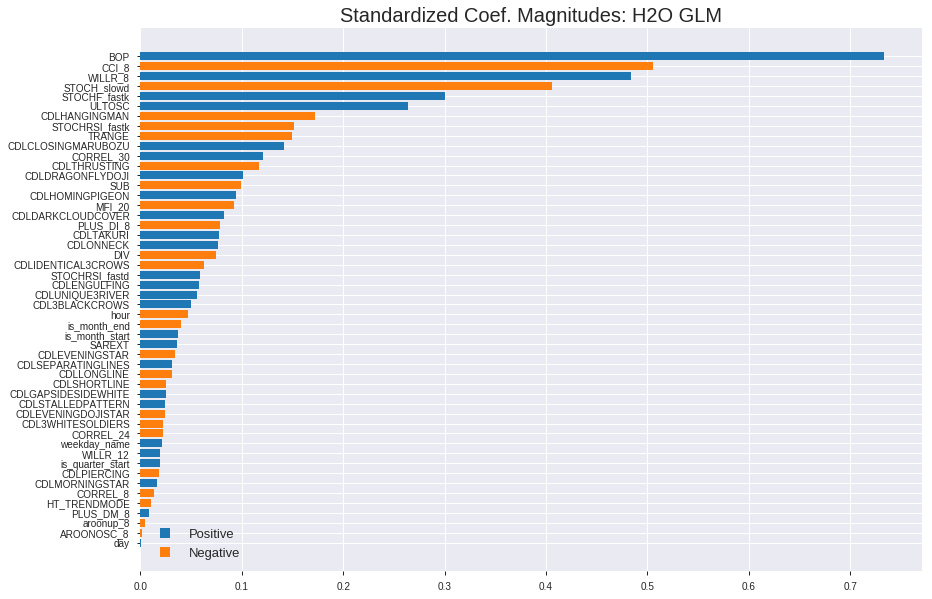

'log_likelihood'
--2019-07-25 07:32:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_073152_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_073152_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CCI_8',
 'WILLR_8',
 'STOCH_slowd',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLHANGINGMAN',
 'STOCHRSI_fastk',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CORREL_30',
 'CDLTHRUSTING',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'CDLHOMINGPIGEON',
 'MFI_20',
 'CDLDARKCLOUDCOVER',
 'PLUS_DI_8',
 'CDLTAKURI',
 'CDLONNECK',
 'DIV',
 'CDLIDENTICAL3CROWS',
 'STOCHRSI_fastd',
 'CDLENGULFING',
 'CDLUNIQUE3RIVER',
 'CDL3BLACKCROWS',
 'hour',
 'is_month_end',
 'is_month_start',
 'SAREXT',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CORREL_24',
 'weekday_name',
 'WILLR_12',
 'is_quarter_start',
 'CDLPIERCING',
 'CDLMORNINGSTAR',
 'CORREL_8',
 'HT_TRENDMODE',
 'PLUS_DM_8',
 'aroonup_8',
 'AROONOSC_8',
 'day']

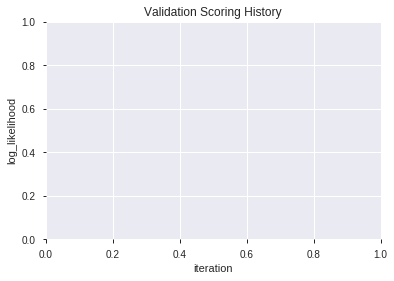

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_073300_model_2  0.799968  0.550251              0.293757  0.429836  0.184759
1  XGBoost_grid_1_AutoML_20190725_073300_model_6  0.796168  0.553746              0.299968  0.431541  0.186228
2               XGBoost_2_AutoML_20190725_073300  0.795468  0.552889              0.274534  0.431803  0.186454
3  XGBoost_grid_1_AutoML_20190725_073300_model_1  0.795236  0.555146              0.289515  0.432831  0.187342
4  XGBoost_grid_1_AutoML_20190725_073300_model_4  0.795094  0.555141              0.304911  0.432504  0.187059
5  XGBoost_grid_1_AutoML_20190725_073300_model_5  0.793426  0.554258              0.286825  0.432338  0.186916
6               XGBoost_3_AutoML_20190725_073300  0.792462  0.557155              0.288246  0.433645  0.188048
7  XGBoost_grid_1_AutoML_20190725_073300_model_3  0.791615  0.559318              0.278340  0.434378  0.188684
8               XGBoost_1_AutoML_20190725_073300  0.790810  0.556813              0.297137  0.433388  0.187825
9  XGBoost_grid_1_AutoML_20190725_073300_model_7  0.784814  0.563836              0.278482  0.437682  0.191566

variable  relative_importance  scaled_importance  percentage
0                   BOP          6412.995605           1.000000    0.375208
1          STOCHF_fastk          1148.421265           0.179077    0.067191
2                  hour          1047.160645           0.163287    0.061267
3                 CCI_8           667.903564           0.104148    0.039077
4                   DIV           596.754028           0.093054    0.034915
5                ULTOSC           555.371399           0.086601    0.032493
6                TRANGE           554.444824           0.086456    0.032439
7        STOCHRSI_fastk           472.157166           0.073625    0.027625
8               WILLR_8           456.846161           0.071238    0.026729
9             aroonup_8           432.133270           0.067384    0.025283
10       STOCHRSI_fastd           430.708252           0.067162    0.025200
11                  SUB           427.246033           0.066622    0.024997
12          STOCH_slowd           389.543060           0.060743    0.022791
13            PLUS_DI_8           373.076752           0.058175    0.021828
14               MFI_20           363.092102           0.056618    0.021244
15               SAREXT           351.894043           0.054872    0.020588
16            PLUS_DM_8           284.166840           0.044311    0.016626
17             WILLR_12           255.004059           0.039764    0.014920
18            CORREL_30           249.084824           0.038841    0.014573
19     CDLDRAGONFLYDOJI           241.775894           0.037701    0.014146
20                  day           211.046555           0.032909    0.012348
21           AROONOSC_8           199.323639           0.031081    0.011662
22         weekday_name           189.568726           0.029560    0.011091
23   CDLCLOSINGMARUBOZU           187.443253           0.029229    0.010967
24            CORREL_24           171.828934           0.026794    0.010053
25        CDLHANGINGMAN           127.005661           0.019804    0.007431
26            CDLTAKURI            85.592010           0.013347    0.005008
27         CDLSHORTLINE            43.595306           0.006798    0.002551
28         CDLENGULFING            27.310078           0.004259    0.001598
29  CDLGAPSIDESIDEWHITE            24.558411           0.003829    0.001437
30         is_month_end            23.711365           0.003697    0.001387
31          CDLLONGLINE            18.499523           0.002885    0.001082
32   CDLEVENINGDOJISTAR            17.802818           0.002776    0.001042
33          CDLPIERCING            17.033087           0.002656    0.000997
34         HT_TRENDMODE            14.643128           0.002283    0.000857
35       CDLMORNINGSTAR             9.467525           0.001476    0.000554
36     is_quarter_start             3.811646           0.000594    0.000223
37    CDLSTALLEDPATTERN             3.658209           0.000570    0.000214
38             CORREL_8             2.352747           0.000367    0.000138
39    CDL3WHITESOLDIERS             1.960279           0.000306    0.000115
40   CDLIDENTICAL3CROWS             1.833505           0.000286    0.000107

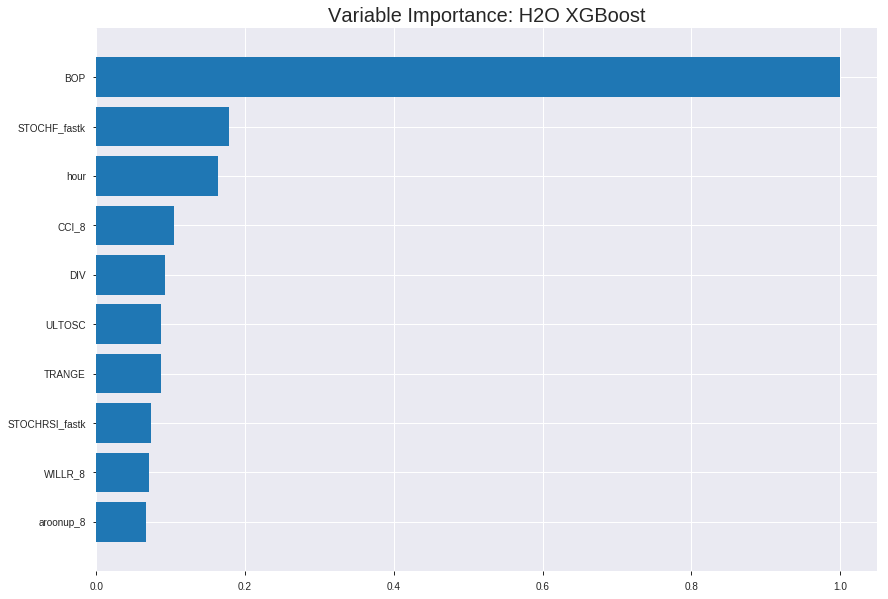

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_073300_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16311252967448264
RMSE: 0.4038719223646064
LogLoss: 0.498778314234399
Mean Per-Class Error: 0.23726728711957668
AUC: 0.8517061163848461
pr_auc: 0.8374630827318714
Gini: 0.7034122327696921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42070245146751406: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1516  772   0.3374   (772.0/2288.0)
1      304   1727  0.1497   (304.0/2031.0)
Total  1820  2499  0.2491   (1076.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420702     0.762472  232
max f2                       0.282713     0.855304  294
max f0point5                 0.581676     0.766679  151
max accuracy                 0.528182     0.764992  179
max precision                0.90476      1         0
max recall                   0.0811608    1         393
max specificity              0.90476      1         0
max absolute_mcc             0.528182     0.527575  179
max min_per_class_accuracy   0.500716     0.761364  193
max mean_per_class_accuracy  0.528182     0.762733  179

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 46.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.869707           2.12654    2.12654            1                0.883647  1                           0.883647            0.0216642       0.0216642                  112.654   112.654
    2        0.0201436                   0.852518           2.07708    2.1021             0.976744         0.86067   0.988506                    0.872291            0.0206795       0.0423437                  107.708   110.21
    3        0.0300996                   0.841553           2.12654    2.11018            1                0.846674  0.992308                    0.863818            0.0211718       0.0635155                  112.654   111.018
    4        0.0400556                   0.828902           2.07708    2.10195            0.976744         0.835238  0.988439                    0.856714            0.0206795       0.084195                   107.708   110.195
    5        0.0500116                   0.817143           1.97818    2.07731            0.930233         0.823563  0.976852                    0.850115            0.0196947       0.10389                    97.8175   107.731
    6        0.100023                    0.769812           2.01824    2.04778            0.949074         0.794716  0.962963                    0.822415            0.100935        0.204825                   101.824   104.778
    7        0.150035                    0.733301           1.9001     1.99855            0.893519         0.75161   0.939815                    0.798814            0.0950271       0.299852                   90.0102   99.8553
    8        0.200046                    0.694623           1.73274    1.9321             0.814815         0.714242  0.908565                    0.777671            0.0866568       0.386509                   73.2735   93.2098
    9        0.300069                    0.624573           1.56537    1.80986            0.736111         0.660062  0.85108                     0.738468            0.156573        0.543082                   56.5369   80.9855
    10       0.400093                    0.5587             1.28478    1.67859            0.604167         0.593342  0.789352                    0.702186            0.128508        0.67159                    28.4784   67.8587
    11       0.500116                    0.487247           1.05835    1.55454            0.497685         0.524648  0.731019                    0.666679            0.105859        0.77745                    5.83468   55.4539
    12       0.599907                    0.400139           0.85851    1.43876            0.403712         0.445651  0.676573                    0.629912            0.0856721       0.863122                   -14.149   43.8758
    13       0.699931                    0.308291           0.708846   1.33445            0.333333         0.35363   0.627522                    0.59043             0.070901        0.934023                   -29.1154  33.445
    14       0.799954                    0.221257           0.374113   1.21437            0.175926         0.262106  0.571056                    0.549378            0.03742         0.971443                   -62.5887  21.4374
    15       0.899977                    0.153091           0.241205   1.10622            0.113426         0.187339  0.520196                    0.509141            0.024126        0.995569                   -75.8795  10.6216
    16       1                           0.0641787          0.0443029  1                  0.0208333        0.117077  0.470248                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1907504003195683
RMSE: 0.43674981433260884
LogLoss: 0.5623951878400514
Mean Per-Class Error: 0.27823761854583773
AUC: 0.7806704425711275
pr_auc: 0.7405363943490773
Gini: 0.561340885142255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4403640180826187: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      420  230  0.3538   (230.0/650.0)
1      125  459  0.214    (125.0/584.0)
Total  545  689  0.2877   (355.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440364     0.721131  219
max f2                       0.210232     0.841584  329
max f0point5                 0.513334     0.703984  184
max accuracy                 0.513334     0.719611  184
max precision                0.91544      1         0
max recall                   0.11689      1         382
max specificity              0.91544      1         0
max absolute_mcc             0.472719     0.443604  205
max min_per_class_accuracy   0.500638     0.717466  191
max mean_per_class_accuracy  0.472719     0.721762  205

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.871228           1.78793   1.78793            0.846154         0.88914   0.846154                    0.88914             0.0188356       0.0188356                  78.7935   78.7935
    2        0.0202593                   0.854543           2.11301   1.94397            1                0.862201  0.92                        0.876209            0.0205479       0.0393836                  111.301   94.3973
    3        0.0299838                   0.838722           1.93693   1.94169            0.916667         0.846487  0.918919                    0.86657             0.0188356       0.0582192                  93.6929   94.1688
    4        0.0405186                   0.819083           1.95047   1.94397            0.923077         0.82962   0.92                        0.856963            0.0205479       0.0787671                  95.0474   94.3973
    5        0.0502431                   0.807059           1.76084   1.90853            0.833333         0.813091  0.903226                    0.848472            0.0171233       0.0958904                  76.0845   90.8529
    6        0.100486                    0.759608           1.63588   1.77221            0.774194         0.782683  0.83871                     0.815577            0.0821918       0.178082                   63.5882   77.2205
    7        0.149919                    0.729599           1.73198   1.75894            0.819672         0.744623  0.832432                    0.792182            0.0856164       0.263699                   73.1978   75.8941
    8        0.200162                    0.687538           1.4314    1.67672            0.677419         0.708649  0.793522                    0.771214            0.0719178       0.335616                   43.1396   67.6723
    9        0.299838                    0.624878           1.40868   1.58762            0.666667         0.656546  0.751351                    0.733095            0.140411        0.476027                   40.8676   58.7616
    10       0.400324                    0.552851           1.36323   1.53129            0.645161         0.590348  0.724696                    0.697263            0.136986        0.613014                   36.3235   53.1293
    11       0.5                         0.489527           1.16817   1.4589             0.552846         0.523617  0.690438                    0.662647            0.116438        0.729452                   16.817    45.8904
    12       0.599676                    0.404723           0.807412  1.35062            0.382114         0.449179  0.639189                    0.627165            0.0804795       0.809932                   -19.2588  35.0616
    13       0.700162                    0.313917           0.8009    1.27172            0.379032         0.356974  0.601852                    0.588388            0.0804795       0.890411                   -19.91    27.1721
    14       0.799838                    0.21964            0.652801  1.19459            0.308943         0.267165  0.56535                     0.548357            0.0650685       0.955479                   -34.7199  19.4591
    15       0.899514                    0.156307           0.292043  1.09458            0.138211         0.185339  0.518018                    0.50813             0.0291096       0.984589                   -70.7957  9.45792
    16       1                           0.0701928          0.153364  1                  0.0725806        0.123199  0.473258                    0.46945          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:33:10  1.617 sec   0                  0.5              0.693147            0.5             0                  1                0.529752                         0.5                0.693147              0.5               0                    1                  0.526742
    2019-07-25 07:33:10  1.714 sec   5                  0.479363         0.652546            0.792305        0.741014           1.9361           0.299606                         0.481467           0.656603              0.76306           0.697209             1.87823            0.331442
    2019-07-25 07:33:10  1.788 sec   10                 0.464099         0.622917            0.797702        0.758441           1.95777          0.292429                         0.46903            0.63221               0.762762          0.71294              1.96208            0.311183
    2019-07-25 07:33:11  1.869 sec   15                 0.452858         0.600942            0.802738        0.770891           2.00385          0.285714                         0.459991           0.614202              0.766861          0.722098             1.95047            0.32577
    2019-07-25 07:33:11  1.971 sec   20                 0.444473         0.584218            0.807081        0.778053           2.02988          0.279231                         0.454169           0.602288              0.768271          0.726294             1.95047            0.329822
    2019-07-25 07:33:11  2.076 sec   25                 0.438328         0.571693            0.810917        0.785544           1.98155          0.284788                         0.449843           0.59324               0.770813          0.727879             1.78793            0.32577
    2019-07-25 07:33:11  2.183 sec   30                 0.433316         0.561189            0.814489        0.791764           2.07821          0.279463                         0.44663            0.586267              0.772547          0.730649             1.78793            0.317666
    2019-07-25 07:33:11  2.275 sec   35                 0.429085         0.552236            0.818177        0.795916           2.07821          0.276221                         0.444337           0.581156              0.774062          0.733242             1.78793            0.296596
    2019-07-25 07:33:11  2.367 sec   40                 0.425671         0.544849            0.821575        0.801055           2.07821          0.268349                         0.442789           0.577487              0.774805          0.735517             1.78793            0.300648
    2019-07-25 07:33:11  2.474 sec   45                 0.422388         0.537884            0.826097        0.806379           2.07821          0.267655                         0.441333           0.574082              0.776387          0.737741             1.95047            0.3047
    2019-07-25 07:33:11  2.571 sec   50                 0.419961         0.532522            0.828793        0.810405           2.07821          0.268118                         0.44006            0.571059              0.778118          0.739048             1.95047            0.305511
    2019-07-25 07:33:11  2.670 sec   55                 0.417099         0.526443            0.83266         0.815723           2.07821          0.267423                         0.439282           0.569061              0.778405          0.739

Variable Importances: 


variable            relative_importance    scaled_importance       percentage
------------------  ---------------------  ----------------------  ----------------------
BOP                 6412.99560546875       1.0                     0.37520833262032777
STOCHF_fastk        1148.4212646484375     0.17907719501150274     0.06719125575059123
hour                1047.16064453125       0.16328728552975658     0.061266750141719346
CCI_8               667.903564453125       0.10414845191591324     0.03907736698835819
DIV                 596.7540283203125      0.09305386515646824     0.03491458558923527
---                 ---                    ---                     ---
is_quarter_start    3.8116455078125        0.0005943627194383353   0.00022300984493214148
CDLSTALLEDPATTERN   3.6582088470458984     0.0005704368242395679   0.00021403264968816323
CORREL_8            2.3527469635009766     0.0003668717567020702   0.00013765334011767432
CDL3WHITESOLDIERS   1.9602785110473633     0.00030567282930549884  0.00011469099261105428
CDLIDENTICAL3CROWS  1.8335046768188477     0.0002859045584337072   0.00010727377265846235


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7341977309562399)

('F1', 0.7671957671957672)

('auc', 0.799968417728182)

('logloss', 0.5502513431101155)

('mean_per_class_error', 0.2638961995999578)

('rmse', 0.4298358877134162)

('mse', 0.18475889036638052)

xgboost prediction progress: |████████████████████████████████████████████| 100%


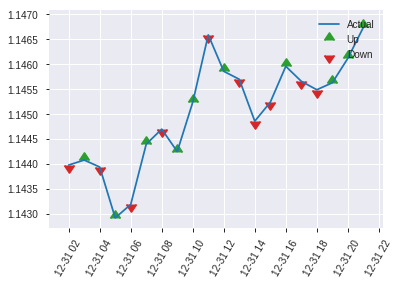


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18475889036638052
RMSE: 0.4298358877134162
LogLoss: 0.5502513431101155
Mean Per-Class Error: 0.2638961995999578
AUC: 0.799968417728182
pr_auc: 0.7909738250234943
Gini: 0.5999368354563639
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3237033188343048: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  144  0.4881   (144.0/295.0)
1      32   290  0.0994   (32.0/322.0)
Total  183  434  0.2853   (176.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323703     0.767196  282
max f2                       0.194231     0.863309  339
max f0point5                 0.525485     0.756445  181
max accuracy                 0.525485     0.734198  181
max precision                0.901811     1         0
max recall                   0.0698494    1         397
max specificity              0.901811     1         0
max absolute_mcc             0.525485     0.4728    181
max min_per_class_accuracy   0.49133      0.722034  201
max mean_per_class_accuracy  0.525485     0.736104  181

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.87338            1.64241   1.64241            0.857143         0.886488  0.857143                    0.886488            0.0186335       0.0186335                  64.2413   64.2413
    2        0.0210697                   0.851144           1.91615   1.76875            1                0.859252  0.923077                    0.873918            0.0186335       0.0372671                  91.6149   76.8753
    3        0.0307942                   0.840311           1.91615   1.8153             1                0.849104  0.947368                    0.866082            0.0186335       0.0559006                  91.6149   81.5299
    4        0.0405186                   0.828018           1.91615   1.8395             1                0.833179  0.96                        0.858185            0.0186335       0.0745342                  91.6149   83.9503
    5        0.0502431                   0.817736           1.59679   1.79253            0.833333         0.821658  0.935484                    0.851115            0.015528        0.0900621                  59.6791   79.2527
    6        0.100486                    0.7713             1.6689    1.73072            0.870968         0.792797  0.903226                    0.821956            0.0838509       0.173913                   66.8904   73.0715
    7        0.150729                    0.738888           1.48347   1.6483             0.774194         0.751347  0.860215                    0.79842             0.0745342       0.248447                   48.347    64.83
    8        0.200972                    0.701959           1.48347   1.60709            0.774194         0.719927  0.83871                     0.778796            0.0745342       0.322981                   48.347    60.7093
    9        0.299838                    0.64606            1.50779   1.57435            0.786885         0.670293  0.821622                    0.74302             0.149068        0.47205                    50.7789   57.435
    10       0.400324                    0.572561           1.29804   1.50499            0.677419         0.61286   0.785425                    0.710348            0.130435        0.602484                   29.8036   50.4992
    11       0.50081                     0.498774           1.1126    1.42626            0.580645         0.536081  0.744337                    0.675382            0.111801        0.714286                   11.2603   42.626
    12       0.599676                    0.420167           0.942368  1.34648            0.491803         0.457015  0.702703                    0.639381            0.0931677       0.807453                   -5.76316  34.6483
    13       0.700162                    0.328131           0.896263  1.28187            0.467742         0.375845  0.668981                    0.601558            0.0900621       0.897516                   -10.3737  28.1868
    14       0.799028                    0.229203           0.471184  1.18156            0.245902         0.267945  0.616633                    0.56028             0.0465839       0.944099                   -52.8816  18.156
    15       0.899514                    0.156079           0.309056  1.08409            0.16129          0.187614  0.565766                    0.518648            0.0310559       0.975155                   -69.0944  8.40915
    16       1                           0.0642276          0.247245  1                  0.129032         0.118942  0.52188                     0.478483            0.

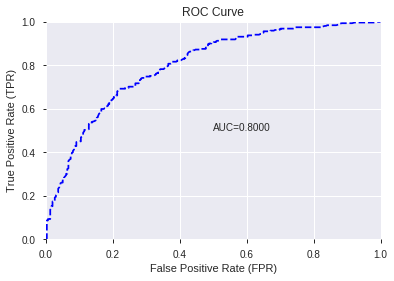

This function is available for GLM models only


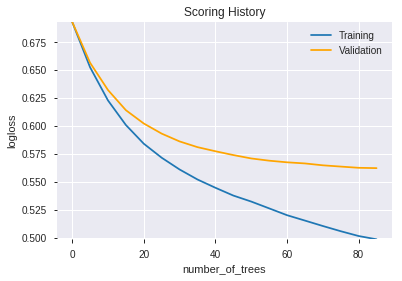

--2019-07-25 07:33:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_073300_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_073300_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'hour',
 'CCI_8',
 'DIV',
 'ULTOSC',
 'TRANGE',
 'STOCHRSI_fastk',
 'WILLR_8',
 'aroonup_8',
 'STOCHRSI_fastd',
 'SUB',
 'STOCH_slowd',
 'PLUS_DI_8',
 'MFI_20',
 'SAREXT',
 'PLUS_DM_8',
 'WILLR_12',
 'CORREL_30',
 'CDLDRAGONFLYDOJI',
 'day',
 'AROONOSC_8',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'CORREL_24',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLGAPSIDESIDEWHITE',
 'is_month_end',
 'CDLLONGLINE',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'HT_TRENDMODE',
 'CDLMORNINGSTAR',
 'is_quarter_start',
 'CDLSTALLEDPATTERN',
 'CORREL_8',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 935] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


62

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_073438_model_6  0.769386  0.586874              0.317049  0.447012  0.199820
1               DeepLearning_1_AutoML_20190725_073438  0.766644  0.590773              0.273529  0.447594  0.200340
2  DeepLearning_grid_1_AutoML_20190725_073438_model_8  0.762686  0.593602              0.338951  0.449654  0.202189
3  DeepLearning_grid_1_AutoML_20190725_073438_model_2  0.762617  0.604384              0.323697  0.451836  0.204156
4  DeepLearning_grid_1_AutoML_20190725_073438_model_9  0.758301  0.588527              0.304748  0.448572  0.201216
5  DeepLearning_grid_1_AutoML_20190725_073438_model_3  0.756269  0.650054              0.342626  0.452860  0.205082
6  DeepLearning_grid_1_AutoML_20190725_073438_model_5  0.755122  0.590998              0.356053  0.448910  0.201520
7  DeepLearning_grid_1_AutoML_20190725_073438_model_4  0.751174  0.604875              0.336567  0.451838  0.204158
8  DeepLearning_grid_1_AutoML_20190725_073438_model_7  0.748800  0.615315              0.327645  0.458689  0.210395
9  DeepLearning_grid_1_AutoML_20190725_073438_model_1  0.728829  0.757972              0.325097  0.477366  0.227878

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.046091
1   CDLCLOSINGMARUBOZU             0.887526           0.887526    0.040907
2          CDLLONGLINE             0.805259           0.805259    0.037115
3         CDLSHORTLINE             0.613890           0.613890    0.028295
4        CDLHANGINGMAN             0.547087           0.547087    0.025216
..                 ...                  ...                ...         ...
57             ROCR_12             0.251490           0.251490    0.011591
58              RSI_12             0.251404           0.251404    0.011587
59              ROC_12             0.248406           0.248406    0.011449
60              ROC_14             0.247100           0.247100    0.011389
61              ROCR_8             0.246609           0.246609    0.011366

[62 rows x 4 columns]

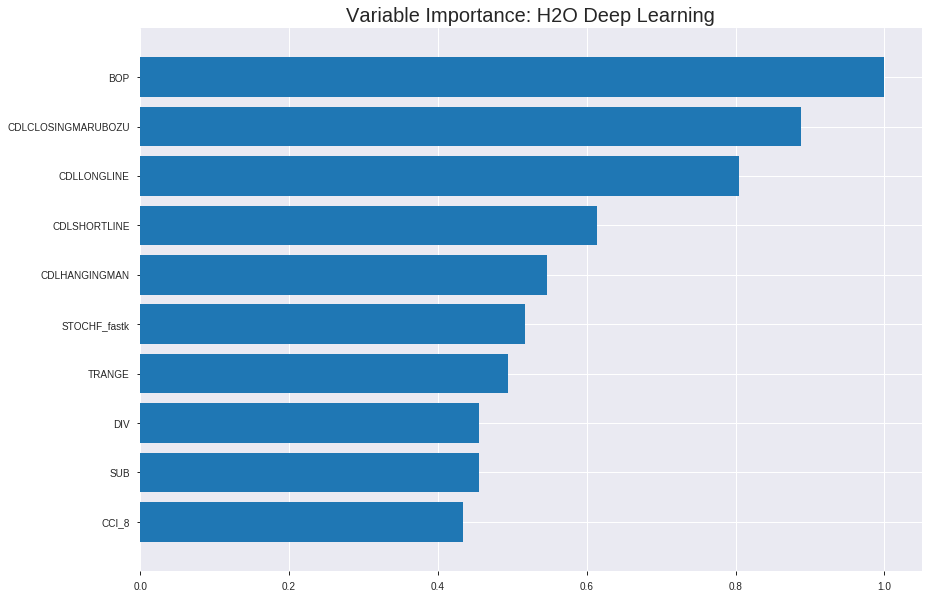

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_073438_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1938762663032661
RMSE: 0.44031382706345495
LogLoss: 0.5725193633285214
Mean Per-Class Error: 0.2952326784490743
AUC: 0.7730332813419963
pr_auc: 0.7439025191369033
Gini: 0.5460665626839927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3915737713240244: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1225  1063  0.4646   (1063.0/2288.0)
1      326   1705  0.1605   (326.0/2031.0)
Total  1551  2768  0.3216   (1389.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391574     0.710565  247
max f2                       0.170557     0.826412  343
max f0point5                 0.542505     0.693698  173
max accuracy                 0.496843     0.706182  194
max precision                0.988303     1         0
max recall                   0.0323985    1         395
max specificity              0.988303     1         0
max absolute_mcc             0.496843     0.409656  194
max min_per_class_accuracy   0.478811     0.70261   202
max mean_per_class_accuracy  0.491409     0.704767  197

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.956474           1.93322   1.93322            0.909091         0.96821    0.909091                    0.96821             0.0196947       0.0196947                  93.3217   93.3217
    2        0.0201436                   0.946505           1.87927   1.90655            0.883721         0.951012   0.896552                    0.95971             0.01871         0.0384047                  87.9267   90.6552
    3        0.0300996                   0.933501           1.92872   1.91388            0.906977         0.939584   0.9                         0.953053            0.0192024       0.0576071                  92.8721   91.3885
    4        0.0400556                   0.919186           1.87927   1.90528            0.883721         0.926692   0.895954                    0.946501            0.01871         0.0763171                  87.9267   90.528
    5        0.0500116                   0.901968           1.7309    1.87057            0.813953         0.910471   0.87963                     0.939328            0.0172329       0.09355                    73.0904   87.0566
    6        0.100023                    0.820897           1.82134   1.84595            0.856481         0.863817   0.868056                    0.901573            0.0910881       0.184638                   82.1341   84.5954
    7        0.150035                    0.746435           1.65397   1.78196            0.777778         0.777324   0.837963                    0.860157            0.0827179       0.267356                   65.3975   78.1961
    8        0.200046                    0.696857           1.5949    1.7352             0.75             0.722267   0.815972                    0.825684            0.0797637       0.34712                    59.4904   73.5196
    9        0.300069                    0.605095           1.37831   1.61624            0.648148         0.652842   0.760031                    0.76807             0.137863        0.484983                   37.8312   61.6235
    10       0.400093                    0.534211           1.23064   1.51984            0.578704         0.566184   0.714699                    0.717598            0.123092        0.608075                   23.0636   51.9835
    11       0.500116                    0.469854           1.05342   1.42655            0.49537          0.500932   0.670833                    0.674265            0.105367        0.713442                   5.34242   42.6553
    12       0.599907                    0.42191            0.902915  1.33945            0.424594         0.443805   0.629873                    0.635929            0.0901034       0.803545                   -9.70845  33.9449
    13       0.699931                    0.335211           0.758072  1.25637            0.356481         0.382913   0.590804                    0.599772            0.0758247       0.87937                    -24.1928  25.6367
    14       0.799954                    0.242805           0.571015  1.17067            0.268519         0.2896     0.550507                    0.560989            0.0571147       0.936484                   -42.8985  17.0673
    15       0.899977                    0.14746            0.393803  1.08433            0.185185         0.196145   0.509905                    0.520441            0.0393895       0.975874                   -60.6197  8.43323
    16       1                           0.0144694          0.241205  1                  0.113426         0.0936849  0.470248                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19589650464963337
RMSE: 0.4426019709057263
LogLoss: 0.5735656116187264
Mean Per-Class Error: 0.2987381454162277
AUC: 0.7673643308746048
pr_auc: 0.739736147768038
Gini: 0.5347286617492095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3540599021760517: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      321  329  0.5062   (329.0/650.0)
1      79   505  0.1353   (79.0/584.0)
Total  400  834  0.3306   (408.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35406      0.712271  264
max f2                       0.233618     0.83259   321
max f0point5                 0.508201     0.691133  182
max accuracy                 0.508201     0.702593  182
max precision                0.97845      1         0
max recall                   0.0511922    1         392
max specificity              0.97845      1         0
max absolute_mcc             0.486556     0.402974  194
max min_per_class_accuracy   0.468524     0.693846  203
max mean_per_class_accuracy  0.486556     0.701262  194

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 47.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.956181           2.11301   2.11301            1                0.96356   1                           0.96356             0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.944476           1.93693   2.02849            0.916667         0.947982  0.96                        0.956082            0.0188356       0.0410959                  93.6929   102.849
    3        0.0299838                   0.926896           1.93693   1.9988             0.916667         0.937832  0.945946                    0.950163            0.0188356       0.0599315                  93.6929   99.8797
    4        0.0405186                   0.908075           1.78793   1.94397            0.846154         0.92102   0.92                        0.942586            0.0188356       0.0787671                  78.7935   94.3973
    5        0.0502431                   0.89276            1.93693   1.94261            0.916667         0.897619  0.919355                    0.933883            0.0188356       0.0976027                  93.6929   94.2609
    6        0.100486                    0.802961           1.70404   1.82333            0.806452         0.852525  0.862903                    0.893204            0.0856164       0.183219                   70.4043   82.3326
    7        0.149919                    0.726256           1.52414   1.72468            0.721311         0.7598    0.816216                    0.849216            0.0753425       0.258562                   52.4141   72.4676
    8        0.200162                    0.683287           1.49956   1.66817            0.709677         0.70024   0.789474                    0.811822            0.0753425       0.333904                   49.9558   66.8169
    9        0.299838                    0.593009           1.3056    1.54764            0.617886         0.638888  0.732432                    0.754333            0.130137        0.464041                   30.5602   54.764
    10       0.400324                    0.523874           1.34619   1.49707            0.637097         0.557492  0.708502                    0.704923            0.135274        0.599315                   34.6194   49.7074
    11       0.5                         0.461812           1.08228   1.41438            0.512195         0.492638  0.669368                    0.662604            0.107877        0.707192                   8.22753   41.4384
    12       0.599676                    0.41513            0.927665  1.33348            0.439024         0.43799   0.631081                    0.625269            0.0924658       0.799658                   -7.23354  33.3483
    13       0.700162                    0.339365           0.78386   1.2546             0.370968         0.377292  0.59375                     0.58968             0.0787671       0.878425                   -21.614   25.4602
    14       0.799838                    0.254436           0.652801  1.17961            0.308943         0.292776  0.558257                    0.55268             0.0650685       0.943493                   -34.7199  17.9605
    15       0.899514                    0.157091           0.360758  1.08887            0.170732         0.208928  0.515315                    0.514588            0.0359589       0.979452                   -63.9242  8.88683
    16       1                           0.0270003          0.204485  1                  0.0967742        0.103457  0.473258                    0.473275          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:43:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 07:43:18  5 min 43.305 sec  782 obs/sec       0.532762  1             2301       0.47425          0.687368            0.0971504      0.740943        0.702964           1.88489          0.354943                         0.474679           0.681949              0.096135         0.746521          0.698625             1.95047            0.34684
    2019-07-25 07:43:37  6 min  2.259 sec  2039 obs/sec      9.47048   18            40903      0.446353         0.583183            0.200245       0.767318        0.738178           2.02988          0.339893                         0.44693            0.584747              0.198721         0.769563          0.737321             2.11301            0.311183
    2019-07-25 07:43:56  6 min 20.814 sec  2340 obs/sec      19.9454   38            86144      0.440314         0.572519            0.221739       0.773033        0.743903           1.93322          0.321602                         0.442602           0.573566              0.214166         0.767364          0.739736             2.11301            0.330632
    2019-07-25 07:44:15  6 min 39.408 sec  2496 obs/sec      30.9574   59            133705     0.441139         0.574355            0.218819       0.773283        0.745323           1.98155          0.321371                         0.443556           0.577422              0.210773         0.767409          0.737891             2.11301            0.324959
    2019-07-25 07:44:33  6 min 58.060 sec  2609 obs/sec      42.5309   81            183691     0.438032         0.567762            0.229786       0.778252        0.747429           2.02988          0.324844                         0.442333           0.574905              0.21512          0.769953          0.737202             1.95047            0.316045
    2019-07-25 07:44:52  7 min 16.348 sec  2687 obs/sec      54.0857   103           233596     0.437481         0.565875            0.231721       0.780515        0.750888           1.98155          0.30771                          0.443867           0.57788               0.209669         0.767105          0.735762             1.95047            0.332253
    2019-07-25 07:45:10  7 min 34.598 sec  2762 obs/sec      66.1373   126           285647     0.437003         0.565357            0.233398       0.784179        0.75278            1.98155          0.310489                         0.443367           0.576444              0.211446         0.769334          0.740459             1.95047            0.297407
    2019-07-25 07:45:12  7 min 36.368 sec  2761 obs/sec      66.1373   126           285647     0.440314         0.572519            0.221739       0.773033        0.743903           1.93322          0.321602                         0.442602           0.573566              0.214166         0.767364          0.739736             2.11301            0.330632

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.046090891459241605
CDLCLOSINGMARUBOZU  0.8875256180763245     0.8875256180763245   0.04090684693005219
CDLLONGLINE         0.8052590489387512     0.8052590489387512   0.037115107421208104
CDLSHORTLINE        0.6138899922370911     0.6138899922370911   0.028294737000114437
CDLHANGINGMAN       0.5470873117446899     0.5470873117446899   0.02521574190435278
---                 ---                    ---                  ---
ROCR_12             0.25149020552635193    0.25149020552635193  0.01159140776597745
RSI_12              0.2514041066169739     0.2514041066169739   0.011587439390490548
ROC_12              0.24840550124645233    0.24840550124645233  0.01144923099582874
ROC_14              0.24709965288639069    0.24709965288639069  0.01138904328080291
ROCR_8              0.2466089278459549     0.2466089278459549   0.011366425326227851


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7115072933549432)

('F1', 0.7422402159244265)

('auc', 0.7693862511843352)

('logloss', 0.5868742315571499)

('mean_per_class_error', 0.2908832508685124)

('rmse', 0.4470123586936596)

('mse', 0.19982004882486898)

deeplearning prediction progress: |███████████████████████████████████████| 100%


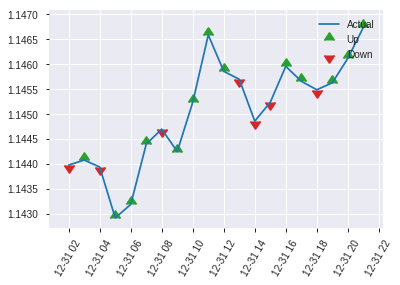


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19982004882486898
RMSE: 0.4470123586936596
LogLoss: 0.5868742315571499
Mean Per-Class Error: 0.2908832508685124
AUC: 0.7693862511843352
pr_auc: 0.7599158442931898
Gini: 0.5387725023686705
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3765032212035817: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  144  0.4881   (144.0/295.0)
1      47   275  0.146    (47.0/322.0)
Total  198  419  0.3096   (191.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376503     0.74224   261
max f2                       0.143071     0.85537   358
max f0point5                 0.461155     0.721332  211
max accuracy                 0.447048     0.711507  220
max precision                0.963586     1         0
max recall                   0.0545876    1         387
max specificity              0.963586     1         0
max absolute_mcc             0.443623     0.421705  224
max min_per_class_accuracy   0.470727     0.698305  205
max mean_per_class_accuracy  0.461155     0.709117  211

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 47.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.937581           1.91615   1.91615            1                0.947283   1                           0.947283            0.0217391       0.0217391                  91.6149   91.6149
    2        0.0210697                   0.91826            1.27743   1.62136            0.666667         0.928528   0.846154                    0.938627            0.0124224       0.0341615                  27.7433   62.1357
    3        0.0307942                   0.90795            1.27743   1.51275            0.666667         0.91304    0.789474                    0.930546            0.0124224       0.0465839                  27.7433   51.2749
    4        0.0405186                   0.887356           0.958075  1.37963            0.5              0.897185   0.72                        0.92254             0.00931677      0.0559006                  -4.19255  37.9627
    5        0.0502431                   0.877987           1.91615   1.48347            1                0.88229    0.774194                    0.914749            0.0186335       0.0745342                  91.6149   48.347
    6        0.100486                    0.775554           1.73072   1.60709            0.903226         0.834951   0.83871                     0.87485             0.0869565       0.161491                   73.0715   60.7093
    7        0.150729                    0.716841           1.60709   1.60709            0.83871          0.741829   0.83871                     0.83051             0.0807453       0.242236                   60.7093   60.7093
    8        0.200972                    0.661236           1.6689    1.62255            0.870968         0.68686    0.846774                    0.794597            0.0838509       0.326087                   66.8904   62.2546
    9        0.299838                    0.597314           1.41355   1.55363            0.737705         0.632595   0.810811                    0.74118             0.139752        0.465839                   41.3553   55.3634
    10       0.400324                    0.534011           1.1126    1.44293            0.580645         0.5689     0.753036                    0.697936            0.111801        0.57764                    11.2603   44.293
    11       0.50081                     0.47653            1.1126    1.37665            0.580645         0.499383   0.718447                    0.658097            0.111801        0.689441                   11.2603   37.6651
    12       0.599676                    0.43635            1.03661   1.32059            0.540984         0.453085   0.689189                    0.624297            0.102484        0.791925                   3.66052   32.0589
    13       0.700162                    0.364004           0.710829  1.23308            0.370968         0.40269    0.643519                    0.592493            0.0714286       0.863354                   -28.9171  23.3077
    14       0.799028                    0.254353           0.659658  1.16213            0.344262         0.302786   0.606491                    0.556647            0.0652174       0.928571                   -34.0342  16.2127
    15       0.899514                    0.160966           0.432679  1.08064            0.225806         0.206813   0.563964                    0.517566            0.0434783       0.97205                    -56.7321  8.0639
    16       1                           0.0184513          0.278151  1                  0.145161         0.0910532  0.52188                     0.

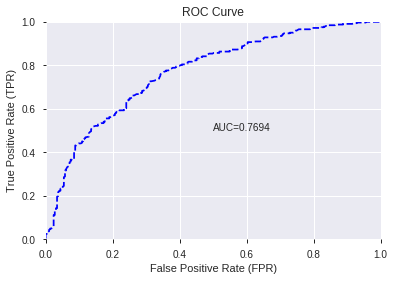

This function is available for GLM models only


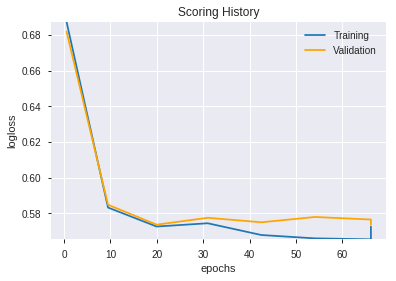

--2019-07-25 07:58:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_073438_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_073438_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLHANGINGMAN',
 'STOCHF_fastk',
 'TRANGE',
 'DIV',
 'SUB',
 'CCI_8',
 'WILLR_8',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CDLENGULFING',
 'MINUS_DM_8',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'CDLMARUBOZU',
 'CCI_12',
 'CDLHARAMI',
 'STOCHRSI_fastd',
 'CDLTAKURI',
 'WILLR_30',
 'WILLR_24',
 'WILLR_20',
 'ADOSC',
 'WILLR_12',
 'WILLR_14',
 'CCI_14',
 'CDLHAMMER',
 'RSI_30',
 'CMO_24',
 'CCI_24',
 'Volume',
 'CMO_30',
 'RSI_20',
 'CMO_12',
 'MOM_8',
 'STOCH_slowk',
 'ROC_8',
 'STOCHF_fastd',
 'CCI_20',
 'RSI_14',
 'CMO_20',
 'ROCR100_14',
 'MOM_12',
 'ROCP_8',
 'CMO_14',
 'RSI_8',
 'RSI_24',
 'ROCR100_12',
 'CMO_8',
 'ROCP_14',
 'ROCR_14',
 'MOM_14',
 'ROCP_12',
 'ROCR100_8',
 'ROCR_12',
 'RSI_12',
 'ROC_12',
 'ROC_14',
 'ROCR_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_075924_model_1  0.775145  0.573723              0.287372  0.440437  0.193985

variable  relative_importance  scaled_importance  percentage
0            BOP             0.827630           1.000000    0.109006
1          CCI_8             0.585397           0.707317    0.077102
2        WILLR_8             0.540826           0.653464    0.071231
3   STOCHF_fastk             0.502986           0.607742    0.066247
4         CCI_24             0.402492           0.486319    0.053012
..           ...                  ...                ...         ...
57    ROCR100_14             0.011474           0.013863    0.001511
58        ROCR_8             0.009222           0.011143    0.001215
59        CMO_12             0.008989           0.010861    0.001184
60   CDLLONGLINE             0.006135           0.007413    0.000808
61     ROCR100_8             0.005887           0.007113    0.000775

[62 rows x 4 columns]

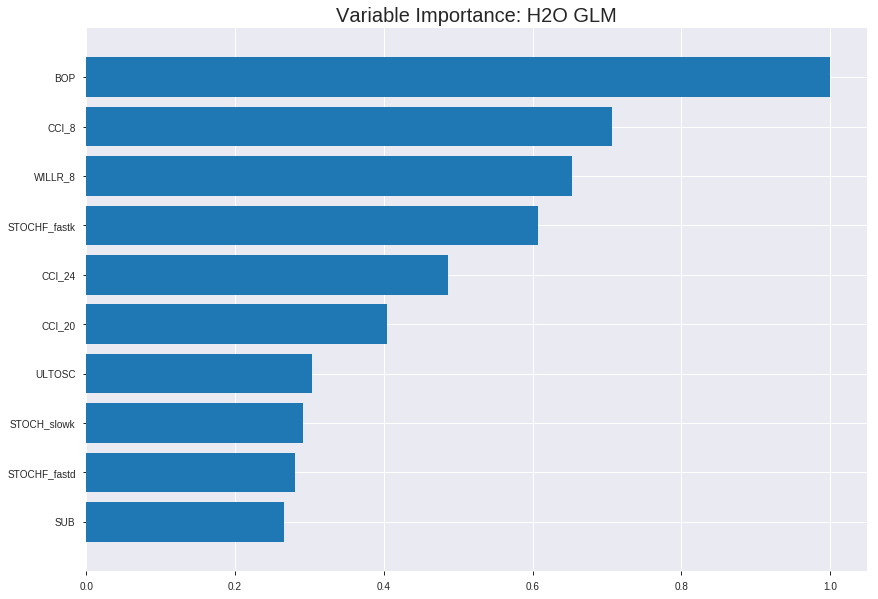

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_075924_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19303480510964097
RMSE: 0.4393572636359173
LogLoss: 0.5681664522305933
Null degrees of freedom: 4318
Residual degrees of freedom: 4256
Null deviance: 5972.1036478564565
Residual deviance: 4907.821814367863
AIC: 5033.821814367863
AUC: 0.7741627371889559
pr_auc: 0.7424389778845724
Gini: 0.5483254743779118
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3486204368340239: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1195  1093  0.4777   (1093.0/2288.0)
1      296   1735  0.1457   (296.0/2031.0)
Total  1491  2828  0.3216   (1389.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34862      0.714139  257
max f2                       0.176646     0.826808  337
max f0point5                 0.547039     0.697906  170
max accuracy                 0.547039     0.708266  170
max precision                0.971981     1         0
max recall                   0.0309456    1         395
max specificity              0.971981     1         0
max absolute_mcc             0.547039     0.413479  170
max min_per_class_accuracy   0.481996     0.699163  199
max mean_per_class_accuracy  0.547039     0.70333   170

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.911364           1.98155   1.98155            0.931818         0.933621   0.931818                    0.933621            0.0201871       0.0201871                  98.1547    98.1547
    2        0.0201436                   0.890953           1.92872   1.95544            0.906977         0.8996     0.91954                     0.916806            0.0192024       0.0393895                  92.8721    95.5438
    3        0.0300996                   0.875417           1.97818   1.96296            0.930233         0.882167   0.923077                    0.905348            0.0196947       0.0590842                  97.8175    96.2959
    4        0.0400556                   0.857542           1.87927   1.94216            0.883721         0.866879   0.913295                    0.895787            0.01871         0.0777942                  87.9267    94.2157
    5        0.0500116                   0.847752           1.58254   1.87057            0.744186         0.852916   0.87963                     0.887252            0.0157558       0.09355                    58.254     87.0566
    6        0.100023                    0.788863           1.77212   1.82134            0.833333         0.81362    0.856481                    0.850436            0.0886263       0.182176                   77.2116    82.1341
    7        0.150035                    0.744968           1.64413   1.76227            0.773148         0.766849   0.828704                    0.822574            0.0822255       0.264402                   64.4129    76.227
    8        0.200046                    0.706617           1.55552   1.71058            0.731481         0.725854   0.804398                    0.798394            0.0777942       0.342196                   55.5524    71.0584
    9        0.300069                    0.625455           1.42754   1.61624            0.671296         0.666101   0.760031                    0.754296            0.142787        0.484983                   42.7538    61.6235
    10       0.400093                    0.551846           1.27494   1.53091            0.599537         0.589563   0.719907                    0.713113            0.127523        0.612506                   27.4939    53.0911
    11       0.500116                    0.471992           0.994354  1.4236             0.467593         0.509206   0.669444                    0.672332            0.0994584       0.711965                   -0.564628  42.3599
    12       0.599907                    0.389206           0.942387  1.34355            0.443155         0.433532   0.631802                    0.632608            0.0940423       0.806007                   -5.76128   34.3552
    13       0.699931                    0.30891            0.777762  1.2627             0.365741         0.349686   0.593781                    0.592178            0.0777942       0.883801                   -22.2238   26.2698
    14       0.799954                    0.231976           0.54148   1.17252            0.25463          0.269514   0.551375                    0.551833            0.0541605       0.937962                   -45.852    17.252
    15       0.899977                    0.150117           0.383958  1.08488            0.180556         0.190458   0.510162                    0.51167             0.0384047       0.976366                   -61.6042   8.48794
    16       1                           0.00150844         0.236282  1                  0.111111         0.0975464  0.470248    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1911572013156001
RMSE: 0.4372152802860395
LogLoss: 0.5635113125368628
Null degrees of freedom: 1233
Residual degrees of freedom: 1171
Null deviance: 1707.2004406915303
Residual deviance: 1390.7459193409773
AIC: 1516.7459193409773
AUC: 0.7795903582718652
pr_auc: 0.7353932835789971
Gini: 0.5591807165437304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3073488579526005: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      316  334  0.5138   (334.0/650.0)
1      62   522  0.1062   (62.0/584.0)
Total  378  856  0.3209   (396.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307349     0.725     277
max f2                       0.181769     0.838719  337
max f0point5                 0.556366     0.706785  162
max accuracy                 0.517214     0.715559  183
max precision                0.959734     1         0
max recall                   0.0827084    1         380
max specificity              0.959734     1         0
max absolute_mcc             0.511246     0.428465  186
max min_per_class_accuracy   0.478258     0.712308  202
max mean_per_class_accuracy  0.511246     0.713309  186

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.907253           2.11301   2.11301            1                0.928179  1                           0.928179            0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.87968            1.58476   1.85945            0.75             0.894055  0.88                        0.911799            0.015411        0.0376712                  58.476    85.9452
    3        0.0299838                   0.86332            1.76084   1.82747            0.833333         0.872519  0.864865                    0.89906             0.0171233       0.0547945                  76.0845   82.7471
    4        0.0405186                   0.852875           1.6254    1.77493            0.769231         0.859332  0.84                        0.888731            0.0171233       0.0719178                  62.5395   77.4932
    5        0.0502431                   0.839958           1.58476   1.73812            0.75             0.845551  0.822581                    0.880373            0.015411        0.0873288                  58.476    73.8124
    6        0.100486                    0.778626           1.73812   1.73812            0.822581         0.81238   0.822581                    0.846376            0.0873288       0.174658                   73.8124   73.8124
    7        0.149919                    0.736336           1.59342   1.69041            0.754098         0.757951  0.8                         0.81722             0.0787671       0.253425                   59.342    69.0411
    8        0.200162                    0.706079           1.56772   1.65961            0.741935         0.72315   0.785425                    0.793607            0.0787671       0.332192                   56.772    65.9614
    9        0.299838                    0.626156           1.46021   1.59333            0.691057         0.665827  0.754054                    0.751129            0.145548        0.47774                    46.0213   59.3327
    10       0.400324                    0.543863           1.36323   1.53557            0.645161         0.585108  0.726721                    0.709456            0.136986        0.614726                   36.3235   53.5571
    11       0.5                         0.470695           1.04792   1.43836            0.495935         0.507162  0.680713                    0.669128            0.104452        0.719178                   4.79174   43.8356
    12       0.599676                    0.389915           0.944844  1.35633            0.447154         0.430897  0.641892                    0.62953             0.0941781       0.813356                   -5.51565  35.6326
    13       0.700162                    0.302902           0.834981  1.2815             0.395161         0.346262  0.606481                    0.588876            0.0839041       0.89726                    -16.5019  28.1504
    14       0.799838                    0.229274           0.481011  1.18175            0.227642         0.262813  0.559271                    0.548242            0.0479452       0.945205                   -51.8989  18.1746
    15       0.899514                    0.154058           0.360758  1.09077            0.170732         0.190885  0.516216                    0.508643            0.0359589       0.981164                   -63.9242  9.07719
    16       1                           0.0122534          0.187445  1                  0.0887097        0.102248  0.473258                    0.467806         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 07:59:25  0.000 sec   2            .2E2      63            1.3623748276101517  1.3627979186226293
     2019-07-25 07:59:25  0.033 sec   4            .12E2     63            1.3533567948732397  1.3535788747883521
     2019-07-25 07:59:25  0.066 sec   6            .77E1     63            1.3413858052458594  1.3412950711246838
     2019-07-25 07:59:25  0.099 sec   8            .48E1     63            1.3259132168474845  1.3253695273581112
     2019-07-25 07:59:25  0.135 sec   10           .3E1      63            1.306677527747919   1.3054839999259824
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 07:59:26  0.709 sec   44           .35E-3    63            1.136332904461186   1.1270226250737254
     2019-07-25 07:59:26  0.730 sec   45           .22E-3    63            1.1362721057322545  1.127056642700708
     2019-07-25 07:59:26  0.749 sec   46           .14E-3    63            1.136216842043022   1.1271067634660816
     2019-07-25 07:59:26  0.767 sec   47           .84E-4    63            1.136158384467517   1.127172214368312
     2019-07-25 07:59:26  0.786 sec   48           .52E-4    63            1.13610716742523    1.1272276415544225


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7260940032414911)

('F1', 0.7460087082728594)

('auc', 0.7751447520791662)

('logloss', 0.5737231631083662)

('mean_per_class_error', 0.2746446994420465)

('rmse', 0.44043724530574296)

('mse', 0.1939849670525112)

glm prediction progress: |████████████████████████████████████████████████| 100%


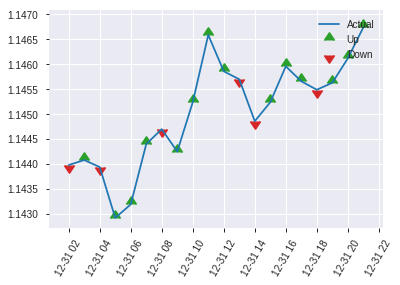


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1939849670525112
RMSE: 0.44043724530574296
LogLoss: 0.5737231631083662
Null degrees of freedom: 616
Residual degrees of freedom: 554
Null deviance: 860.749207800923
Residual deviance: 707.9743832757241
AIC: 833.9743832757241
AUC: 0.7751447520791662
pr_auc: 0.7710972332365474
Gini: 0.5502895041583324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42177730241497285: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      185  110  0.3729   (110.0/295.0)
1      65   257  0.2019   (65.0/322.0)
Total  250  367  0.2836   (175.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421777     0.746009  232
max f2                       0.160287     0.856833  356
max f0point5                 0.481049     0.736745  204
max accuracy                 0.481049     0.726094  204
max precision                0.951207     1         0
max recall                   0.049875     1         392
max specificity              0.951207     1         0
max absolute_mcc             0.481049     0.450924  204
max min_per_class_accuracy   0.492069     0.718644  197
max mean_per_class_accuracy  0.481049     0.725355  204

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 48.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.918954           1.64241   1.64241            0.857143         0.936036   0.857143                    0.936036            0.0186335       0.0186335                  64.2413   64.2413
    2        0.0210697                   0.893462           1.59679   1.62136            0.833333         0.905171   0.846154                    0.921791            0.015528        0.0341615                  59.6791   62.1357
    3        0.0307942                   0.875352           1.59679   1.6136             0.833333         0.883685   0.842105                    0.909757            0.015528        0.0496894                  59.6791   61.3599
    4        0.0405186                   0.862116           1.91615   1.68621            1                0.868913   0.88                        0.899955            0.0186335       0.068323                   91.6149   68.6211
    5        0.0502431                   0.849429           1.91615   1.73072            1                0.854012   0.903226                    0.891063            0.0186335       0.0869565                  91.6149   73.0715
    6        0.100486                    0.80284            1.73072   1.73072            0.903226         0.828999   0.903226                    0.860031            0.0869565       0.173913                   73.0715   73.0715
    7        0.150729                    0.755415           1.54528   1.6689             0.806452         0.779768   0.870968                    0.833277            0.0776398       0.251553                   54.5282   66.8904
    8        0.200972                    0.719913           1.42166   1.60709            0.741935         0.736382   0.83871                     0.809053            0.0714286       0.322981                   42.1659   60.7093
    9        0.299838                    0.658079           1.31932   1.5122             0.688525         0.691036   0.789189                    0.770139            0.130435        0.453416                   31.9316   51.2204
    10       0.400324                    0.586688           1.35985   1.47396            0.709677         0.621743   0.769231                    0.73289             0.136646        0.590062                   35.9848   47.3961
    11       0.50081                     0.50192            1.17441   1.41386            0.612903         0.548395   0.737864                    0.695872            0.118012        0.708075                   17.4414   41.3858
    12       0.599676                    0.413635           0.910956  1.33095            0.47541          0.455729   0.694595                    0.65628             0.0900621       0.798137                   -8.90439  33.0947
    13       0.700162                    0.337931           0.649018  1.23308            0.33871          0.374135   0.643519                    0.615787            0.0652174       0.863354                   -35.0982  23.3077
    14       0.799028                    0.238539           0.659658  1.16213            0.344262         0.283271   0.606491                    0.574644            0.0652174       0.928571                   -34.0342  16.2127
    15       0.899514                    0.160149           0.525396  1.091              0.274194         0.200652   0.569369                    0.532865            0.052795        0.981366                   -47.4604  9.09966
    16       1                           0.0172601          0.185434  1                  0.0967742        0.0964353  0.52188                    

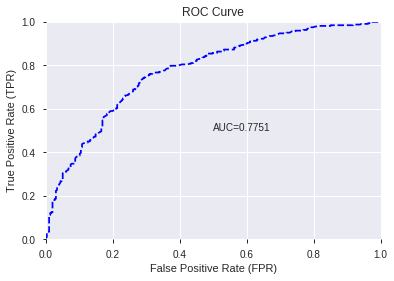

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


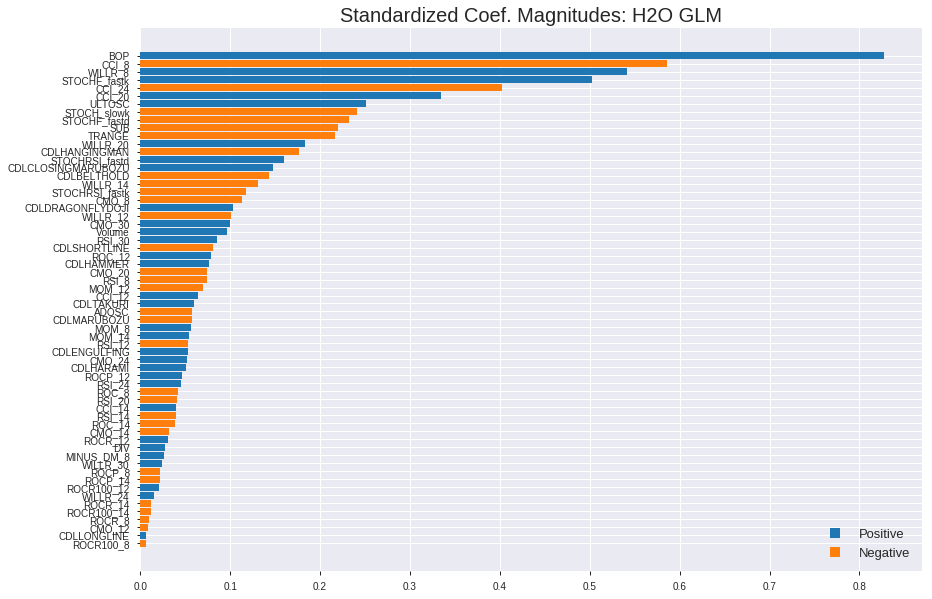

'log_likelihood'
--2019-07-25 07:59:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_075924_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_075924_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'WILLR_8',
 'STOCHF_fastk',
 'CCI_24',
 'CCI_20',
 'ULTOSC',
 'STOCH_slowk',
 'STOCHF_fastd',
 'SUB',
 'TRANGE',
 'WILLR_20',
 'CDLHANGINGMAN',
 'STOCHRSI_fastd',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'WILLR_14',
 'STOCHRSI_fastk',
 'CMO_8',
 'CDLDRAGONFLYDOJI',
 'WILLR_12',
 'CMO_30',
 'Volume',
 'RSI_30',
 'CDLSHORTLINE',
 'ROC_12',
 'CDLHAMMER',
 'CMO_20',
 'RSI_8',
 'MOM_12',
 'CCI_12',
 'CDLTAKURI',
 'ADOSC',
 'CDLMARUBOZU',
 'MOM_8',
 'MOM_14',
 'RSI_12',
 'CDLENGULFING',
 'CMO_24',
 'CDLHARAMI',
 'ROCP_12',
 'RSI_24',
 'ROC_8',
 'RSI_20',
 'CCI_14',
 'RSI_14',
 'ROC_14',
 'CMO_14',
 'ROCR_12',
 'DIV',
 'MINUS_DM_8',
 'WILLR_30',
 'ROCP_8',
 'ROCP_14',
 'ROCR100_12',
 'WILLR_24',
 'ROCR_14',
 'ROCR100_14',
 'ROCR_8',
 'CMO_12',
 'CDLLONGLINE',
 'ROCR100_8']

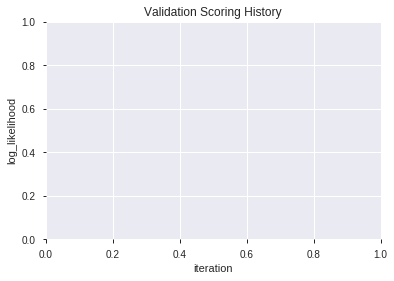

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_080032_model_4  0.790436  0.560260              0.324976  0.434655  0.188925
1  XGBoost_grid_1_AutoML_20190725_080032_model_2  0.789694  0.561517              0.299400  0.435259  0.189450
2  XGBoost_grid_1_AutoML_20190725_080032_model_1  0.786778  0.564684              0.320318  0.437029  0.190994
3  XGBoost_grid_1_AutoML_20190725_080032_model_6  0.786451  0.565240              0.333035  0.437391  0.191311
4  XGBoost_grid_1_AutoML_20190725_080032_model_3  0.785909  0.564945              0.318055  0.437372  0.191295
5               XGBoost_3_AutoML_20190725_080032  0.784988  0.565835              0.320318  0.437436  0.191350
6               XGBoost_2_AutoML_20190725_080032  0.784846  0.560871              0.318197  0.435980  0.190078
7  XGBoost_grid_1_AutoML_20190725_080032_model_7  0.777208  0.571786              0.321018  0.440237  0.193809
8               XGBoost_1_AutoML_20190725_080032  0.776934  0.571633              0.277498  0.440147  0.193730
9  XGBoost_grid_1_AutoML_20190725_080032_model_5  0.762580  0.590810              0.311122  0.449821  0.202339

variable  relative_importance  scaled_importance  percentage
0                  BOP          4943.483887           1.000000    0.390994
1         STOCHF_fastk           970.955688           0.196411    0.076796
2               TRANGE           635.110596           0.128474    0.050233
3                CCI_8           634.795654           0.128411    0.050208
4                  DIV           515.341248           0.104247    0.040760
5       STOCHRSI_fastd           318.687714           0.064466    0.025206
6                  SUB           305.719635           0.061843    0.024180
7               CCI_12           277.179932           0.056070    0.021923
8               ULTOSC           270.937866           0.054807    0.021429
9              WILLR_8           249.705643           0.050512    0.019750
10              CCI_14           241.563736           0.048865    0.019106
11              Volume           238.392807           0.048224    0.018855
12               ADOSC           236.365219           0.047813    0.018695
13              CCI_24           218.820068           0.044264    0.017307
14  CDLCLOSINGMARUBOZU           213.739716           0.043237    0.016905
15      STOCHRSI_fastk           191.755219           0.038789    0.015166
16               ROC_8           189.421265           0.038317    0.014982
17          MINUS_DM_8           183.083801           0.037035    0.014481
18            WILLR_24           179.172287           0.036244    0.014171
19            WILLR_12           157.869843           0.031935    0.012486
20            WILLR_20           146.329605           0.029601    0.011574
21              CMO_30           121.479996           0.024574    0.009608
22              CCI_20           116.594139           0.023585    0.009222
23              MOM_12           115.674194           0.023399    0.009149
24              CMO_20           115.427711           0.023349    0.009129
25         STOCH_slowk           102.026917           0.020639    0.008070
26            WILLR_30            92.182632           0.018647    0.007291
27            WILLR_14            85.449753           0.017285    0.006758
28               MOM_8            77.879372           0.015754    0.006160
29              MOM_14            70.366379           0.014234    0.005565
30               CMO_8            69.007339           0.013959    0.005458
31              CMO_24            65.794258           0.013309    0.005204
32              ROC_14            64.587387           0.013065    0.005108
33              CMO_12            60.713737           0.012282    0.004802
34              ROC_12            57.935173           0.011720    0.004582
35         CDLBELTHOLD            53.277031           0.010777    0.004214
36              CMO_14            40.508739           0.008194    0.003204
37        CDLSHORTLINE             8.928543           0.001806    0.000706
38         CDLLONGLINE             7.115067           0.001439    0.000563

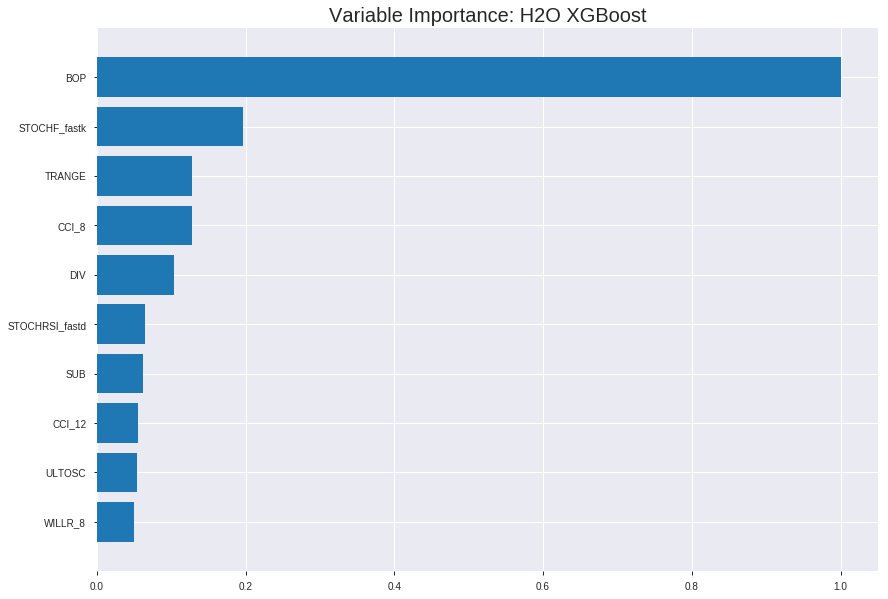

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_080032_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17267761018326883
RMSE: 0.41554495567058547
LogLoss: 0.5211016790085137
Mean Per-Class Error: 0.25485503541264254
AUC: 0.8283677948098184
pr_auc: 0.8086755996349656
Gini: 0.6567355896196367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4157909127798947: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1468  820   0.3584   (820.0/2288.0)
1      341   1690  0.1679   (341.0/2031.0)
Total  1809  2510  0.2688   (1161.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415791     0.744329  234
max f2                       0.232547     0.844627  318
max f0point5                 0.604117     0.748465  138
max accuracy                 0.518329     0.746238  185
max precision                0.900728     1         0
max recall                   0.0961223    1         383
max specificity              0.900728     1         0
max absolute_mcc             0.510927     0.49025   189
max min_per_class_accuracy   0.500085     0.74003   194
max mean_per_class_accuracy  0.510927     0.745145  189

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.869547           2.02988   2.02988            0.954545         0.880189  0.954545                    0.880189            0.0206795       0.0206795                  102.988   102.988
    2        0.0201436                   0.848244           2.07708   2.05321            0.976744         0.857745  0.965517                    0.869096            0.0206795       0.0413589                  107.708   105.321
    3        0.0300996                   0.834916           2.07708   2.06111            0.976744         0.841271  0.969231                    0.859892            0.0206795       0.0620384                  107.708   106.111
    4        0.0400556                   0.822837           1.97818   2.04049            0.930233         0.829424  0.959538                    0.852319            0.0196947       0.0817331                  97.8175   104.049
    5        0.0500116                   0.810523           1.92872   2.01824            0.906977         0.816361  0.949074                    0.845161            0.0192024       0.100935                   92.8721   101.824
    6        0.100023                    0.76588            1.90995   1.96409            0.898148         0.786643  0.923611                    0.815902            0.0955194       0.196455                   90.9947   96.4095
    7        0.150035                    0.730446           1.86072   1.92964            0.875            0.74762   0.907407                    0.793141            0.0930576       0.289513                   86.0721   92.9637
    8        0.200046                    0.694612           1.71305   1.87549            0.805556         0.71271   0.881944                    0.773033            0.0856721       0.375185                   71.3045   87.5489
    9        0.300069                    0.632466           1.47184   1.74094            0.69213          0.664051  0.818673                    0.736706            0.147218        0.522403                   47.184    74.0939
    10       0.400093                    0.565761           1.28971   1.62813            0.606481         0.599342  0.765625                    0.702365            0.129           0.651403                   28.9706   62.8131
    11       0.500116                    0.488603           1.05835   1.51417            0.497685         0.527543  0.712037                    0.667401            0.105859        0.757262                   5.83468   51.4174
    12       0.599907                    0.398339           0.853576  1.40429            0.401392         0.4433    0.660363                    0.630123            0.0851797       0.842442                   -14.6424  40.4287
    13       0.699931                    0.310033           0.762994  1.31264            0.358796         0.355364  0.617268                    0.590858            0.0763171       0.918759                   -23.7006  31.2643
    14       0.799954                    0.232967           0.433184  1.20268            0.203704         0.271605  0.565557                    0.55094             0.0433284       0.962088                   -56.6816  20.2679
    15       0.899977                    0.159939           0.275662  1.09965            0.12963          0.197245  0.517108                    0.511631            0.0275726       0.98966                    -72.4338  9.96508
    16       1                           0.0534111          0.103373  1                  0.0486111        0.114857  0.470248                    0.471944         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19113077470791895
RMSE: 0.4371850577363309
LogLoss: 0.5638291271837205
Mean Per-Class Error: 0.28510010537407793
AUC: 0.7802713382507903
pr_auc: 0.7465704701688286
Gini: 0.5605426765015806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31082919239997864: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      298  352  0.5415   (352.0/650.0)
1      57   527  0.0976   (57.0/584.0)
Total  355  879  0.3314   (409.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310829     0.720437  281
max f2                       0.223456     0.833084  323
max f0point5                 0.545584     0.702329  165
max accuracy                 0.517535     0.714749  180
max precision                0.901944     1         0
max recall                   0.0932331    1         387
max specificity              0.901944     1         0
max absolute_mcc             0.507697     0.429227  185
max min_per_class_accuracy   0.507697     0.712308  185
max mean_per_class_accuracy  0.490707     0.7149    193

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 47.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.859973           1.95047   1.95047            0.923077         0.876035  0.923077                    0.876035            0.0205479       0.0205479                  95.0474   95.0474
    2        0.0202593                   0.843506           1.93693   1.94397            0.916667         0.852736  0.92                        0.864852            0.0188356       0.0393836                  93.6929   94.3973
    3        0.0299838                   0.830135           1.93693   1.94169            0.916667         0.838824  0.918919                    0.85641             0.0188356       0.0582192                  93.6929   94.1688
    4        0.0405186                   0.817882           1.95047   1.94397            0.923077         0.824629  0.92                        0.848147            0.0205479       0.0787671                  95.0474   94.3973
    5        0.0502431                   0.799641           1.23259   1.80629            0.583333         0.807748  0.854839                    0.840328            0.0119863       0.0907534                  23.2591   80.6286
    6        0.100486                    0.755383           1.80629   1.80629            0.854839         0.777114  0.854839                    0.808721            0.0907534       0.181507                   80.6286   80.6286
    7        0.149919                    0.728353           1.6627    1.75894            0.786885         0.742441  0.832432                    0.786867            0.0821918       0.263699                   66.2699   75.8941
    8        0.200162                    0.695188           1.39732   1.66817            0.66129          0.710998  0.789474                    0.767823            0.0702055       0.333904                   39.7316   66.8169
    9        0.299838                    0.637505           1.46021   1.59904            0.691057         0.666688  0.756757                    0.734202            0.145548        0.479452                   46.0213   59.9037
    10       0.400324                    0.571187           1.34619   1.53557            0.637097         0.604307  0.726721                    0.701597            0.135274        0.614726                   34.6194   53.5571
    11       0.5                         0.494499           1.09945   1.44863            0.520325         0.536756  0.685575                    0.668736            0.109589        0.724315                   9.94543   44.863
    12       0.599676                    0.408371           0.858949  1.35062            0.406504         0.4522    0.639189                    0.632744            0.0856164       0.809932                   -14.1051  35.0616
    13       0.700162                    0.316358           0.766819  1.26683            0.362903         0.359447  0.599537                    0.593521            0.0770548       0.886986                   -23.3181  26.683
    14       0.799838                    0.236809           0.601264  1.18389            0.284553         0.277704  0.560284                    0.554164            0.0599315       0.946918                   -39.8736  18.3887
    15       0.899514                    0.163826           0.343579  1.09077            0.162602         0.196111  0.516216                    0.514488            0.0342466       0.981164                   -65.6421  9.07719
    16       1                           0.0579848          0.187445  1                  0.0887097        0.120991  0.473258                    0.474947           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 08:00:48  6.270 sec   0                  0.5              0.693147            0.5             0                  1                0.529752                         0.5                0.693147              0.5               0                    1                  0.526742
    2019-07-25 08:00:48  6.393 sec   5                  0.478398         0.650613            0.779411        0.744894           2.02988          0.306321                         0.480432           0.654554              0.758645          0.706452             1.78793            0.32658
    2019-07-25 08:00:48  6.486 sec   10                 0.463872         0.622194            0.785216        0.752817           2.02988          0.298449                         0.467603           0.629342              0.762308          0.718325             1.78793            0.309562
    2019-07-25 08:00:49  6.592 sec   15                 0.453537         0.601652            0.790813        0.758549           2.03203          0.295439                         0.458888           0.611868              0.766428          0.724292             1.95047            0.317666
    2019-07-25 08:00:49  6.735 sec   20                 0.446607         0.587389            0.792326        0.759467           2.02988          0.296133                         0.453699           0.600955              0.765545          0.722664             1.95047            0.323339
    2019-07-25 08:00:49  6.884 sec   25                 0.440819         0.575183            0.796484        0.764494           1.98477          0.291734                         0.450198           0.593326              0.767263          0.727689             1.95047            0.314425
    2019-07-25 08:00:49  7.046 sec   30                 0.436607         0.566083            0.799819        0.770265           2.07928          0.291734                         0.446753           0.585571              0.768618          0.730176             1.95047            0.350891
    2019-07-25 08:00:49  7.220 sec   35                 0.433369         0.55898             0.80236         0.77419            2.07821          0.299375                         0.443928           0.579415              0.772251          0.735786             1.95047            0.313614
    2019-07-25 08:00:49  7.406 sec   40                 0.43109          0.553845            0.804228        0.776669           2.02988          0.299375                         0.442702           0.576415              0.773224          0.737125             1.95047            0.311994
    2019-07-25 08:00:50  7.605 sec   45                 0.428619         0.548576            0.807846        0.781943           2.02988          0.293355                         0.441347           0.573379              0.774617          0.740626             1.95047            0.3047
    2019-07-25 08:00:50  7.797 sec   50                 0.426412         0.54381             0.810705        0.785122           2.02988          0.290113                         0.440248           0.570844              0.776284          0.743853             2.11301            0.329822
    2019-07-25 08:00:50  8.028 sec   55                 0.424204         0.539174            0.814539        0.790659           2.02988          0.292197                         0.439393           0.569032              0.777475          0.74

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           4943.48388671875       1.0                    0.390993861360125
STOCHF_fastk  970.9556884765625      0.196411217417973      0.07679558031269629
TRANGE        635.110595703125       0.12847429267635002    0.05023265977903692
CCI_8         634.795654296875       0.12841058428496713    0.05020775018908909
DIV           515.3412475585938      0.10424657172305518    0.04075976961155256
---           ---                    ---                    ---
ROC_12        57.93517303466797      0.011719502756005256   0.004582253635791122
CDLBELTHOLD   53.27703094482422      0.010777223546325137   0.004213828249118925
CMO_14        40.50873947143555      0.008194370690732306   0.003203948637785659
CDLSHORTLINE  8.928543090820312      0.0018061236357638168  0.0007061832544410827
CDLLONGLINE   7.1150665283203125     0.0014392818286382554  0.0005627503597647332


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7212317666126418)

('F1', 0.7525510204081632)

('auc', 0.7904358353510895)

('logloss', 0.5602603198846294)

('mean_per_class_error', 0.2767449205179493)

('rmse', 0.4346553778069944)

('mse', 0.18892529745654105)

xgboost prediction progress: |████████████████████████████████████████████| 100%


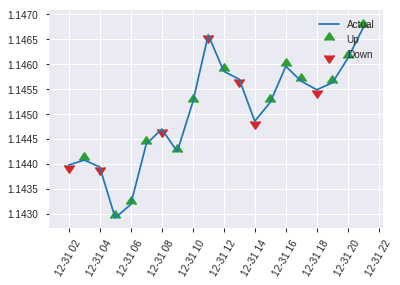


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18892529745654105
RMSE: 0.4346553778069944
LogLoss: 0.5602603198846294
Mean Per-Class Error: 0.2767449205179493
AUC: 0.7904358353510895
pr_auc: 0.7813580881908391
Gini: 0.580871670702179
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2735884189605713: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  167  0.5661   (167.0/295.0)
1      27   295  0.0839   (27.0/322.0)
Total  155  462  0.3144   (194.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.273588     0.752551  297
max f2                       0.197335     0.860452  337
max f0point5                 0.540933     0.74352   175
max accuracy                 0.540933     0.721232  175
max precision                0.893077     1         0
max recall                   0.065988     1         396
max specificity              0.893077     1         0
max absolute_mcc             0.540933     0.447274  175
max min_per_class_accuracy   0.49952      0.711864  192
max mean_per_class_accuracy  0.540933     0.723255  175

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 48.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.865049           1.36868   1.36868            0.714286         0.878093  0.714286                    0.878093            0.015528        0.015528                   36.8678   36.8678
    2        0.0210697                   0.853031           1.91615   1.62136            1                0.85829   0.846154                    0.868953            0.0186335       0.0341615                  91.6149   62.1357
    3        0.0307942                   0.838951           1.59679   1.6136             0.833333         0.843776  0.842105                    0.861002            0.015528        0.0496894                  59.6791   61.3599
    4        0.0405186                   0.830775           1.91615   1.68621            1                0.834068  0.88                        0.854538            0.0186335       0.068323                   91.6149   68.6211
    5        0.0502431                   0.815048           1.91615   1.73072            1                0.8235    0.903226                    0.848531            0.0186335       0.0869565                  91.6149   73.0715
    6        0.100486                    0.77986            1.60709   1.6689             0.83871          0.796556  0.870968                    0.822544            0.0807453       0.167702                   60.7093   66.8904
    7        0.150729                    0.744725           1.6689    1.6689             0.870968         0.761733  0.870968                    0.802273            0.0838509       0.251553                   66.8904   66.8904
    8        0.200972                    0.703276           1.73072   1.68436            0.903226         0.722705  0.879032                    0.782381            0.0869565       0.338509                   73.0715   68.4357
    9        0.299838                    0.642684           1.35073   1.57435            0.704918         0.673535  0.821622                    0.746491            0.13354         0.47205                    35.0728   57.435
    10       0.400324                    0.583824           1.23623   1.48948            0.645161         0.610581  0.777328                    0.712376            0.124224        0.596273                   23.6225   48.9476
    11       0.50081                     0.511426           1.0817    1.40766            0.564516         0.547623  0.734628                    0.679319            0.108696        0.704969                   8.16971   40.7656
    12       0.599676                    0.431651           0.910956  1.32577            0.47541          0.462561  0.691892                    0.643583            0.0900621       0.795031                   -8.90439  32.5768
    13       0.700162                    0.337684           0.803546  1.25082            0.419355         0.388418  0.652778                    0.606962            0.0807453       0.875776                   -19.6454  25.082
    14       0.799028                    0.229196           0.628246  1.17379            0.327869         0.276959  0.612576                    0.56613             0.0621118       0.937888                   -37.1754  17.3787
    15       0.899514                    0.168524           0.432679  1.091              0.225806         0.19906   0.569369                    0.525124            0.0434783       0.981366                   -56.7321  9.09966
    16       1                           0.0538815          0.185434  1                  0.0967742        0.122781  0.52188                     0.484694           

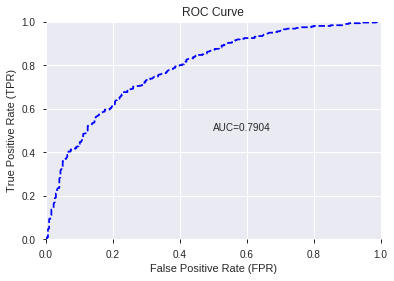

This function is available for GLM models only


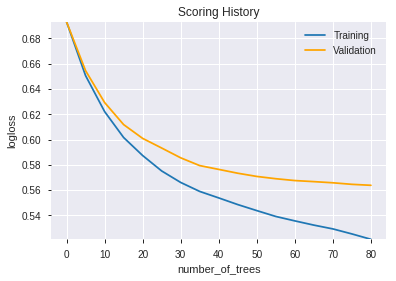

--2019-07-25 08:01:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_080032_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_080032_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'CCI_8',
 'DIV',
 'STOCHRSI_fastd',
 'SUB',
 'CCI_12',
 'ULTOSC',
 'WILLR_8',
 'CCI_14',
 'Volume',
 'ADOSC',
 'CCI_24',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'ROC_8',
 'MINUS_DM_8',
 'WILLR_24',
 'WILLR_12',
 'WILLR_20',
 'CMO_30',
 'CCI_20',
 'MOM_12',
 'CMO_20',
 'STOCH_slowk',
 'WILLR_30',
 'WILLR_14',
 'MOM_8',
 'MOM_14',
 'CMO_8',
 'CMO_24',
 'ROC_14',
 'CMO_12',
 'ROC_12',
 'CDLBELTHOLD',
 'CMO_14',
 'CDLSHORTLINE',
 'CDLLONGLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

50

['MA_8_6',
 'BOP',
 'ADXR_8',
 'aroonup_8',
 'AROONOSC_8',
 'CMO_8',
 'MFI_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROCP_8',
 'WILLR_8',
 'aroondown_12',
 'aroonup_12',
 'DX_12',
 'MFI_12',
 'PLUS_DM_12',
 'WILLR_12',
 'ADXR_14',
 'CCI_14',
 'MFI_14',
 'MINUS_DM_14',
 'WILLR_14',
 'aroonup_20',
 'DX_20',
 'MOM_20',
 'DX_24',
 'WILLR_24',
 'aroondown_30',
 'MFI_30',
 'MOM_30',
 'RSI_30',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ADOSC',
 'ATR_14',
 'NATR_30',
 'TRANGE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'STDDEV_12',
 'BETA_14',
 'BETA_20',
 'LINEARREG_ANGLE_20',
 'STDDEV_30',
 'VAR_30']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_080709_model_8  0.789931  0.585244              0.275366  0.445962  0.198882
1  DeepLearning_grid_1_AutoML_20190725_080709_model_9  0.787020  0.569109              0.326245  0.438955  0.192681
2  DeepLearning_grid_1_AutoML_20190725_080709_model_5  0.772497  0.592083              0.293594  0.448610  0.201251
3  DeepLearning_grid_1_AutoML_20190725_080709_model_6  0.768644  0.583617              0.343478  0.444854  0.197895
4  DeepLearning_grid_1_AutoML_20190725_080709_model_4  0.766070  0.590632              0.311396  0.446563  0.199418
5  DeepLearning_grid_1_AutoML_20190725_080709_model_3  0.765491  0.586819              0.320165  0.445027  0.198049
6               DeepLearning_1_AutoML_20190725_080709  0.760027  0.585344              0.335004  0.446457  0.199324
7  DeepLearning_grid_1_AutoML_20190725_080709_model_7  0.758153  0.639653              0.326519  0.453503  0.205665
8  DeepLearning_grid_1_AutoML_20190725_080709_model_2  0.734283  0.619172              0.369055  0.457637  0.209432
9  DeepLearning_grid_1_AutoML_20190725_080709_model_1  0.734030  0.687668              0.367339  0.472941  0.223673

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.054750
1                 TRANGE             0.667548           0.667548    0.036548
2           STOCHF_fastk             0.449842           0.449842    0.024629
3                 MA_8_6             0.431485           0.431485    0.023624
4                WILLR_8             0.416678           0.416678    0.022813
5            MINUS_DM_14             0.399401           0.399401    0.021867
6                 CCI_14             0.399240           0.399240    0.021858
7                 ATR_14             0.398789           0.398789    0.021834
8                  ADOSC             0.398007           0.398007    0.021791
9             aroonup_12             0.397642           0.397642    0.021771
10               NATR_30             0.397314           0.397314    0.021753
11          aroondown_30             0.396017           0.396017    0.021682
12            aroonup_20             0.392314           0.392314    0.021479
13        STOCHRSI_fastk             0.386115           0.386115    0.021140
14             PLUS_DI_8             0.381678           0.381678    0.020897
15               ADXR_14             0.377410           0.377410    0.020663
16                RSI_30             0.377358           0.377358    0.020660
17             aroonup_8             0.375757           0.375757    0.020573
18             STDDEV_12             0.370182           0.370182    0.020268
19  HT_PHASOR_quadrature             0.367416           0.367416    0.020116
20          aroondown_12             0.362159           0.362159    0.019828
21            AROONOSC_8             0.358891           0.358891    0.019649
22                ADXR_8             0.354050           0.354050    0.019384
23                 DX_12             0.350349           0.350349    0.019182
24                MOM_30             0.349019           0.349019    0.019109
25                 MFI_8             0.348184           0.348184    0.019063
26             STDDEV_30             0.347018           0.347018    0.018999
27                MFI_14             0.344017           0.344017    0.018835
28        STOCHRSI_fastd             0.338927           0.338927    0.018556
29     HT_PHASOR_inphase             0.337960           0.337960    0.018503
30                MFI_12             0.337471           0.337471    0.018477
31              WILLR_24             0.332884           0.332884    0.018225
32                BETA_8             0.330531           0.330531    0.018097
33            PLUS_DM_12             0.323265           0.323265    0.017699
34    LINEARREG_ANGLE_20             0.321703           0.321703    0.017613
35           STOCH_slowd             0.321625           0.321625    0.017609
36               BETA_20             0.318090           0.318090    0.017415
37                 DX_24             0.316451           0.316451    0.017326
38                 DX_20             0.313924           0.313924    0.017187
39                MFI_30             0.306903           0.306903    0.016803
40                VAR_30             0.305908           0.305908    0.016748
41          STOCHF_fastd             0.286650           0.286650    0.015694
42              WILLR_12             0.285661           0.285661    0.015640
43                MOM_20             0.282244           0.282244    0.015453
44              WILLR_14             0.277556           0.277556    0.015196
45                ROCP_8             0.277086           0.277086    0.015171
46               BETA_14             0.276320           0.276320    0.015129
47                 MOM_8             0.272090           0.272090    0.014897
48                 CMO_8             0.268404           0.268404    0.014695
49     LINEARREG_ANGLE_8             0.239246           0.239246    0.013099

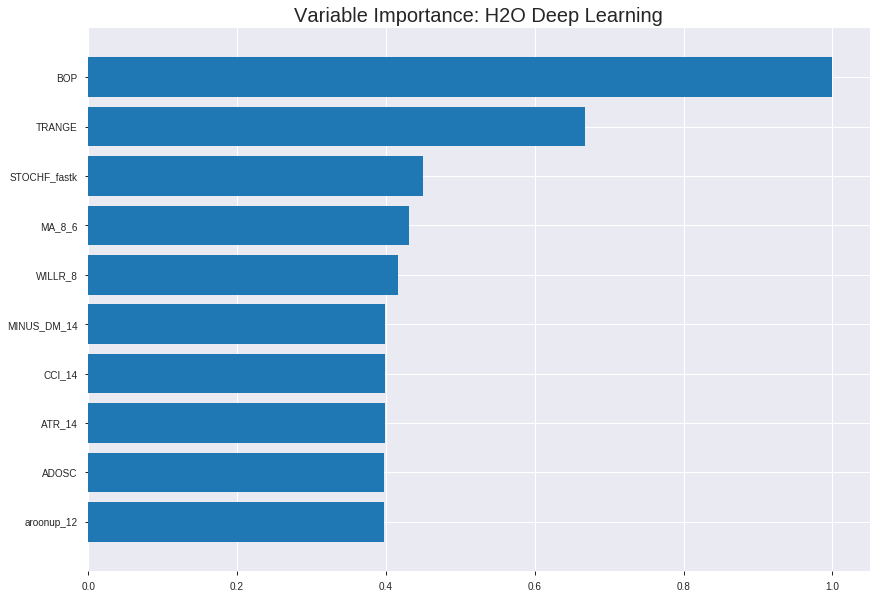

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_080709_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19853531480347514
RMSE: 0.44557301848684144
LogLoss: 0.5799043043817276
Mean Per-Class Error: 0.2914273687907365
AUC: 0.7750916304276718
pr_auc: 0.7363854389336659
Gini: 0.5501832608553436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4282722208213557: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1185  1103  0.4821   (1103.0/2288.0)
1      285   1746  0.1403   (285.0/2031.0)
Total  1470  2849  0.3214   (1388.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428272     0.715574  210
max f2                       0.174841     0.834958  320
max f0point5                 0.56228      0.69371   126
max accuracy                 0.538479     0.708497  146
max precision                0.818142     1         0
max recall                   0.0129793    1         394
max specificity              0.818142     1         0
max absolute_mcc             0.511        0.417323  167
max min_per_class_accuracy   0.533498     0.707041  150
max mean_per_class_accuracy  0.524147     0.708573  157

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 45.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.737944           1.98155   1.98155            0.931818         0.756431   0.931818                    0.756431            0.0201871       0.0201871                  98.1547   98.1547
    2        0.0201436                   0.714576           1.97818   1.97988            0.930233         0.725832   0.931034                    0.741307            0.0196947       0.0398818                  97.8175   97.9881
    3        0.0300996                   0.697497           1.7309    1.89753            0.813953         0.705753   0.892308                    0.729547            0.0172329       0.0571147                  73.0904   89.7527
    4        0.0400556                   0.688869           1.97818   1.91757            0.930233         0.693194   0.901734                    0.720511            0.0196947       0.0768095                  97.8175   91.7572
    5        0.0500116                   0.68149            1.7309    1.88041            0.813953         0.684555   0.884259                    0.713353            0.0172329       0.0940423                  73.0904   88.0411
    6        0.100023                    0.652298           1.69335   1.78688            0.796296         0.666445   0.840278                    0.689899            0.0846873       0.17873                    69.3355   78.6883
    7        0.150035                    0.630837           1.55552   1.70976            0.731481         0.641187   0.804012                    0.673662            0.0777942       0.256524                   55.5524   70.9763
    8        0.200046                    0.614135           1.49645   1.65644            0.703704         0.621999   0.778935                    0.660746            0.07484         0.331364                   49.6453   65.6436
    9        0.300069                    0.583688           1.48169   1.59819            0.696759         0.598048   0.751543                    0.639847            0.148203        0.479567                   48.1685   59.8186
    10       0.400093                    0.560683           1.31924   1.52845            0.62037          0.572115   0.71875                     0.622914            0.131955        0.611521                   31.9242   52.845
    11       0.500116                    0.528588           1.04358   1.43148            0.490741         0.545231   0.673148                    0.607377            0.104382        0.715903                   4.35792   43.1476
    12       0.599907                    0.483709           0.952255  1.35176            0.447796         0.508809   0.635662                    0.590981            0.0950271       0.810931                   -4.77449  35.176
    13       0.699931                    0.38278            0.743304  1.26481            0.349537         0.435432   0.594773                    0.568752            0.0743476       0.885278                   -25.6696  26.4809
    14       0.799954                    0.250508           0.54148   1.17437            0.25463          0.319929   0.552243                    0.53764             0.0541605       0.939439                   -45.852   17.4366
    15       0.899977                    0.110802           0.443029  1.09309            0.208333         0.17813    0.514021                    0.497684            0.0443131       0.983752                   -55.6971  9.30857
    16       1                           0.000121784        0.162444  1                  0.0763889        0.0585418  0.470248                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19894575093908745
RMSE: 0.44603335182370324
LogLoss: 0.5810342150281542
Mean Per-Class Error: 0.28586933614330867
AUC: 0.7684536354056902
pr_auc: 0.7219754052891291
Gini: 0.5369072708113805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46559401117434035: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      362  288  0.4431   (288.0/650.0)
1      95   489  0.1627   (95.0/584.0)
Total  457  777  0.3104   (383.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465594     0.718589  196
max f2                       0.214237     0.836056  307
max f0point5                 0.554247     0.694444  134
max accuracy                 0.52856      0.713128  154
max precision                0.777321     1         0
max recall                   0.0481532    1         382
max specificity              0.777321     1         0
max absolute_mcc             0.52856      0.427694  154
max min_per_class_accuracy   0.535102     0.705479  149
max mean_per_class_accuracy  0.52856      0.714131  154

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.735099           2.11301   2.11301            1                0.748795   1                           0.748795            0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.718914           1.40868   1.77493            0.666667         0.726699   0.84                        0.738189            0.0136986       0.0359589                  40.8676   77.4932
    3        0.0299838                   0.710702           1.76084   1.77036            0.833333         0.714435   0.837838                    0.730485            0.0171233       0.0530822                  76.0845   77.0363
    4        0.0405186                   0.699622           1.46286   1.69041            0.692308         0.706206   0.8                         0.724172            0.015411        0.0684932                  46.2856   69.0411
    5        0.0502431                   0.691469           1.76084   1.70404            0.833333         0.695511   0.806452                    0.718625            0.0171233       0.0856164                  76.0845   70.4043
    6        0.100486                    0.658921           1.77221   1.73812            0.83871          0.675158   0.822581                    0.696891            0.0890411       0.174658                   77.2205   73.8124
    7        0.149919                    0.638856           1.6627    1.71325            0.786885         0.648821   0.810811                    0.681041            0.0821918       0.256849                   66.2699   71.3254
    8        0.200162                    0.621855           1.4314    1.6425             0.677419         0.629724   0.777328                    0.66816             0.0719178       0.328767                   43.1396   64.2505
    9        0.299838                    0.590104           1.32278   1.53622            0.626016         0.606662   0.727027                    0.647716            0.131849        0.460616                   32.2781   53.6218
    10       0.400324                    0.559611           1.32915   1.48424            0.629032         0.576024   0.702429                    0.62972             0.133562        0.594178                   32.9154   48.4242
    11       0.5                         0.529765           1.3056    1.44863            0.617886         0.546167   0.685575                    0.613064            0.130137        0.724315                   30.5602   44.863
    12       0.599676                    0.480468           0.773054  1.33634            0.365854         0.510369   0.632432                    0.595994            0.0770548       0.80137                    -22.6946  33.6338
    13       0.700162                    0.381998           0.869062  1.26928            0.41129          0.440893   0.600694                    0.573734            0.0873288       0.888699                   -13.0938  26.9276
    14       0.799838                    0.264882           0.566906  1.18175            0.268293         0.325063   0.559271                    0.542745            0.0565068       0.945205                   -43.3094  18.1746
    15       0.899514                    0.121499           0.360758  1.09077            0.170732         0.192087   0.516216                    0.503888            0.0359589       0.981164                   -63.9242  9.07719
    16       1                           0.0040219          0.187445  1                  0.0887097        0.0676258  0.473258                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 08:19:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 08:19:44  4 min  9.890 sec  495 obs/sec       0.256309  1             1107       0.464918         0.621024            0.132333       0.712879        0.656039           1.54657          0.371845                         0.468399           0.627491              0.119891         0.704002          0.63199              1.6254             0.363047
    2019-07-25 08:20:17  4 min 42.738 sec  1000 obs/sec      7.36652   29            31816      0.446905         0.583006            0.198265       0.761633        0.714808           1.93322          0.321139                         0.446335           0.582158              0.200856         0.761778          0.716447             1.95047            0.341167
    2019-07-25 08:20:50  5 min 16.064 sec  1143 obs/sec      16.2376   64            70130      0.445573         0.579904            0.203037       0.775092        0.736385           1.98155          0.321371                         0.446033           0.581034              0.201934         0.768454          0.721975             2.11301            0.310373
    2019-07-25 08:21:28  5 min 53.944 sec  1199 obs/sec      26.6073   105           114917     0.434949         0.556594            0.240588       0.789034        0.750942           2.07821          0.304932                         0.447134           0.582728              0.197989         0.758053          0.706678             1.95047            0.317666
    2019-07-25 08:22:02  6 min 28.207 sec  1228 obs/sec      36.0123   142           155537     0.43247          0.548941            0.249221       0.800181        0.770013           2.07821          0.29104                          0.447876           0.58376               0.195327         0.765151          0.722068             1.95047            0.30389
    2019-07-25 08:22:37  7 min  3.240 sec  1257 obs/sec      45.9727   181           198556     0.416775         0.514112            0.302725       0.81965         0.792257           2.12654          0.284325                         0.446055           0.582573              0.201856         0.762478          0.72027              2.11301            0.302269
    2019-07-25 08:23:15  7 min 40.704 sec  1264 obs/sec      56.1505   221           242514     0.416842         0.517339            0.302503       0.834615        0.814545           2.12654          0.279926                         0.449195           0.586716              0.190581         0.757774          0.72082              1.95047            0.330632
    2019-07-25 08:23:18  7 min 44.447 sec  1264 obs/sec      56.1505   221           242514     0.445573         0.579904            0.203037       0.775092        0.736385           1.98155          0.321371                         0.446033           0.581034              0.201934         0.768454          0.721975             2.11301            0.310373

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.05475019134581652
TRANGE             0.6675482988357544     0.6675482988357544   0.03654839709383186
STOCHF_fastk       0.44984209537506104    0.44984209537506104  0.024628940797187637
MA_8_6             0.43148481845855713    0.43148481845855713  0.023623876373420907
WILLR_8            0.41667768359184265    0.41667768359184265  0.02281318290618498
---                ---                    ---                  ---
ROCP_8             0.277086079120636      0.277086079120636    0.015170515851116876
BETA_14            0.2763199210166931     0.2763199210166931   0.015128568548324856
MOM_8              0.27208957076072693    0.27208957076072693  0.014896956062350883
CMO_8              0.2684038281440735     0.2684038281440735   0.014695160948837677
LINEARREG_ANGLE_8  0.23924601078033447    0.23924601078033447  0.013098764868946594


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7277147487844409)

('F1', 0.7529411764705883)

('auc', 0.7899305190020002)

('logloss', 0.5852440712560844)

('mean_per_class_error', 0.27380250552689755)

('rmse', 0.4459623602605134)

('mse', 0.19888242676912793)

deeplearning prediction progress: |███████████████████████████████████████| 100%


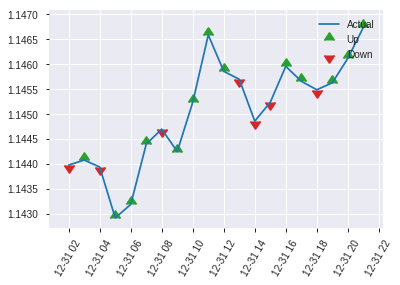


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19888242676912793
RMSE: 0.4459623602605134
LogLoss: 0.5852440712560844
Mean Per-Class Error: 0.27380250552689755
AUC: 0.7899305190020002
pr_auc: 0.7961087232701388
Gini: 0.5798610380040004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5037389807408257: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      193  102  0.3458   (102.0/295.0)
1      66   256  0.205    (66.0/322.0)
Total  259  358  0.2723   (168.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503739     0.752941  199
max f2                       0.135605     0.858696  349
max f0point5                 0.580783     0.740901  124
max accuracy                 0.518815     0.727715  187
max precision                0.76933      1         0
max recall                   0.0288917    1         391
max specificity              0.76933      1         0
max absolute_mcc             0.503739     0.45473   199
max min_per_class_accuracy   0.531002     0.718644  177
max mean_per_class_accuracy  0.518815     0.726197  187

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 45.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.733411           1.91615   1.91615            1                0.75099   1                           0.75099             0.0217391       0.0217391                  91.6149   91.6149
    2        0.0210697                   0.714175           1.91615   1.91615            1                0.722239  1                           0.73772             0.0186335       0.0403727                  91.6149   91.6149
    3        0.0307942                   0.692872           1.59679   1.8153             0.833333         0.703311  0.947368                    0.726854            0.015528        0.0559006                  59.6791   81.5299
    4        0.0405186                   0.687616           1.59679   1.76286            0.833333         0.690183  0.92                        0.718053            0.015528        0.0714286                  59.6791   76.2857
    5        0.0502431                   0.680639           1.91615   1.79253            1                0.685049  0.935484                    0.711665            0.0186335       0.0900621                  91.6149   79.2527
    6        0.100486                    0.652871           1.6689    1.73072            0.870968         0.664559  0.903226                    0.688112            0.0838509       0.173913                   66.8904   73.0715
    7        0.150729                    0.637371           1.60709   1.68951            0.83871          0.644812  0.88172                     0.673679            0.0807453       0.254658                   60.7093   68.9508
    8        0.200972                    0.618684           1.42166   1.62255            0.741935         0.626584  0.846774                    0.661905            0.0714286       0.326087                   42.1659   62.2546
    9        0.299838                    0.587738           1.57061   1.60542            0.819672         0.602244  0.837838                    0.642233            0.15528         0.481366                   57.0614   60.5422
    10       0.400324                    0.560954           1.1126    1.48172            0.580645         0.575469  0.773279                    0.625474            0.111801        0.593168                   11.2603   48.1719
    11       0.50081                     0.53404            1.14351   1.41386            0.596774         0.549083  0.737864                    0.610147            0.114907        0.708075                   14.3508   41.3858
    12       0.599676                    0.493742           0.910956  1.33095            0.47541          0.514765  0.694595                    0.594421            0.0900621       0.798137                   -8.90439  33.0947
    13       0.700162                    0.379144           0.679924  1.23751            0.354839         0.450375  0.645833                    0.573748            0.068323        0.86646                    -32.0076  23.7513
    14       0.799028                    0.262314           0.753895  1.17767            0.393443         0.311261  0.614604                    0.54127             0.0745342       0.940994                   -24.6105  17.7674
    15       0.899514                    0.124868           0.401773  1.091              0.209677         0.196786  0.569369                    0.502787            0.0403727       0.981366                   -59.8227  9.09966
    16       1                           0.00361528         0.185434  1                  0.0967742        0.071854  0.52188                     0.459484         

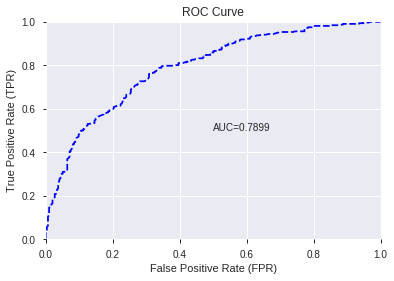

This function is available for GLM models only


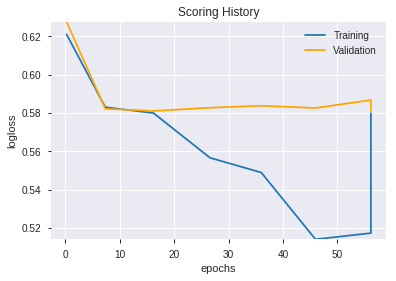

--2019-07-25 08:29:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.82.98
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.82.98|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_080709_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_080709_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'MA_8_6',
 'WILLR_8',
 'MINUS_DM_14',
 'CCI_14',
 'ATR_14',
 'ADOSC',
 'aroonup_12',
 'NATR_30',
 'aroondown_30',
 'aroonup_20',
 'STOCHRSI_fastk',
 'PLUS_DI_8',
 'ADXR_14',
 'RSI_30',
 'aroonup_8',
 'STDDEV_12',
 'HT_PHASOR_quadrature',
 'aroondown_12',
 'AROONOSC_8',
 'ADXR_8',
 'DX_12',
 'MOM_30',
 'MFI_8',
 'STDDEV_30',
 'MFI_14',
 'STOCHRSI_fastd',
 'HT_PHASOR_inphase',
 'MFI_12',
 'WILLR_24',
 'BETA_8',
 'PLUS_DM_12',
 'LINEARREG_ANGLE_20',
 'STOCH_slowd',
 'BETA_20',
 'DX_24',
 'DX_20',
 'MFI_30',
 'VAR_30',
 'STOCHF_fastd',
 'WILLR_12',
 'MOM_20',
 'WILLR_14',
 'ROCP_8',
 'BETA_14',
 'MOM_8',
 'CMO_8',
 'LINEARREG_ANGLE_8']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_083005_model_1  0.784609  0.564273              0.294873  0.437282  0.191215

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.744217           1.000000    0.114066
1            MINUS_DM_14             0.452023           0.607380    0.069281
2                 TRANGE             0.385453           0.517931    0.059078
3              PLUS_DI_8             0.371521           0.499211    0.056943
4                 ATR_14             0.355699           0.477951    0.054518
5                WILLR_8             0.349465           0.469574    0.053562
6            STOCH_slowd             0.345023           0.463606    0.052881
7           STOCHF_fastk             0.301087           0.404568    0.046147
8                 CCI_14             0.248459           0.333853    0.038081
9              STDDEV_30             0.226758           0.304694    0.034755
10        STOCHRSI_fastk             0.197194           0.264968    0.030224
11                RSI_30             0.192995           0.259326    0.029580
12                 CMO_8             0.178788           0.240236    0.027403
13                MFI_30             0.162243           0.218005    0.024867
14     LINEARREG_ANGLE_8             0.147147           0.197720    0.022553
15                 ADOSC             0.139086           0.186890    0.021318
16                 DX_20             0.133113           0.178864    0.020402
17                MOM_30             0.127469           0.171279    0.019537
18               NATR_30             0.126731           0.170288    0.019424
19                VAR_30             0.113815           0.152933    0.017444
20              WILLR_24             0.096140           0.129183    0.014735
21             STDDEV_12             0.094461           0.126926    0.014478
22                 MFI_8             0.085666           0.115108    0.013130
23                 DX_24             0.077843           0.104597    0.011931
24            aroonup_12             0.074689           0.100359    0.011448
25            PLUS_DM_12             0.067367           0.090520    0.010325
26                ROCP_8             0.067331           0.090473    0.010320
27               BETA_14             0.052498           0.070542    0.008046
28             aroonup_8             0.051520           0.069227    0.007896
29                ADXR_8             0.050143           0.067377    0.007685
30                BETA_8             0.049538           0.066564    0.007593
31          STOCHF_fastd             0.047919           0.064389    0.007345
32     HT_PHASOR_inphase             0.046063           0.061895    0.007060
33               BETA_20             0.039759           0.053424    0.006094
34          aroondown_30             0.037535           0.050435    0.005753
35               ADXR_14             0.037080           0.049825    0.005683
36                MA_8_6             0.031406           0.042200    0.004814
37        STOCHRSI_fastd             0.030846           0.041448    0.004728
38                MFI_12             0.027556           0.037027    0.004223
39            aroonup_20             0.022971           0.030866    0.003521
40                MFI_14             0.022317           0.029988    0.003421
41                MOM_20             0.021855           0.029367    0.003350
42            AROONOSC_8             0.020744           0.027873    0.003179
43    LINEARREG_ANGLE_20             0.015757           0.021173    0.002415
44          aroondown_12             0.012973           0.017432    0.001988
45              WILLR_14             0.012453           0.016733    0.001909
46                 DX_12             0.011081           0.014889    0.001698
47              WILLR_12             0.008594           0.011548    0.001317
48                 MOM_8             0.007577           0.010181    0.001161
49  HT_PHASOR_quadrature             0.004497           0.006043    0.000689

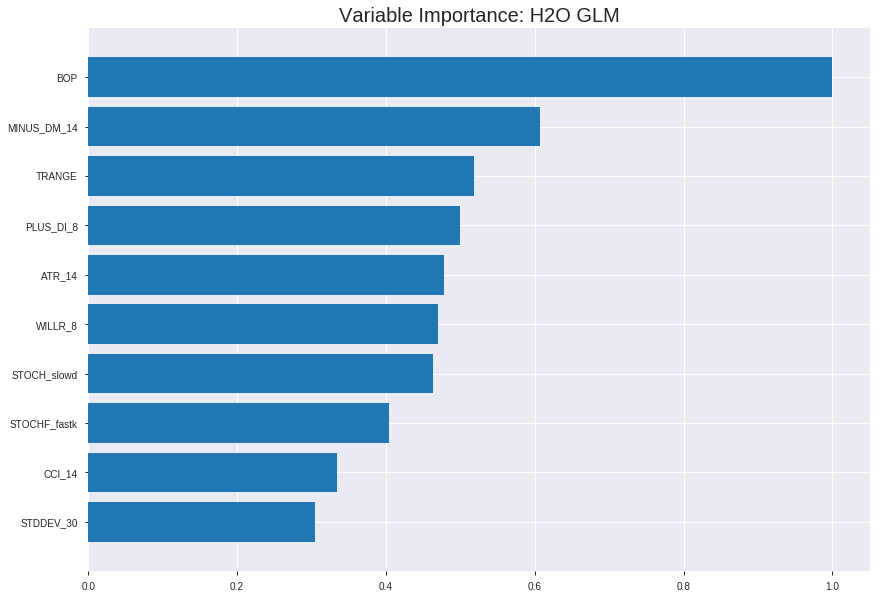

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_083005_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19645088437395944
RMSE: 0.4432278018964508
LogLoss: 0.5762142638131472
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5972.1036478564565
Residual deviance: 4977.338810817966
AIC: 5079.338810817966
AUC: 0.7659062072836076
pr_auc: 0.7215786508167136
Gini: 0.5318124145672152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3960251808364155: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1316  972   0.4248   (972.0/2288.0)
1      377   1654  0.1856   (377.0/2031.0)
Total  1693  2626  0.3123   (1349.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396025     0.710329  238
max f2                       0.135992     0.829282  357
max f0point5                 0.514424     0.686076  183
max accuracy                 0.493951     0.704793  192
max precision                0.968        1         0
max recall                   0.0402654    1         392
max specificity              0.968        1         0
max absolute_mcc             0.458041     0.408514  208
max min_per_class_accuracy   0.489545     0.704087  194
max mean_per_class_accuracy  0.489545     0.704535  194

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.868309           1.78823   1.78823            0.840909         0.89289   0.840909                    0.89289             0.0182176       0.0182176                  78.8226   78.8226
    2        0.0201436                   0.852852           1.92872   1.85767            0.906977         0.859705  0.873563                    0.876488            0.0192024       0.03742                    92.8721   85.7666
    3        0.0300996                   0.838326           1.68145   1.79938            0.790698         0.844448  0.846154                    0.86589             0.0167405       0.0541605                  68.1449   79.9379
    4        0.0400556                   0.82193            1.82981   1.80694            0.860465         0.82956   0.849711                    0.85686             0.0182176       0.0723781                  82.9812   80.6943
    5        0.0500116                   0.814651           1.7309    1.79181            0.813953         0.818439  0.842593                    0.849212            0.0172329       0.089611                   73.0904   79.1806
    6        0.100023                    0.770415           1.67366   1.73274            0.787037         0.793159  0.814815                    0.821185            0.0837026       0.173314                   67.3665   73.2735
    7        0.150035                    0.732595           1.62444   1.69664            0.763889         0.75097   0.79784                     0.79778             0.0812408       0.254554                   62.4439   69.6637
    8        0.200046                    0.696299           1.56537   1.66382            0.736111         0.71342   0.782407                    0.77669             0.0782866       0.332841                   56.5369   66.382
    9        0.300069                    0.621816           1.42754   1.58506            0.671296         0.659505  0.74537                     0.737628            0.142787        0.475628                   42.7538   58.5059
    10       0.400093                    0.554321           1.25033   1.50138            0.587963         0.588882  0.706019                    0.700442            0.125062        0.600689                   25.0326   50.1376
    11       0.500116                    0.479455           1.13711   1.42852            0.534722         0.516498  0.671759                    0.663653            0.113737        0.714426                   13.7107   42.8522
    12       0.599907                    0.401381           0.932519  1.34601            0.438515         0.440101  0.63296                     0.626466            0.0930576       0.807484                   -6.74807  34.6014
    13       0.699931                    0.320132           0.728536  1.25777            0.342593         0.362133  0.591465                    0.588692            0.0728705       0.880355                   -27.1464  25.7774
    14       0.799954                    0.237139           0.575938  1.17252            0.270833         0.276705  0.551375                    0.549682            0.0576071       0.937962                   -42.4062  17.252
    15       0.899977                    0.159819           0.393803  1.08597            0.185185         0.199618  0.510677                    0.510776            0.0393895       0.977351                   -60.6197  8.59736
    16       1                           0.00305755         0.226437  1                  0.106481         0.105586  0.470248                    0.470248           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19593691352626458
RMSE: 0.4426476177799499
LogLoss: 0.5745172945976691
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1707.2004406915303
Residual deviance: 1417.9086830670474
AIC: 1519.9086830670474
AUC: 0.7665529504741834
pr_auc: 0.7237055327372445
Gini: 0.5331059009483667
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3213937505779785: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      305  345  0.5308   (345.0/650.0)
1      60   524  0.1027   (60.0/584.0)
Total  365  869  0.3282   (405.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321394     0.721266  275
max f2                       0.164166     0.83285   349
max f0point5                 0.469662     0.69517   201
max accuracy                 0.469662     0.714749  201
max precision                0.944488     1         0
max recall                   0.0712599    1         387
max specificity              0.944488     1         0
max absolute_mcc             0.469662     0.430379  201
max min_per_class_accuracy   0.479494     0.710616  195
max mean_per_class_accuracy  0.469662     0.715495  201

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 46.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.872839           1.78793   1.78793            0.846154         0.887413  0.846154                    0.887413            0.0188356       0.0188356                  78.7935   78.7935
    2        0.0202593                   0.857466           1.93693   1.85945            0.916667         0.865717  0.88                        0.876999            0.0188356       0.0376712                  93.6929   85.9452
    3        0.0299838                   0.845208           1.93693   1.88458            0.916667         0.852832  0.891892                    0.869161            0.0188356       0.0565068                  93.6929   88.458
    4        0.0405186                   0.833102           1.78793   1.85945            0.846154         0.840342  0.88                        0.861668            0.0188356       0.0753425                  78.7935   85.9452
    5        0.0502431                   0.815889           1.76084   1.84037            0.833333         0.82509   0.870968                    0.854588            0.0171233       0.0924658                  76.0845   84.0367
    6        0.100486                    0.76685            1.63588   1.73812            0.774194         0.790698  0.822581                    0.822643            0.0821918       0.174658                   63.5882   73.8124
    7        0.149919                    0.731613           1.45486   1.64472            0.688525         0.74995   0.778378                    0.798674            0.0719178       0.246575                   45.4862   64.4724
    8        0.200162                    0.692441           1.53364   1.61684            0.725806         0.713338  0.765182                    0.777254            0.0770548       0.32363                    53.3639   61.684
    9        0.299838                    0.627529           1.51175   1.5819             0.715447         0.65997   0.748649                    0.738265            0.150685        0.474315                   51.175    58.1905
    10       0.400324                    0.551839           1.19283   1.48424            0.564516         0.586371  0.702429                    0.700138            0.119863        0.594178                   19.283    48.4242
    11       0.5                         0.470176           1.32278   1.45205            0.626016         0.510335  0.687196                    0.6623              0.131849        0.726027                   32.2781   45.2055
    12       0.599676                    0.397418           0.704338  1.32777            0.333333         0.433527  0.628378                    0.624274            0.0702055       0.796233                   -29.5662  32.7772
    13       0.700162                    0.326279           0.937224  1.27172            0.443548         0.364149  0.601852                    0.586941            0.0941781       0.890411                   -6.27762  27.1721
    14       0.799838                    0.231775           0.515369  1.17746            0.243902         0.277161  0.557244                    0.548337            0.0513699       0.941781                   -48.4631  17.7465
    15       0.899514                    0.162969           0.412295  1.09268            0.195122         0.200198  0.517117                    0.509759            0.0410959       0.982877                   -58.7705  9.26756
    16       1                           0.0131208          0.170404  1                  0.0806452        0.1099    0.473258                    0.469579           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 08:30:05  0.000 sec   2            .2E2      51            1.371227436014788   1.3713942052526447
     2019-07-25 08:30:05  0.018 sec   4            .12E2     51            1.365299227311215   1.365177340007144
     2019-07-25 08:30:05  0.037 sec   6            .77E1     51            1.3568791232633008  1.356346149495441
     2019-07-25 08:30:05  0.057 sec   8            .48E1     51            1.3453634562365215  1.3442862187529077
     2019-07-25 08:30:05  0.076 sec   10           .3E1      51            1.3301834238774342  1.328413572249025
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 08:30:06  0.443 sec   42           .15E-2    51            1.151834763536225   1.1491524727432068
     2019-07-25 08:30:06  0.453 sec   43           .91E-3    51            1.15144277584582    1.1493131031519477
     2019-07-25 08:30:06  0.464 sec   44           .56E-3    51            1.1511952331949502  1.1494525575626837
     2019-07-25 08:30:06  0.475 sec   45           .35E-3    51            1.1510475869091705  1.1495445315874853
     2019-07-25 08:30:06  0.486 sec   46           .22E-3    51            1.150960190233997   1.1495831695567122


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7147487844408428)

('F1', 0.7548209366391185)

('auc', 0.7846089062006527)

('logloss', 0.5642732250084661)

('mean_per_class_error', 0.2891778081903358)

('rmse', 0.43728187994418327)

('mse', 0.1912154425275191)

glm prediction progress: |████████████████████████████████████████████████| 100%


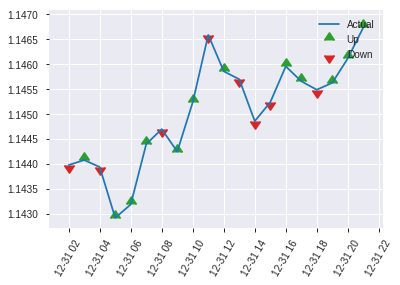


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1912154425275191
RMSE: 0.43728187994418327
LogLoss: 0.5642732250084661
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 860.749207800923
Residual deviance: 696.3131596604472
AIC: 798.3131596604472
AUC: 0.7846089062006527
pr_auc: 0.7937968231847278
Gini: 0.5692178124013054
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3655288678752935: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      165  130  0.4407   (130.0/295.0)
1      48   274  0.1491   (48.0/322.0)
Total  213  404  0.2885   (178.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365529     0.754821  257
max f2                       0.184706     0.860274  341
max f0point5                 0.52963      0.728731  175
max accuracy                 0.405018     0.714749  238
max precision                0.918238     1         0
max recall                   0.048281     1         392
max specificity              0.918238     1         0
max absolute_mcc             0.391748     0.431911  245
max min_per_class_accuracy   0.490427     0.701863  196
max mean_per_class_accuracy  0.511679     0.710822  187

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 47.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.857895           1.91615   1.91615            1                0.883665  1                           0.883665            0.0217391       0.0217391                  91.6149   91.6149
    2        0.0210697                   0.841702           1.91615   1.91615            1                0.848814  1                           0.86758             0.0186335       0.0403727                  91.6149   91.6149
    3        0.0307942                   0.831956           1.91615   1.91615            1                0.836084  1                           0.857634            0.0186335       0.0590062                  91.6149   91.6149
    4        0.0405186                   0.825096           1.59679   1.8395             0.833333         0.829271  0.96                        0.850827            0.015528        0.0745342                  59.6791   83.9503
    5        0.0502431                   0.813081           1.59679   1.79253            0.833333         0.820581  0.935484                    0.844973            0.015528        0.0900621                  59.6791   79.2527
    6        0.100486                    0.770237           1.73072   1.76162            0.903226         0.794019  0.919355                    0.819496            0.0869565       0.177019                   73.0715   76.1621
    7        0.150729                    0.740515           1.48347   1.6689             0.774194         0.754452  0.870968                    0.797815            0.0745342       0.251553                   48.347    66.8904
    8        0.200972                    0.711092           1.6689    1.6689             0.870968         0.724931  0.870968                    0.779594            0.0838509       0.335404                   66.8904   66.8904
    9        0.299838                    0.649052           1.38214   1.57435            0.721311         0.680533  0.821622                    0.74693             0.136646        0.47205                    38.214    57.435
    10       0.400324                    0.567513           1.1126    1.45845            0.580645         0.612617  0.761134                    0.713216            0.111801        0.583851                   11.2603   45.8445
    11       0.50081                     0.497817           1.14351   1.39525            0.596774         0.531158  0.728155                    0.676687            0.114907        0.698758                   14.3508   39.5254
    12       0.599676                    0.408887           1.00519   1.33095            0.52459          0.44959   0.694595                    0.639246            0.0993789       0.798137                   0.519295  33.0947
    13       0.700162                    0.330953           0.803546  1.25526            0.419355         0.368608  0.655093                    0.600405            0.0807453       0.878882                   -19.6454  25.5255
    14       0.799028                    0.242601           0.596833  1.17379            0.311475         0.28657   0.612576                    0.561573            0.0590062       0.937888                   -40.3167  17.3787
    15       0.899514                    0.154567           0.401773  1.08754            0.209677         0.196452  0.567568                    0.520785            0.0403727       0.978261                   -59.8227  8.75441
    16       1                           0.0113198          0.216339  1                  0.112903         0.104396  0.52188                     0.478944          

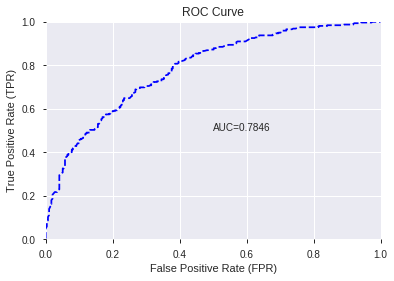

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


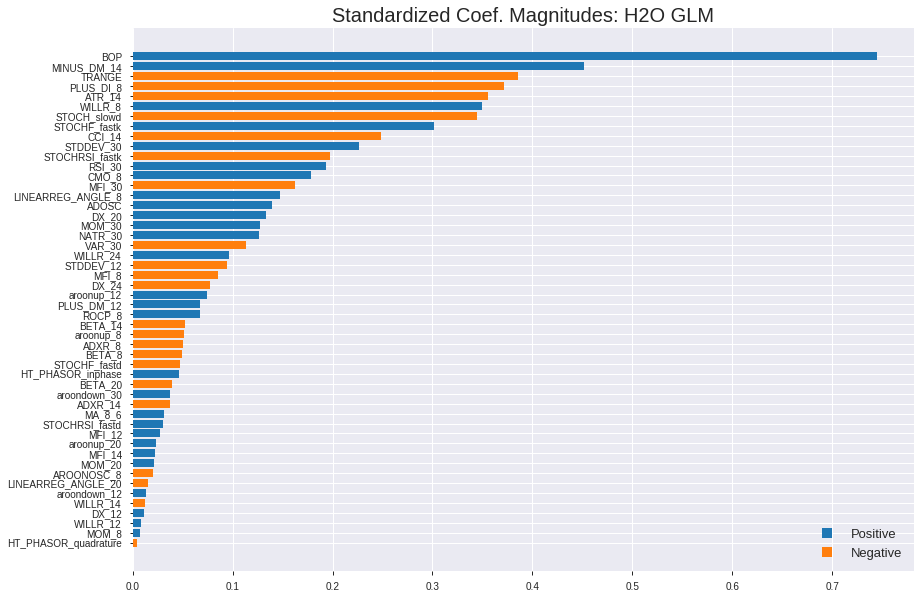

'log_likelihood'
--2019-07-25 08:30:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_083005_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_083005_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'MINUS_DM_14',
 'TRANGE',
 'PLUS_DI_8',
 'ATR_14',
 'WILLR_8',
 'STOCH_slowd',
 'STOCHF_fastk',
 'CCI_14',
 'STDDEV_30',
 'STOCHRSI_fastk',
 'RSI_30',
 'CMO_8',
 'MFI_30',
 'LINEARREG_ANGLE_8',
 'ADOSC',
 'DX_20',
 'MOM_30',
 'NATR_30',
 'VAR_30',
 'WILLR_24',
 'STDDEV_12',
 'MFI_8',
 'DX_24',
 'aroonup_12',
 'PLUS_DM_12',
 'ROCP_8',
 'BETA_14',
 'aroonup_8',
 'ADXR_8',
 'BETA_8',
 'STOCHF_fastd',
 'HT_PHASOR_inphase',
 'BETA_20',
 'aroondown_30',
 'ADXR_14',
 'MA_8_6',
 'STOCHRSI_fastd',
 'MFI_12',
 'aroonup_20',
 'MFI_14',
 'MOM_20',
 'AROONOSC_8',
 'LINEARREG_ANGLE_20',
 'aroondown_12',
 'WILLR_14',
 'DX_12',
 'WILLR_12',
 'MOM_8',
 'HT_PHASOR_quadrature']

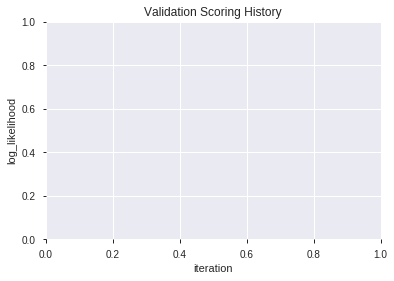

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_083113_model_4  0.787257  0.564627              0.298974  0.436684  0.190693
1  XGBoost_grid_1_AutoML_20190725_083113_model_2  0.786672  0.567296              0.302790  0.437885  0.191744
2  XGBoost_grid_1_AutoML_20190725_083113_model_3  0.781656  0.571051              0.302637  0.440066  0.193658
3  XGBoost_grid_1_AutoML_20190725_083113_model_6  0.781366  0.575079              0.325819  0.441775  0.195165
4               XGBoost_3_AutoML_20190725_083113  0.781045  0.575194              0.296568  0.441659  0.195062
5               XGBoost_2_AutoML_20190725_083113  0.777908  0.572170              0.303632  0.440222  0.193795
6  XGBoost_grid_1_AutoML_20190725_083113_model_1  0.777550  0.576119              0.307590  0.442713  0.195995
7  XGBoost_grid_1_AutoML_20190725_083113_model_5  0.777271  0.577326              0.323129  0.441519  0.194939
8               XGBoost_1_AutoML_20190725_083113  0.771034  0.580836              0.293026  0.444306  0.197408
9  XGBoost_grid_1_AutoML_20190725_083113_model_7  0.769376  0.579936              0.311822  0.443951  0.197092

variable  relative_importance  scaled_importance  percentage
0                    BOP          5070.294922           1.000000    0.402341
1                 TRANGE          1151.926514           0.227191    0.091408
2           STOCHF_fastk           786.936646           0.155205    0.062445
3                 CCI_14           307.314117           0.060611    0.024386
4                  ADOSC           296.432129           0.058464    0.023523
5              aroonup_8           286.927460           0.056590    0.022768
6         STOCHRSI_fastd           244.209641           0.048165    0.019379
7              STDDEV_30           234.118225           0.046174    0.018578
8                  MFI_8           203.204544           0.040077    0.016125
9                WILLR_8           198.921875           0.039233    0.015785
10               NATR_30           178.392197           0.035184    0.014156
11             STDDEV_12           174.750854           0.034466    0.013867
12              WILLR_12           174.548996           0.034426    0.013851
13                MFI_14           160.385254           0.031632    0.012727
14  HT_PHASOR_quadrature           151.015839           0.029784    0.011984
15            aroonup_12           145.773804           0.028751    0.011568
16             PLUS_DI_8           141.751663           0.027957    0.011248
17        STOCHRSI_fastk           140.799500           0.027769    0.011173
18                 DX_12           136.212936           0.026865    0.010809
19              WILLR_24           125.372009           0.024727    0.009949
20                BETA_8           119.072708           0.023484    0.009449
21            PLUS_DM_12           118.203850           0.023313    0.009380
22                ADXR_8           115.890038           0.022857    0.009196
23                ATR_14           114.327484           0.022548    0.009072
24               BETA_14           113.547981           0.022395    0.009010
25               ADXR_14           111.473824           0.021986    0.008846
26                MFI_12           104.664467           0.020643    0.008305
27                RSI_30           103.235077           0.020361    0.008192
28               BETA_20           101.970177           0.020111    0.008092
29           MINUS_DM_14            99.401871           0.019605    0.007888
30    LINEARREG_ANGLE_20            94.290421           0.018597    0.007482
31                MFI_30            89.664032           0.017684    0.007115
32           STOCH_slowd            85.821533           0.016926    0.006810
33                 DX_20            85.434784           0.016850    0.006779
34     HT_PHASOR_inphase            84.285957           0.016623    0.006688
35                MA_8_6            77.606781           0.015306    0.006158
36          aroondown_30            76.414230           0.015071    0.006064
37     LINEARREG_ANGLE_8            73.733963           0.014542    0.005851
38          aroondown_12            67.310013           0.013275    0.005341
39            AROONOSC_8            67.198189           0.013253    0.005332
40              WILLR_14            62.357246           0.012299    0.004948
41                MOM_20            55.624424           0.010971    0.004414
42                 MOM_8            55.043671           0.010856    0.004368
43                 DX_24            54.741718           0.010797    0.004344
44                ROCP_8            44.631947           0.008803    0.003542
45          STOCHF_fastd            44.291214           0.008735    0.003515
46            aroonup_20            33.067368           0.006522    0.002624
47                MOM_30            26.609509           0.005248    0.002112
48                 CMO_8            12.774905           0.002520    0.001014

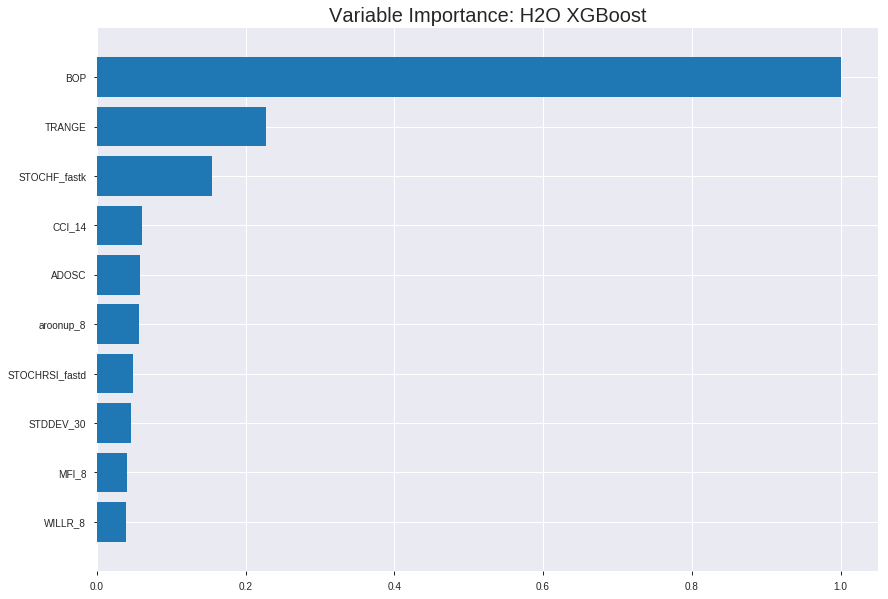

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_083113_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17356746919108204
RMSE: 0.4166142930710396
LogLoss: 0.5233379667509269
Mean Per-Class Error: 0.25846021285459986
AUC: 0.8278796228390024
pr_auc: 0.8054574583121562
Gini: 0.6557592456780048
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3654083183833531: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1317  971   0.4244   (971.0/2288.0)
1      241   1790  0.1187   (241.0/2031.0)
Total  1558  2761  0.2806   (1212.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365408     0.747078  251
max f2                       0.222239     0.849194  323
max f0point5                 0.594083     0.746296  139
max accuracy                 0.54066      0.743691  168
max precision                0.897394     1         0
max recall                   0.104846     1         382
max specificity              0.897394     1         0
max absolute_mcc             0.54066      0.484595  168
max min_per_class_accuracy   0.504969     0.738636  186
max mean_per_class_accuracy  0.482365     0.74154   198

Gains/Lift Table: Avg response rate: 47.02 %, avg score: 47.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.852556           2.12654    2.12654            1                0.866798  1                           0.866798            0.0216642       0.0216642                  112.654   112.654
    2        0.0201436                   0.833134           2.02763    2.07765            0.953488         0.84486   0.977011                    0.855955            0.0201871       0.0418513                  102.763   107.765
    3        0.0300996                   0.820305           1.92872    2.02839            0.906977         0.82614   0.953846                    0.846093            0.0192024       0.0610537                  92.8721   102.839
    4        0.0400556                   0.810229           1.92872    2.00362            0.906977         0.815993  0.942197                    0.838612            0.0192024       0.080256                   92.8721   100.362
    5        0.0500116                   0.797196           2.02763    2.0084             0.953488         0.803989  0.944444                    0.831719            0.0201871       0.100443                   102.763   100.84
    6        0.100023                    0.752647           1.91979    1.96409            0.902778         0.774533  0.923611                    0.803126            0.0960118       0.196455                   91.9792   96.4095
    7        0.150035                    0.716792           1.8115     1.91323            0.851852         0.73463   0.899691                    0.780294            0.0905958       0.287051                   81.1496   91.3228
    8        0.200046                    0.689121           1.73274    1.86811            0.814815         0.703171  0.878472                    0.761013            0.0866568       0.373708                   73.2735   86.8105
    9        0.300069                    0.628497           1.48169    1.7393             0.696759         0.658136  0.817901                    0.726721            0.148203        0.52191                    48.1685   73.9299
    10       0.400093                    0.567242           1.25525    1.61829            0.590278         0.59712   0.760995                    0.694321            0.125554        0.647464                   25.5249   61.8286
    11       0.500116                    0.49425            1.06819    1.50827            0.502315         0.531939  0.709259                    0.661844            0.106844        0.754308                   6.81919   50.8267
    12       0.599907                    0.402399           0.927585   1.41167            0.436195         0.449173  0.663836                    0.626468            0.0925652       0.846873                   -7.24147  41.1674
    13       0.699931                    0.31559            0.699001   1.30983            0.328704         0.357232  0.615944                    0.587993            0.0699163       0.91679                    -30.0999  30.983
    14       0.799954                    0.236563           0.502099   1.20883            0.236111         0.273612  0.568452                    0.548684            0.0502216       0.967011                   -49.7901  20.8834
    15       0.899977                    0.165748           0.25105    1.10239            0.118056         0.199214  0.518395                    0.509844            0.0251108       0.992122                   -74.895   10.2386
    16       1                           0.055138           0.0787607  1                  0.037037         0.122423  0.470248                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19440420251715898
RMSE: 0.4409129194264543
LogLoss: 0.5716773233102428
Mean Per-Class Error: 0.2817623814541623
AUC: 0.7706217070600632
pr_auc: 0.7287806970471491
Gini: 0.5412434141201263
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4148476541042328: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      400  250  0.3846   (250.0/650.0)
1      117  467  0.2003   (117.0/584.0)
Total  517  717  0.2974   (367.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414848     0.717909  227
max f2                       0.199626     0.834569  333
max f0point5                 0.482884     0.69696   196
max accuracy                 0.482884     0.71718   196
max precision                0.878742     1         0
max recall                   0.114023     1         380
max specificity              0.878742     1         0
max absolute_mcc             0.482884     0.435908  196
max min_per_class_accuracy   0.499773     0.713846  189
max mean_per_class_accuracy  0.482884     0.718238  196

Gains/Lift Table: Avg response rate: 47.33 %, avg score: 47.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.845824           2.11301   2.11301            1                0.859586  1                           0.859586            0.0222603       0.0222603                  111.301   111.301
    2        0.0202593                   0.827443           1.76084   1.94397            0.833333         0.83685   0.92                        0.848672            0.0171233       0.0393836                  76.0845   94.3973
    3        0.0299838                   0.811088           1.93693   1.94169            0.916667         0.820244  0.918919                    0.839452            0.0188356       0.0582192                  93.6929   94.1688
    4        0.0405186                   0.804756           1.95047   1.94397            0.923077         0.808326  0.92                        0.831359            0.0205479       0.0787671                  95.0474   94.3973
    5        0.0502431                   0.793517           1.23259   1.80629            0.583333         0.797869  0.854839                    0.824877            0.0119863       0.0907534                  23.2591   80.6286
    6        0.100486                    0.753408           1.6018    1.70404            0.758065         0.770416  0.806452                    0.797647            0.0804795       0.171233                   60.1801   70.4043
    7        0.149919                    0.718046           1.62806   1.67899            0.770492         0.737382  0.794595                    0.777776            0.0804795       0.251712                   62.806    67.8989
    8        0.200162                    0.69259            1.39732   1.60829            0.66129          0.704923  0.761134                    0.759489            0.0702055       0.321918                   39.7316   60.8286
    9        0.299838                    0.637486           1.52893   1.5819             0.723577         0.665178  0.748649                    0.728137            0.152397        0.474315                   52.8929   58.1905
    10       0.400324                    0.570316           1.24395   1.49707            0.58871          0.605534  0.708502                    0.697362            0.125           0.599315                   24.3952   49.7074
    11       0.5                         0.49078            1.25407   1.44863            0.593496         0.529667  0.685575                    0.663932            0.125           0.724315                   25.4065   44.863
    12       0.599676                    0.399457           0.824591  1.3449             0.390244         0.441511  0.636486                    0.626962            0.0821918       0.806507                   -17.5409  34.4905
    13       0.700162                    0.306123           0.78386   1.26438            0.370968         0.354523  0.59838                     0.587862            0.0787671       0.885274                   -21.614   26.4384
    14       0.799838                    0.235607           0.618443  1.18389            0.292683         0.269678  0.560284                    0.54821             0.0616438       0.946918                   -38.1557  18.3887
    15       0.899514                    0.159025           0.292043  1.08506            0.138211         0.194981  0.513514                    0.509068            0.0291096       0.976027                   -70.7957  8.50611
    16       1                           0.0585928          0.238566  1                  0.112903         0.12459   0.473258                    0.470433          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 08:31:27  5.504 sec   0                  0.5              0.693147            0.5             0                  1                0.529752                         0.5                0.693147              0.5               0                    1                  0.526742
    2019-07-25 08:31:27  5.613 sec   5                  0.47863          0.651068            0.778579        0.736567           2.08129          0.317666                         0.480566           0.654813              0.755591          0.705436             2.11301            0.34684
    2019-07-25 08:31:27  5.698 sec   10                 0.463471         0.621471            0.787815        0.75002            2.02988          0.313267                         0.467966           0.630002              0.757333          0.717606             2.11301            0.329822
    2019-07-25 08:31:28  5.805 sec   15                 0.453344         0.601316            0.790257        0.753761           2.07821          0.315582                         0.459349           0.612654              0.760398          0.721247             2.11301            0.340357
    2019-07-25 08:31:28  5.908 sec   20                 0.446328         0.586896            0.792892        0.759318           2.07821          0.312109                         0.454007           0.601418              0.760898          0.719855             2.11301            0.322528
    2019-07-25 08:31:28  6.018 sec   25                 0.440736         0.575118            0.79691         0.763585           2.07821          0.312804                         0.450667           0.594021              0.761446          0.722186             2.11301            0.314425
    2019-07-25 08:31:28  6.129 sec   30                 0.436897         0.566707            0.79927         0.767661           2.07821          0.313267                         0.448576           0.589118              0.761313          0.72274              2.11301            0.311183
    2019-07-25 08:31:28  6.243 sec   35                 0.433539         0.559327            0.802152        0.772808           2.12654          0.295439                         0.446309           0.58401               0.764013          0.726471             2.11301            0.309562
    2019-07-25 08:31:28  6.361 sec   40                 0.430803         0.553346            0.805649        0.777145           2.12654          0.308405                         0.445162           0.581186              0.764601          0.725803             2.11301            0.311994
    2019-07-25 08:31:28  6.481 sec   45                 0.427979         0.54735             0.809897        0.782593           2.07821          0.289187                         0.443869           0.578362              0.76645           0.728139             2.11301            0.356564
    2019-07-25 08:31:28  6.612 sec   50                 0.425474         0.542077            0.814014        0.788152           2.12654          0.291966                         0.44282            0.576                 0.768076          0.730668             2.11301            0.307131
    2019-07-25 08:31:28  6.741 sec   55                 0.423347         0.537609            0.817457        0.792852           2.12654          0.286409                         0.442578           0.575459              0.768214          0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           5070.294921875         1.0                    0.40234118163084875
TRANGE        1151.926513671875      0.2271912248540153     0.09140838586392436
STOCHF_fastk  786.9366455078125      0.15520530021097917    0.06244548388225597
CCI_14        307.3141174316406      0.060610698621451305   0.024386180102825974
ADOSC         296.43212890625        0.05846447464571333    0.0235226658123831
---           ---                    ---                    ---
ROCP_8        44.6319465637207       0.008802633229708808   0.0035416618551040164
STOCHF_fastd  44.29121398925781      0.008735431502844193   0.0035146238329096737
aroonup_20    33.06736755371094      0.006521783853449415   0.002623982221937828
MOM_30        26.609508514404297     0.005248118487072952   0.0021115341934276337
CMO_8         12.77490520477295      0.0025195586058825896  0.0010137221866789751


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7212317666126418)

('F1', 0.7560975609756097)

('auc', 0.7872565533214023)

('logloss', 0.5646269332410304)

('mean_per_class_error', 0.2766028002947678)

('rmse', 0.4366842830398796)

('mse', 0.19069316305405368)

xgboost prediction progress: |████████████████████████████████████████████| 100%


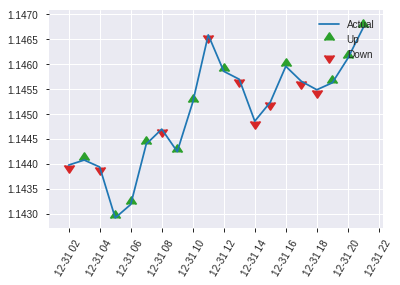


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19069316305405368
RMSE: 0.4366842830398796
LogLoss: 0.5646269332410304
Mean Per-Class Error: 0.2766028002947678
AUC: 0.7872565533214023
pr_auc: 0.7852621422737242
Gini: 0.5745131066428046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35650911927223206: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  137  0.4644   (137.0/295.0)
1      43   279  0.1335   (43.0/322.0)
Total  201  416  0.2917   (180.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356509     0.756098  264
max f2                       0.171715     0.859163  352
max f0point5                 0.562626     0.745429  166
max accuracy                 0.54778      0.721232  173
max precision                0.873489     1         0
max recall                   0.0600039    1         399
max specificity              0.873489     1         0
max absolute_mcc             0.54778      0.447781  173
max min_per_class_accuracy   0.50025      0.714286  193
max mean_per_class_accuracy  0.54778      0.723397  173

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 48.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.853828           1.91615   1.91615            1                0.863472  1                           0.863472            0.0217391       0.0217391                  91.6149   91.6149
    2        0.0210697                   0.820174           1.59679   1.76875            0.833333         0.8336    0.923077                    0.849685            0.015528        0.0372671                  59.6791   76.8753
    3        0.0307942                   0.810524           1.91615   1.8153             1                0.815807  0.947368                    0.838987            0.0186335       0.0559006                  91.6149   81.5299
    4        0.0405186                   0.807131           1.27743   1.68621            0.666667         0.808741  0.88                        0.831728            0.0124224       0.068323                   27.7433   68.6211
    5        0.0502431                   0.796247           1.27743   1.60709            0.666667         0.802756  0.83871                     0.82612             0.0124224       0.0807453                  27.7433   60.7093
    6        0.100486                    0.748978           1.73072   1.6689             0.903226         0.769921  0.870968                    0.798021            0.0869565       0.167702                   73.0715   66.8904
    7        0.150729                    0.718731           1.6689    1.6689             0.870968         0.732761  0.870968                    0.776268            0.0838509       0.251553                   66.8904   66.8904
    8        0.200972                    0.69674            1.48347   1.62255            0.774194         0.706096  0.846774                    0.758725            0.0745342       0.326087                   48.347    62.2546
    9        0.299838                    0.646915           1.5392    1.59506            0.803279         0.673191  0.832432                    0.730522            0.152174        0.478261                   53.9202   59.5065
    10       0.400324                    0.593567           1.23623   1.50499            0.645161         0.621142  0.785425                    0.703066            0.124224        0.602484                   23.6225   50.4992
    11       0.50081                     0.503023           1.05079   1.41386            0.548387         0.55519   0.737864                    0.673395            0.10559         0.708075                   5.07914   41.3858
    12       0.599676                    0.425327           0.910956  1.33095            0.47541          0.464474  0.694595                    0.638951            0.0900621       0.798137                   -8.90439  33.0947
    13       0.700162                    0.330473           0.803546  1.25526            0.419355         0.378309  0.655093                    0.601544            0.0807453       0.878882                   -19.6454  25.5255
    14       0.799028                    0.245699           0.659658  1.18156            0.344262         0.283988  0.616633                    0.562252            0.0652174       0.944099                   -34.0342  18.156
    15       0.899514                    0.165614           0.370868  1.091              0.193548         0.205054  0.569369                    0.522349            0.0372671       0.981366                   -62.9132  9.09966
    16       1                           0.059987           0.185434  1                  0.0967742        0.126207  0.52188                     0.482542          

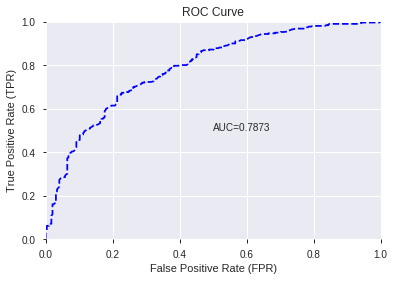

This function is available for GLM models only


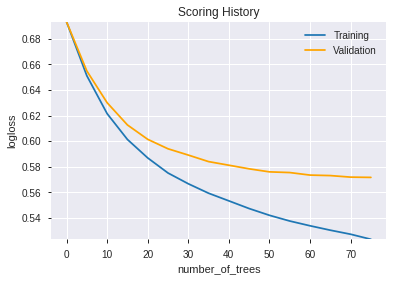

--2019-07-25 08:31:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_083113_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_083113_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_98e0',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_14',
 'ADOSC',
 'aroonup_8',
 'STOCHRSI_fastd',
 'STDDEV_30',
 'MFI_8',
 'WILLR_8',
 'NATR_30',
 'STDDEV_12',
 'WILLR_12',
 'MFI_14',
 'HT_PHASOR_quadrature',
 'aroonup_12',
 'PLUS_DI_8',
 'STOCHRSI_fastk',
 'DX_12',
 'WILLR_24',
 'BETA_8',
 'PLUS_DM_12',
 'ADXR_8',
 'ATR_14',
 'BETA_14',
 'ADXR_14',
 'MFI_12',
 'RSI_30',
 'BETA_20',
 'MINUS_DM_14',
 'LINEARREG_ANGLE_20',
 'MFI_30',
 'STOCH_slowd',
 'DX_20',
 'HT_PHASOR_inphase',
 'MA_8_6',
 'aroondown_30',
 'LINEARREG_ANGLE_8',
 'aroondown_12',
 'AROONOSC_8',
 'WILLR_14',
 'MOM_20',
 'MOM_8',
 'DX_24',
 'ROCP_8',
 'STOCHF_fastd',
 'aroonup_20',
 'MOM_30',
 'CMO_8']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.728
GLM             0.733
XGBoost         0.734
dtype: float64

DeepLearning    GLM  XGBoost
All          0.724  0.720    0.733
DLF          0.726  0.733    0.734
Fwe          0.712  0.726    0.721
RFE          0.728  0.715    0.721
XGBF         0.721  0.733    0.734





F1


DeepLearning    0.764
GLM             0.758
XGBoost         0.767
dtype: float64

DeepLearning    GLM  XGBoost
All          0.758  0.758    0.758
DLF          0.764  0.757    0.767
Fwe          0.742  0.746    0.753
RFE          0.753  0.755    0.756
XGBF         0.762  0.757    0.767





auc


DeepLearning    0.790
GLM             0.785
XGBoost         0.800
dtype: float64

DeepLearning    GLM  XGBoost
All          0.789  0.783    0.796
DLF          0.774  0.782    0.800
Fwe          0.769  0.775    0.790
RFE          0.790  0.785    0.787
XGBF         0.772  0.782    0.800





logloss


DeepLearning    0.590
GLM             0.588
XGBoost         0.565
dtype: float64

DeepLearning    GLM  XGBoost
All          0.569  0.588    0.555
DLF          0.590  0.570    0.550
Fwe          0.587  0.574    0.560
RFE          0.585  0.564    0.565
XGBF         0.577  0.570    0.550





mean_per_class_error


DeepLearning    0.291
GLM             0.289
XGBoost         0.277
dtype: float64

DeepLearning    GLM  XGBoost
All          0.279  0.281    0.268
DLF          0.278  0.270    0.264
Fwe          0.291  0.275    0.277
RFE          0.274  0.289    0.277
XGBF         0.280  0.270    0.264





rmse


DeepLearning    0.447
GLM             0.448
XGBoost         0.437
dtype: float64

DeepLearning    GLM  XGBoost
All          0.438  0.448    0.432
DLF          0.446  0.439    0.430
Fwe          0.447  0.440    0.435
RFE          0.446  0.437    0.437
XGBF         0.441  0.439    0.430





mse


DeepLearning    0.200
GLM             0.201
XGBoost         0.191
dtype: float64

DeepLearning    GLM  XGBoost
All          0.192  0.201    0.187
DLF          0.199  0.193    0.185
Fwe          0.200  0.194    0.189
RFE          0.199  0.191    0.191
XGBF         0.195  0.193    0.185

{'F1':       DeepLearning    GLM  XGBoost
 All          0.758    NaN      NaN
 DLF          0.764    NaN      NaN
 DLF            NaN  0.757      NaN
 DLF            NaN    NaN    0.767
 All            NaN  0.758      NaN
 All            NaN    NaN    0.758
 XGBF         0.762    NaN      NaN
 XGBF           NaN  0.757      NaN
 XGBF           NaN    NaN    0.767
 Fwe          0.742    NaN      NaN
 Fwe            NaN  0.746      NaN
 Fwe            NaN    NaN    0.753
 RFE          0.753    NaN      NaN
 RFE            NaN  0.755      NaN
 RFE            NaN    NaN    0.756,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.724    NaN      NaN
 DLF          0.726    NaN      NaN
 DLF            NaN  0.733      NaN
 DLF            NaN    NaN    0.734
 All            NaN  0.720      NaN
 All            NaN    NaN    0.733
 XGBF         0.721    NaN      NaN
 XGBF           NaN  0.733      NaN
 XGBF           NaN    NaN    0.734
 Fwe          0.712    NaN      NaN
 Fwe     